# Analysis of DNA-MERFISH for CTP11,12,13

by Pu Zheng

2022.07.07

analysis for dataset:

dna_data_folder = r'\\10.245.74.158\Chromatin_NAS_4\20220316-P_brain_CTP11-12-13_from_0304'

rna_data_folder = r'\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors'

save_folder = r'\\10.245.74.158\Chromatin_NAS_8\Analyzed_data\20220316-P_brain_CTP11-12-13_from_0304'

In [1]:
%run "..\..\Startup_py3.py"
sys.path.append(r"..\..\..\..\Documents")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast

91832


## 0.1 Folders

In [83]:
save_folder = r'\\10.245.74.158\Chromatin_NAS_8\Analyzed_data\20220316-P_brain_CTP11-12-13_from_0304'
save_filenames = [os.path.join(save_folder, _fl) for _fl in os.listdir(save_folder)
                  if _fl.split(os.extsep)[-1]=='hdf5']
# extract fov_id
save_fov_ids = [int(os.path.basename(_fl).split('.hdf5')[0].split('_')[-1]) for _fl in save_filenames]

debug = False

print(f"{len(save_filenames)} fovs detected")

analysis_folder = os.path.join(save_folder, 'Analysis_0706')

segmentation_folder = os.path.join(analysis_folder, 'Segmentation')
if not os.path.exists(segmentation_folder):
    os.makedirs(segmentation_folder)
    print(f"Creating segmentation_folder: {segmentation_folder}")
else:
    print(f"Use segmentation_folder: {segmentation_folder}")

cand_spot_folder = os.path.join(analysis_folder, 'CandSpots')
if not os.path.exists(cand_spot_folder):
    os.makedirs(cand_spot_folder)
    print(f"Creating cand_spot_folder: {cand_spot_folder}")
else:
    print(f"Use cand_spot_folder: {cand_spot_folder}")

decoder_folder = cand_spot_folder.replace('CandSpots', 'Decoder')
if debug:
    _version = 0
    while os.path.exists(os.path.join(decoder_folder, f'v{_version}')):
        _version += 1
    decoder_folder = os.path.join(decoder_folder, f'v{_version}')
if not os.path.exists(decoder_folder):
    os.makedirs(decoder_folder)
    print(f"Creating decoder_folder: {decoder_folder}")
else:
    print(f"Use decoder_folder: {decoder_folder}")
    
picked_folder = os.path.join(analysis_folder, 'Picked_v1')
if not os.path.exists(picked_folder):
    os.makedirs(picked_folder)
    print(f"Creating picked_folder: {picked_folder}")
else:
    print(f"Use picked_folder: {picked_folder}")

168 fovs detected
Use segmentation_folder: \\10.245.74.158\Chromatin_NAS_8\Analyzed_data\20220316-P_brain_CTP11-12-13_from_0304\Analysis_0706\Segmentation
Use cand_spot_folder: \\10.245.74.158\Chromatin_NAS_8\Analyzed_data\20220316-P_brain_CTP11-12-13_from_0304\Analysis_0706\CandSpots
Use decoder_folder: \\10.245.74.158\Chromatin_NAS_8\Analyzed_data\20220316-P_brain_CTP11-12-13_from_0304\Analysis_0706\Decoder
Use picked_folder: \\10.245.74.158\Chromatin_NAS_8\Analyzed_data\20220316-P_brain_CTP11-12-13_from_0304\Analysis_0706\Picked_v1


pixel_sizes = np.array([250,108,108])
single_im_size = np.array([50,2048,2048])

# 1. Decoding of DNA-MERFISH

In [5]:
# load two codebooks
import pandas as pd

ctp11_codebook = pd.read_csv(r'\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\Summary_tables\CTP11-1000_codebook_probe.csv', header=0)
ctp13_codebook = pd.read_csv(r'\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\Summary_tables\CTP13-mop_SE_1000.csv', header=0)


In [6]:
ctp11_codebook

name    id  NDB_784  NDB_755  NDB_826  NDB_713  NDB_865  \
0        1:3742742-3759944     1        0        0        0        0        0   
1        1:6245958-6258969     2        0        0        0        0        0   
2        1:8740008-8759916     3        0        0        0        0        0   
3      1:11247744-11257616     4        0        0        0        0        0   
4      1:13741888-13757922     5        0        0        0        0        0   
..                     ...   ...      ...      ...      ...      ...      ...   
983  X:161247067-161259813  1057        0        0        1        0        0   
984  X:163750534-163758706  1058        0        0        0        0        0   
985  X:166247682-166259932  1059        0        0        0        0        0   
986  X:168746045-168757590  1060        0        0        0        0        0   
987      Y:1245775-1259992  1062        0        0        0        0        0   

     NDB_725  NDB_817  NDB_710  ...  NDB_824  NDB_712  NDB_818  NDB_940  \
0          0        0        0  ...        0        0        0        0   
1          0        0        0  ...        0        0        0        0   
2          0        0        0  ...        0        0        0        0   
3          0        0        0  ...        0        0        0        1   
4          0        0        0  ...        0        0        1        0   
..       ...      ...      ...  ...      ...      ...      ...      ...   
983        0        0        0  ...        0        0        0        0   
984        0        0        0  ...        0        0        0        0   
985        1        0        0  ...        0        0        0        0   
986        0        0        0  ...        0        0        0        0   
987        0        0        1  ...        0        0        0        0   

     NDB_872  NDB_934  NDB_926  NDB_910  chr  chr_order  
0          0        0        0        0    1        0.0  
1          0        0        0        0    1        1.0  
2          0        0        0        0    1        2.0  
3          0        0        0        0    1        3.0  
4          0        0        0        0    1        4.0  
..       ...      ...      ...      ...  ...        ...  
983        0        1        0        0    X       52.0  
984        1        0        0        0    X       53.0  
985        0        0        0        0    X       54.0  
986        0        0        0        0    X       55.0  
987        0        0        0        0    Y        0.0  

[988 rows x 103 columns]

In [7]:
ctp13_codebook

name   id  NDB_376  NDB_578  NDB_400  NDB_533  NDB_568  \
0        1:9627926-9637875    1        0        0        0        1        0   
1        1:9799472-9811359    2        0        0        0        0        0   
2      1:20920666-20929358    3        0        0        0        0        0   
3      1:21522568-21534512    4        0        0        0        0        0   
4      1:21732182-21745770    5        0        0        0        0        0   
..                     ...  ...      ...      ...      ...      ...      ...   
961  X:101961397-101974103  987        0        0        0        0        0   
962  X:136808741-136818926  988        0        0        0        0        0   
963  X:140517829-140527051  989        0        0        0        0        0   
964  X:167157164-167167452  990        0        0        0        0        0   
965  X:169963295-170005197  991        0        0        0        1        0   

     NDB_464  NDB_466  NDB_431  ...  NDB_608  NDB_460  NDB_563  NDB_592  \
0          0        0        0  ...        0        0        0        0   
1          0        0        0  ...        0        0        0        1   
2          0        0        0  ...        1        0        0        0   
3          0        0        0  ...        0        0        0        0   
4          0        0        0  ...        0        0        0        0   
..       ...      ...      ...  ...      ...      ...      ...      ...   
961        0        0        0  ...        0        1        0        0   
962        0        0        0  ...        0        0        0        0   
963        0        0        0  ...        0        0        0        0   
964        0        0        0  ...        0        0        0        0   
965        0        0        0  ...        0        0        0        0   

     NDB_368  NDB_436  NDB_629  NDB_604  chr  chr_order  
0          0        0        0        0    1        0.0  
1          0        0        0        0    1        1.0  
2          0        0        0        0    1        2.0  
3          0        0        0        0    1        3.0  
4          0        0        0        0    1        4.0  
..       ...      ...      ...      ...  ...        ...  
961        0        0        0        0    X        2.0  
962        0        0        0        0    X        3.0  
963        0        0        0        0    X        4.0  
964        0        0        0        0    X        5.0  
965        0        0        0        0    X        6.0  

[966 rows x 99 columns]

## Load bit_2_name

In [8]:
readout_df_gn = pd.read_csv(r'\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\Summary_tables\CTP11-mouse-genome-1000_combo_readouts.csv')
readout_df_se = pd.read_csv(r'\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\Summary_tables\CTP13-mouse-SE_combo_readouts.csv')

# merge
readout_df_se['Bit']+=100
readout_df = pd.concat([readout_df_gn, readout_df_se])
readout_df

Bit ReadoutName
0     1     NDB_784
1     2     NDB_755
2     3     NDB_826
3     4     NDB_713
4     5     NDB_865
..  ...         ...
90  191     NDB_592
91  192     NDB_368
92  193     NDB_436
93  194     NDB_629
94  195     NDB_604

[194 rows x 2 columns]

## 3.3 prepare kwargs to decode CTP11

In [9]:
%%time
from tqdm import tqdm
from ImageAnalysis3.classes import new_decoder
reload(ia.classes.new_decoder)
from ImageAnalysis3.classes.new_decoder import batch_process_SpotDecoder

overwrite_decoder = True
verbose_decoder = True
return_decoder = False

pair_search_radius = 300
pair_search_eps = 0.25
ctp11_data_type = 'combo'
ctp11_lib_name = 'CTP11'
ctp11_decode_args = []
for _fov_id, _save_filename in zip(save_fov_ids, save_filenames):
    print(f"- Preparing decoding args for fov: {_fov_id},", end=' ')
    # load candidate spots for the fov
    cand_spot_filename = os.path.join(cand_spot_folder, ctp11_data_type,
                                      os.path.basename(_save_filename).replace('.hdf5', f'_CandSpots.csv') )
    if os.path.isfile(cand_spot_filename):
        _fov_spots_df = pd.read_csv(cand_spot_filename)
    else:
        continue # skip if fov doesn't exist
        
    for _cell_id in np.unique(_fov_spots_df['cell_id']):
        # get decoder filename
        _decoder_filename = os.path.join(decoder_folder, f"Decoded_fov-{_fov_id}_cell-{_cell_id}.hdf5")
        # check if overwrite:
        if not overwrite_decoder and os.path.exists(_decoder_filename):
            # skip if exists
            with h5py.File(_decoder_filename, 'r') as _f:
                if ctp11_lib_name in _f.keys():
                    continue
        # get cell_df
        _cell_spots_df =_fov_spots_df[_fov_spots_df['cell_id']==_cell_id]
        # prepare args
        ctp11_decode_args.append(
            (ctp11_lib_name, _cell_spots_df, ctp11_codebook, readout_df, _decoder_filename,
             pair_search_radius, pair_search_eps, overwrite_decoder, verbose_decoder, return_decoder)
        )
    print(len(ctp11_decode_args))

- Preparing decoding args for fov: 0, 112
- Preparing decoding args for fov: 1, 278
- Preparing decoding args for fov: 2, 319
- Preparing decoding args for fov: 3, 529
- Preparing decoding args for fov: 4, 717
- Preparing decoding args for fov: 5, 926
- Preparing decoding args for fov: 6, 1097
- Preparing decoding args for fov: 7, 1255
- Preparing decoding args for fov: 8, 1416
- Preparing decoding args for fov: 9, 1553
- Preparing decoding args for fov: 10, 1699
- Preparing decoding args for fov: 11, 1854
- Preparing decoding args for fov: 12, 2005
- Preparing decoding args for fov: 13, 2183
- Preparing decoding args for fov: 14, 2347
- Preparing decoding args for fov: 15, 2521
- Preparing decoding args for fov: 16, 2735
- Preparing decoding args for fov: 17, 2940
- Preparing decoding args for fov: 18, 2981
- Preparing decoding args for fov: 19, 3080
- Preparing decoding args for fov: 20, 3314
- Preparing decoding args for fov: 21, 3539
- Preparing decoding args for fov: 22, 3731
- Pr

## Test decoding for one cell

In [7]:
%matplotlib inline
from ImageAnalysis3.classes.new_decoder import batch_process_SpotMapper, batch_process_SpotDecoder
sel_cell = 10

# conbinatorial
batch_process_SpotDecoder(*ctp11_decode_args[sel_cell])
#batch_process_SpotDecoder(*ctp13_decode_args[sel_cell])
# sequential
#batch_process_SpotMapper(*ctp12_decode_args[sel_cell])

- Load decoder from file: \\10.245.74.158\Chromatin_NAS_8\Analyzed_data\20220316-P_brain_CTP11-12-13_from_0304\Analysis_0706\Decoder\Decoded_fov-0_cell-12.hdf5
-- savefile:\\10.245.74.158\Chromatin_NAS_8\Analyzed_data\20220316-P_brain_CTP11-12-13_from_0304\Analysis_0706\Decoder\Decoded_fov-0_cell-12.hdf5 not exist, skip
- Matching 194 bits to (988, 103) codebook


E:\Users\puzheng\Documents\ImageAnalysis3\classes\new_decoder.py:98: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.bit_codebook[_matched_bit[0]] = self.codebook[_col].copy()


-- 99 bits matched
- Process (988, 102) codebook into valid pairs
-- 2964 valid pairs detected.
- Searching for spot-pairs within 300nm.
-- find candidate pairs by KDTree
-- filter candidate pairs by codebook
-- 14151 pairs selected.
- Select spot_groups from candidate pairs with radius:300, max_usage=1
-- calculate scores for candSpotPairs


 87%|███████████████████████████████████████████████████████████████████▋          | 12276/14151 [00:00<00:00, 122668.58it/s]

-- 1440 full tuples selected


100%|██████████████████████████████████████████████████████████████████████████████| 14151/14151 [00:00<00:00, 121900.25it/s]


-- 1293 pairs selected
-- in total 2733 spot_groups detected
- Save decoder of CTP11 into file: \\10.245.74.158\Chromatin_NAS_8\Analyzed_data\20220316-P_brain_CTP11-12-13_from_0304\Analysis_0706\Decoder\Decoded_fov-0_cell-12.hdf5
-- existing info: [] and []
-- save bits
-- save search_radius to attrs
-- save search_eps to attrs
-- save readoutDf
-- save codebook
-- save candSpots
-- save spotGroups


E:\Users\puzheng\Documents\ImageAnalysis3\classes\new_decoder.py:388: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block4_values] [items->Index(['uid', 'homolog', 'channel_0', 'channel_1', 'channel_2', 'region_name',
       'start', 'end', 'chr'],
      dtype='object')]

  _spotGroupDf.to_hdf(self.saveFile, f'{self.codebook_name}/spotGroups', complevel=_complevel, complib=_complib)


- Save spot_stats iamage to file: \\10.245.74.158\Chromatin_NAS_8\Analyzed_data\20220316-P_brain_CTP11-12-13_from_0304\Analysis_0706\Decoder\Decoded_fov-0_cell-12_CTP11_stats.png


## Plot decoded spots

In [8]:
import matplotlib
import matplotlib.pyplot as plt
plt.rc('font', family='serif')
plt.rc('font', serif='Arial')
plt.style.use('dark_background')

matplotlib.rcParams['pdf.fonttype'] = 42

In [9]:
decoded_figure_folder = os.path.join(decoder_folder, 'Decoded_3D_figures')
print(decoded_figure_folder)
if not os.path.exists(decoded_figure_folder):
    os.makedirs(decoded_figure_folder)

\\10.245.74.158\Chromatin_NAS_8\Analyzed_data\20220316-P_brain_CTP11-12-13_from_0304\Analysis_0706\Decoder\Decoded_3D_figures


<IPython.core.display.Javascript object>


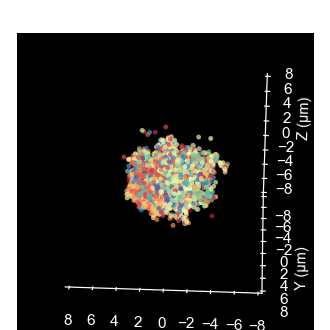

In [10]:
%matplotlib notebook
sel_lib = 'CTP11'
_decoded_groups = pd.read_hdf(ctp11_decode_args[sel_cell][4], f'{sel_lib}/spotGroups')
_zxys = _decoded_groups[['center_z', 'center_x', 'center_y']].values / 1000
_zxys = _zxys - np.nanmean(_zxys, axis=0)
_rids = _decoded_groups['region_id'].values

figure_width = 3
figure_dpi=100
marker_size = 10
marker_alpha = 0.7
_font_size = 7.5
plot_radius = 8
background_color = [0,0,0]
depthshade=False

fig = plt.figure(figsize=(figure_width, figure_width), dpi=figure_dpi)

ax3d = fig.add_subplot(111, projection='3d')
ax3d.set_facecolor(background_color)
fig.subplots_adjust(left=0, right=1, bottom=0, top=0.9)
# turn off grid if needed
ax3d.grid(False)
ax3d.xaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
ax3d.yaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
ax3d.zaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))

_valid_inds = (np.isnan(_zxys).sum(1) == 0)
_sc = ax3d.scatter(_zxys[_valid_inds,1], _zxys[_valid_inds,2], _zxys[_valid_inds,0],
                   c=_rids, cmap='Spectral',
                   s=marker_size, depthshade=depthshade, 
                   alpha=marker_alpha,
                   linewidth=0,)
# axes limits
ax3d.axes.set_xlim3d(left=-plot_radius, right=plot_radius) 
ax3d.axes.set_ylim3d(bottom=-plot_radius, top=plot_radius) 
ax3d.axes.set_zlim3d(bottom=-plot_radius, top=plot_radius) 
# axes ticks
ax3d.set_xticks(np.arange(-plot_radius,plot_radius+1, 2))
ax3d.set_yticks(np.arange(-plot_radius,plot_radius+1, 2))
ax3d.set_zticks(np.arange(-plot_radius,plot_radius+1, 2))
# axes labels
ax3d.set_xlabel(f"X (\u03BCm)", fontsize=_font_size+2, labelpad=1)
ax3d.set_ylabel(f"Y (\u03BCm)", fontsize=_font_size+2, labelpad=1)
ax3d.set_zlabel(f"Z (\u03BCm)", fontsize=_font_size+2, labelpad=1)

# save pdf and png
fig.savefig(os.path.join(decoded_figure_folder, 
                         f"{os.path.basename(ctp11_decode_args[sel_cell][4]).replace('.hdf5', f'_decoded_{sel_lib}.png')}"),
            transparent=True)

# Process All

In [10]:
%%time
from ImageAnalysis3.classes.new_decoder import batch_process_SpotDecoder
import multiprocessing as mp
print(len(ctp11_decode_args))
with mp.Pool(44) as decode_pool:
    decode_results = decode_pool.starmap(batch_process_SpotDecoder, ctp11_decode_args, chunksize=1)
    decode_pool.close()
    decode_pool.join()
    decode_pool.terminate()

29050
Wall time: 3h 24min 7s


In [11]:
# Delete args to release RAM
del(ctp11_decode_args)
del(decode_results)

## 3.4 prepare kwargs to decode CTP13

In [14]:
%%time
from tqdm import tqdm
from ImageAnalysis3.classes import new_decoder
reload(ia.classes.new_decoder)
from ImageAnalysis3.classes.new_decoder import batch_process_SpotDecoder

overwrite_decoder = True
verbose_decoder = True
return_decoder = False

pair_search_radius = 300
pair_search_eps = 0.25
ctp13_data_type = 'combo'
ctp13_lib_name = 'CTP13'
ctp13_decode_args = []
for _fov_id, _save_filename in zip(save_fov_ids, save_filenames):
    print(f"- Preparing decoding args for fov: {_fov_id},", end=' ')
    # load candidate spots for the fov
    cand_spot_filename = os.path.join(cand_spot_folder, ctp13_data_type,
                                      os.path.basename(_save_filename).replace('.hdf5', f'_CandSpots.csv') )
    if os.path.isfile(cand_spot_filename):
        _fov_spots_df = pd.read_csv(cand_spot_filename)
    else:
        continue # skip if fov doesn't exist
        
    for _cell_id in np.unique(_fov_spots_df['cell_id']):
        # get decoder filename
        _decoder_filename = os.path.join(decoder_folder, f"Decoded_fov-{_fov_id}_cell-{_cell_id}.hdf5")
        # check if overwrite:
        if not overwrite_decoder and os.path.exists(_decoder_filename):
            # skip if exists
            with h5py.File(_decoder_filename, 'r') as _f:
                if ctp13_lib_name in _f.keys():
                    continue
        # get cell_df
        _cell_spots_df =_fov_spots_df[_fov_spots_df['cell_id']==_cell_id]
        # prepare args
        ctp13_decode_args.append(
            (ctp13_lib_name, _cell_spots_df, ctp13_codebook, readout_df, _decoder_filename,
             pair_search_radius, pair_search_eps, overwrite_decoder, verbose_decoder, return_decoder)
        )
    print(len(ctp13_decode_args))

- Preparing decoding args for fov: 0, 112
- Preparing decoding args for fov: 1, 278
- Preparing decoding args for fov: 2, 319
- Preparing decoding args for fov: 3, 529
- Preparing decoding args for fov: 4, 717
- Preparing decoding args for fov: 5, 926
- Preparing decoding args for fov: 6, 1097
- Preparing decoding args for fov: 7, 1255
- Preparing decoding args for fov: 8, 1416
- Preparing decoding args for fov: 9, 1553
- Preparing decoding args for fov: 10, 1699
- Preparing decoding args for fov: 11, 1854
- Preparing decoding args for fov: 12, 2005
- Preparing decoding args for fov: 13, 2183
- Preparing decoding args for fov: 14, 2347
- Preparing decoding args for fov: 15, 2521
- Preparing decoding args for fov: 16, 2735
- Preparing decoding args for fov: 17, 2940
- Preparing decoding args for fov: 18, 2981
- Preparing decoding args for fov: 19, 3080
- Preparing decoding args for fov: 20, 3314
- Preparing decoding args for fov: 21, 3539
- Preparing decoding args for fov: 22, 3731
- Pr

## Test decoding the same cell

In [15]:
%matplotlib inline
from ImageAnalysis3.classes.new_decoder import batch_process_SpotMapper, batch_process_SpotDecoder

# conbinatorial
#batch_process_SpotDecoder(*ctp11_decode_args[sel_cell])
batch_process_SpotDecoder(*ctp13_decode_args[sel_cell])
# sequential
#batch_process_SpotMapper(*ctp12_decode_args[sel_cell])

NameError: name 'sel_cell' is not defined

In [ ]:
%matplotlib notebook
sel_lib = 'CTP13'
_decoded_groups = pd.read_hdf(ctp13_decode_args[sel_cell][4], f'{sel_lib}/spotGroups')
_zxys = _decoded_groups[['center_z', 'center_x', 'center_y']].values / 1000
_zxys = _zxys - np.nanmean(_zxys, axis=0)
_rids = _decoded_groups['region_id'].values

figure_width = 3
figure_dpi=100
marker_size = 10
marker_alpha = 0.7
_font_size = 7.5
plot_radius = 8
background_color = [0,0,0]
depthshade=False

fig = plt.figure(figsize=(figure_width, figure_width), dpi=figure_dpi)

ax3d = fig.add_subplot(111, projection='3d')
ax3d.set_facecolor(background_color)
fig.subplots_adjust(left=0, right=1, bottom=0, top=0.9)
# turn off grid if needed
ax3d.grid(False)
ax3d.xaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
ax3d.yaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
ax3d.zaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))

_valid_inds = (np.isnan(_zxys).sum(1) == 0)
_sc = ax3d.scatter(_zxys[_valid_inds,1], _zxys[_valid_inds,2], _zxys[_valid_inds,0],
                   c=_rids, cmap='Spectral',
                   s=marker_size, depthshade=depthshade, 
                   alpha=marker_alpha,
                   linewidth=0,)
# axes limits
ax3d.axes.set_xlim3d(left=-plot_radius, right=plot_radius) 
ax3d.axes.set_ylim3d(bottom=-plot_radius, top=plot_radius) 
ax3d.axes.set_zlim3d(bottom=-plot_radius, top=plot_radius) 
# axes ticks
ax3d.set_xticks(np.arange(-plot_radius,plot_radius+1, 2))
ax3d.set_yticks(np.arange(-plot_radius,plot_radius+1, 2))
ax3d.set_zticks(np.arange(-plot_radius,plot_radius+1, 2))
# axes labels
ax3d.set_xlabel(f"X (\u03BCm)", fontsize=_font_size+2, labelpad=1)
ax3d.set_ylabel(f"Y (\u03BCm)", fontsize=_font_size+2, labelpad=1)
ax3d.set_zlabel(f"Z (\u03BCm)", fontsize=_font_size+2, labelpad=1)

# save pdf and png
fig.savefig(os.path.join(decoded_figure_folder, 
                         f"{os.path.basename(ctp13_decode_args[sel_cell][4]).replace('.hdf5', f'_decoded_{sel_lib}.png')}"),
            transparent=True)

## Process ALL

In [16]:
%%time
from ImageAnalysis3.classes.new_decoder import batch_process_SpotDecoder
import multiprocessing as mp
print(len(ctp13_decode_args))
with mp.Pool(44) as decode_pool:
    decode_results = decode_pool.starmap(batch_process_SpotDecoder, ctp13_decode_args, chunksize=1)
    decode_pool.close()
    decode_pool.join()
    decode_pool.terminate()

29050
Wall time: 2h 54min 32s


In [17]:
# Delete args to release RAM
del(ctp13_decode_args)
del(decode_results)

# 5. CTP12, sequential TSS for markergenes

## 5.1 prepare kwargs to map sequential CTP12

In [23]:
ctp12_codebook = pd.read_csv(r'\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-12_mop_markers\Summary_tables\CTP12-TSS_sequential-codebook.csv', header=0)
ctp12_codebook

name       id chr  Stv_91  Stv_32  Stv_92  Stv_33  \
0      5:31098237-31118237  Slc30a3   5       1       0       0       0   
1      7:45153949-45173949  Slc17a7   7       0       1       0       0   
2    2:158600767-158620767  Slc32a1   2       0       0       1       0   
3      2:70543072-70563072     Gad1   2       0       0       0       1   
4      5:30451932-30471932     Otof   5       0       0       0       0   
5    4:124976430-124996430    Rspo1   4       0       0       0       0   
6     15:78196400-78216400    Pvalb  15       0       0       0       0   
7     16:23880958-23900958      Sst  16       0       0       0       0   
8       10:5629218-5649218      Vip  10       0       0       0       0   
9     14:34364789-34384789     Sncg  14       0       0       0       0   
10   2:136042239-136062239    Lamp5   2       0       0       0       0   
11    15:60843778-60863778   Lratd2  15       0       0       0       0   
12   2:169623013-169643013    Tshz2   2       0       0       0       0   
13   3:103565231-103585231     Syt6   3       0       0       0       0   
14  10:127524559-127544559    Nxph4  10       0       0       0       0   
15   5:122040102-122060102     Cux2   5       0       0       0       0   
16    19:19101196-19121196     Rorb  19       0       0       0       0   
17   2:166145663-166165663    Sulf2   2       0       0       0       0   
18   4:131828288-131848288    Ptpru   4       0       0       0       0   
19     3:14853512-14873512     Car3   3       0       0       0       0   
20    18:15400982-15420982     Aqp4  18       0       0       0       0   
21   5:147716011-147736011     Flt1   5       0       0       0       0   
22   7:142656816-142676816     Igf2   7       0       0       0       0   
23     5:75142292-75162292   Pdgfra   5       0       0       0       0   
24    15:79155240-79175240    Sox10  15       0       0       0       0   
25     3:95516786-95536786     Ctss   3       0       0       0       0   
26    11:78489091-78509091      Vtn  11       0       0       0       0   
27     X:73473602-73493602      Bgn   X       0       0       0       0   

    Stv_94  Stv_35  Stv_95  ...  Stv_106  Stv_45  Stv_107  Stv_46  Stv_109  \
0        0       0       0  ...        0       0        0       0        0   
1        0       0       0  ...        0       0        0       0        0   
2        0       0       0  ...        0       0        0       0        0   
3        0       0       0  ...        0       0        0       0        0   
4        1       0       0  ...        0       0        0       0        0   
5        0       1       0  ...        0       0        0       0        0   
6        0       0       1  ...        0       0        0       0        0   
7        0       0       0  ...        0       0        0       0        0   
8        0       0       0  ...        0       0        0       0        0   
9        0       0       0  ...        0       0        0       0        0   
10       0       0       0  ...        0       0        0       0        0   
11       0       0       0  ...        0       0        0       0        0   
12       0       0       0  ...        0       0        0       0        0   
13       0       0       0  ...        0       0        0       0        0   
14       0       0       0  ...        0       0        0       0        0   
15       0       0       0  ...        0       0        0       0        0   
16       0       0       0  ...        0       0        0       0        0   
17       0       0       0  ...        0       0        0       0        0   
18       0       0       0  ...        1       0        0       0        0   
19       0       0       0  ...        0       1        0       0        0   
20       0       0       0  ...        0       0        1       0        0   
21       0       0       0  ...        0       0        0       1        0   
22       0       0       0  ...        0       0    

In [24]:
ctp12_readout_df = pd.read_csv(r'\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-12_mop_markers\Summary_tables\CTP12-TSS_unique_readouts.csv', header=0)
ctp12_readout_df

Bit ReadoutName
0     1      Stv_91
1     2      Stv_32
2     3      Stv_92
3     4      Stv_33
4     5      Stv_94
5     6      Stv_35
6     7      Stv_95
7     8      Stv_36
8     9      Stv_99
9    10      Stv_37
10   11     Stv_100
11   12      Stv_39
12   13     Stv_101
13   14      Stv_40
14   15     Stv_104
15   16      Stv_42
16   17     Stv_105
17   18      Stv_44
18   19     Stv_106
19   20      Stv_45
20   21     Stv_107
21   22      Stv_46
22   23     Stv_109
23   24      Stv_48
24   25     Stv_118
25   26      Stv_50
26   27     Stv_119
27   28      Stv_53

In [25]:
%%time
from tqdm import tqdm
from ImageAnalysis3.classes import new_decoder
reload(ia.classes.new_decoder)
from ImageAnalysis3.classes.new_decoder import batch_process_SpotMapper

overwrite_decoder = True
verbose_decoder = True
return_decoder = False

ctp12_lib_name = 'CTP12tss'
ctp12_data_type = 'unique'
ctp12_decode_args = []

for _fov_id, _save_filename in zip(save_fov_ids, save_filenames):
    print(f"- Preparing decoding args for fov: {_fov_id},", end=' ')
    # load candidate spots for the fov
    cand_spot_filename = os.path.join(cand_spot_folder, ctp12_data_type,
                                      os.path.basename(_save_filename).replace('.hdf5', f'_CandSpots.csv') )
    if os.path.isfile(cand_spot_filename):
        _fov_spots_df = pd.read_csv(cand_spot_filename)
    else:
        print(f"-- skip")
        continue # skip if fov doesn't exist
        
    for _cell_id in np.unique(_fov_spots_df['cell_id']):
        # get decoder filename
        _decoder_filename = os.path.join(decoder_folder, f"Decoded_fov-{_fov_id}_cell-{_cell_id}.hdf5")
        # check if overwrite:
        if not overwrite_decoder and os.path.exists(_decoder_filename):
            # skip if exists
            with h5py.File(_decoder_filename, 'r') as _f:
                if ctp12_lib_name in _f.keys():
                    continue

        # get decoder filename
        _decoder_filename = os.path.join(decoder_folder, f"Decoded_fov-{_fov_id}_cell-{_cell_id}.hdf5")
        # get cell_df
        _cell_spots_df =_fov_spots_df[_fov_spots_df['cell_id']==_cell_id]
        # prepare args
        ctp12_decode_args.append(
            (ctp12_lib_name, _cell_spots_df, ctp12_codebook, ctp12_readout_df, _decoder_filename,
             pair_search_radius, pair_search_eps, overwrite_decoder, verbose_decoder, return_decoder)
        )
    print(len(ctp12_decode_args))
    break

- Preparing decoding args for fov: 0, 110
Wall time: 213 ms


## Process ALL

In [23]:
from ImageAnalysis3.classes.new_decoder import batch_process_SpotMapper, batch_process_SpotDecoder
import multiprocessing as mp

In [24]:
%%time
print(len(ctp12_decode_args))
with mp.Pool(32) as decode_pool:
    decode_results = decode_pool.starmap(batch_process_SpotMapper, ctp12_decode_args, chunksize=1)
    decode_pool.close()
    decode_pool.join()
    decode_pool.terminate()

28667
Wall time: 26min 2s


## load decoded results

In [27]:
sel_col = ['region_name', 'chr','start','end','center_intensity', 'center_z', 'center_x', 'center_y']
#sel_cell = 10
sel_filename = ctp12_decode_args[sel_cell][4]

ctp11_decoded_df = pd.read_hdf(sel_filename, 'CTP11/spotGroups')[sel_col]
ctp13_decoded_df = pd.read_hdf(sel_filename, 'CTP13/spotGroups')[sel_col]

ctp12_decoded_df = pd.read_hdf(sel_filename, 'CTP12tss/candSpots')[sel_col]

## 3D rendering of decoded spots

In [28]:
decoded_figure_folder = os.path.join(decoder_folder, 'Decoded_3D')
if not os.path.exists(decoded_figure_folder):
    os.makedirs(decoded_figure_folder)

In [29]:
from matplotlib import animation
plot_animation = True
angle = 3

from ImageAnalysis3.figure_tools import _dpi,_single_col_width,_double_col_width,_single_row_height,_ref_bar_length, _ticklabel_size,_ticklabel_width,_font_size
figure_width = _double_col_width
figure_dpi=100
background_color = [0,0,0]
marker_size = 8
marker_alpha = 1

depthshade=False

<IPython.core.display.Javascript object>


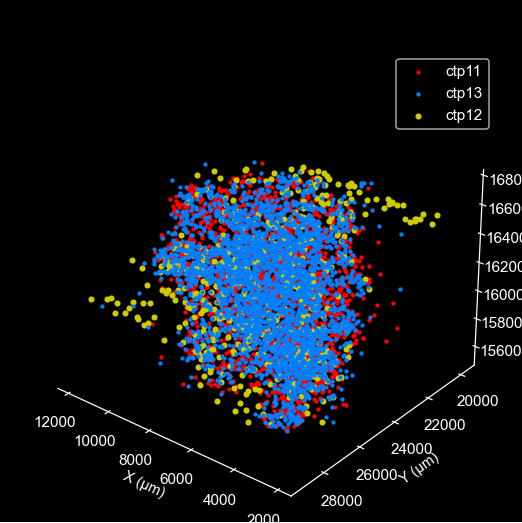

In [30]:
%matplotlib notebook
plt.rc('font', family='serif')
plt.rc('font', serif='Arial')
plt.style.use('dark_background')
fig = plt.figure(figsize=(figure_width, figure_width), dpi=figure_dpi)
ax3d = fig.add_subplot(111, projection='3d')
ax3d.set_facecolor(background_color)
fig.subplots_adjust(left=0, right=1, bottom=0, top=0.9)
# turn off grid if needed
ax3d.grid(False)
ax3d.xaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
ax3d.yaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
ax3d.zaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))

#"ctp11"
_sc = ax3d.scatter(ctp11_decoded_df['center_z'], ctp11_decoded_df['center_x'], ctp11_decoded_df['center_y'], 
                   color=[1,0,0,1], 
                   s=marker_size, depthshade=depthshade, 
                   alpha=marker_alpha,
                   #edgecolors=_edge_colors, 
                   linewidth=0, label='ctp11')
#"ctp13"
_sc = ax3d.scatter(ctp13_decoded_df['center_z'], ctp13_decoded_df['center_x'], ctp13_decoded_df['center_y'], 
                   color=[0,0.5,1,1], 
                   s=marker_size, depthshade=depthshade, 
                   alpha=marker_alpha,
                   #edgecolors=_edge_colors, 
                   linewidth=0, label='ctp13')
#"ctp12"
_sc = ax3d.scatter(ctp12_decoded_df['center_z'], ctp12_decoded_df['center_x'], ctp12_decoded_df['center_y'], 
                   color=[0.8,0.8,0,1], 
                   s=marker_size*2, depthshade=depthshade, 
                   alpha=1,
                   #edgecolors=_edge_colors, 
                   linewidth=0, label='ctp12')
ax3d.legend()

# axes labels
ax3d.set_xlabel(f"X (\u03BCm)", fontsize=_font_size+2, labelpad=1)
ax3d.set_ylabel(f"Y (\u03BCm)", fontsize=_font_size+2, labelpad=1)
ax3d.set_zlabel(f"Z (\u03BCm)", fontsize=_font_size+2, labelpad=1)
if plot_animation:
    def rotate3D(angle):
         ax3d.view_init(azim=angle)
    ani = animation.FuncAnimation(fig, rotate3D, frames=np.arange(0, 360*2, angle), interval=50)
    ani.save(os.path.join(decoded_figure_folder, f"3D_{os.path.basename(sel_filename).replace('.hdf5','.gif')}"), 
             writer=animation.PillowWriter(fps=30), )
fig.show()

# Exporting dataset for Blair

In [31]:
reload(ia.classes.picker)

AttributeError: module 'ImageAnalysis3.classes' has no attribute 'picker'

In [32]:
from ImageAnalysis3.classes.picker import SpotPicker
from tqdm import tqdm
import re

decoder_file_regex = r'Decoded_fov-(?P<fovId>[0-9]+)_cell-(?P<cellId>[0-9]+).hdf5'
decoder_filenames = [os.path.join(decoder_folder, _fl) for _fl in tqdm(os.listdir(decoder_folder)) 
                     if re.search(decoder_file_regex, _fl) is not None
                    ]
# sort
decoder_filenames = [_fl for _fl in sorted(decoder_filenames,
                                          key=lambda _fl: (int(re.search(decoder_file_regex, _fl).groupdict()['fovId']), 
                                           int(re.search(decoder_file_regex, _fl).groupdict()['cellId'])) )
                    ]

100%|██████████████████████████████████████████████████████████████████████████████| 86759/86759 [00:00<00:00, 346777.05it/s]


In [33]:
export_folder = r'\\10.245.74.158\Chromatin_NAS_8\Exported_data\20220316-Export_new_v2'
if not os.path.exists(export_folder):
    os.makedirs(export_folder)
    print(f"Creating export_folder: {export_folder}")
else:
    print(f"Use export_folder: {export_folder}")

Use export_folder: \\10.245.74.158\Chromatin_NAS_8\Exported_data\20220316-Export_new_v2


### load dict from fovCellId_2_class

In [69]:
segmentation_folder

'\\\\10.245.74.158\\Chromatin_NAS_8\\Analyzed_data\\20220316-P_brain_CTP11-12-13_from_0304\\Analysis_0706\\Segmentation'

In [57]:
%%time
fovcell_2_uid = {}
for _fov_id, _save_filename in zip(save_fov_ids, save_filenames):
    # segmentation filename
    _segmentation_savefile = os.path.join(segmentation_folder, 
        os.path.basename(_save_filename).replace('.hdf5', '_Segmentation.hdf5') )
    
    with h5py.File(_segmentation_savefile, 'r') as _f:
        for _fov_id in _f.keys():
            _fov_group = _f[_fov_id]
            _uid_group = _fov_group['cell_2_uid']
            for _cell_id in _uid_group.keys():
                fovcell_2_uid[(_fov_id, _cell_id)] = _uid_group[_cell_id][:][0].decode()
import scanpy as sc
# load cell type info
merfish_cluster_file = r'\\mendel\Mendel_SSD3\MERFISH_Analysis\Merged_MOP\manual_labeled_data.h5ad'
merfish_df = sc.read_h5ad(merfish_cluster_file)
print(len(merfish_df))
print(np.unique(merfish_df.obs['experiment']) )

62709
['20220304' '20220329' '20220415' '20220418']
Wall time: 24.2 s


In [70]:
# load specifically this experiment
sel_exp = '20220304'
sel_obs = merfish_df.obs.loc[merfish_df.obs['experiment']==sel_exp]
uid_2_class = {_uid:_class for _uid, _class in zip(sel_obs.index, sel_obs['subclass_manual_label'])}
print(len(uid_2_class))
# assemble fovcell_2_class dict
fovcell_2_class = {}
for _decoder_fl in tqdm(decoder_filenames):
    _reg_match = re.search(decoder_file_regex, _decoder_fl)
    _fov_id, _cell_id = _reg_match.groupdict()['fovId'], _reg_match.groupdict()['cellId']
    if (_fov_id, _cell_id) in fovcell_2_uid:
        _uid = fovcell_2_uid[ (_fov_id, _cell_id) ]
        if _uid in uid_2_class:
            fovcell_2_class[(_fov_id, _cell_id)] = uid_2_class[_uid]
        else:
            fovcell_2_class[(_fov_id, _cell_id)] = 'other'
print(len(fovcell_2_class))

100%|██████████████████████████████████████████████████████████████████████████████| 29070/29070 [00:00<00:00, 207488.29it/s]

17840
29070


In [35]:
sel_exp

'20220329'

100%|████████████████████████████████████████████████████████████████████████| 29070/29070 [00:00<00:00, 245849.20it/s]


In [71]:
uid_2_class

{'103489270985795086009915676188840872439': 'Astro',
 '113811790893231448949429397438012891173': 'other',
 '119547840309256440899855144626134392385': 'L5 IT',
 '120849314423504941338008541020153695260': 'other',
 '125550627244524118102850004242680097855': 'Peri',
 '137067514191678327307128103182192887148': 'other',
 '14507384986925064706035195840422506028': 'OPC',
 '146535126853720688714614085779839345592': 'Peri',
 '151459858107966363147624177194154383017': 'other',
 '155605051744766234387328134435740959651': 'Endo',
 '163027562248160563690410058677139041188': 'other',
 '179117357717369278884189379535888871018': 'Oligo',
 '180000378540348429857243665909022955874': 'other',
 '20044807143244513503617327460738935047': 'other',
 '200797358114667439839852271107727905506': 'Astro',
 '215777698097917020284697921565780680932': 'other',
 '221530324723326400376518260092749510001': 'other',
 '229101657499113028322381661564197595094': 'other',
 '239474879795136047541267929805632762021': 'other',


In [66]:
merfish_df.obs.index

Index(['103489270985795086009915676188840872439',
       '113811790893231448949429397438012891173',
       '119547840309256440899855144626134392385',
       '120849314423504941338008541020153695260',
       '125550627244524118102850004242680097855',
       '137067514191678327307128103182192887148',
       '14507384986925064706035195840422506028',
       '146535126853720688714614085779839345592',
       '151459858107966363147624177194154383017',
       '155605051744766234387328134435740959651',
       ...
       '88220318207001201611684115599608262808',
       '93369905293795937987124665142143186883',
       '99490395144057509366994272448407870350',
       '145067729823536769130717941528157108233',
       '177270455615101854391932151666965549820',
       '216743509822996359971425086529065233172',
       '235791795914903367868231154493525204064',
       '281137009595534032327996677664017059078',
       '53631180073186654291241335400076244597',
       '914387205780847727661532542086687213

In [64]:
merfish_df.obs.loc[merfish_df.obs.index==_uid]

Empty DataFrame
Columns: [fov, volume, center_x, center_y, min_x, max_x, min_y, max_y, experiment, n_genes_by_counts, total_counts, doublet_score, predicted_doublet, leiden, leiden_subclass, subclass_prediction_label, leiden_subclass_sub, subclass_manual_label, subclass_manual_label_predict]
Index: []

In [73]:
fovcell_2_class

{('0', '1'): 'other',
 ('0', '3'): 'other',
 ('0', '4'): 'other',
 ('0', '5'): 'OPC',
 ('0', '6'): 'Endo',
 ('0', '7'): 'OPC',
 ('0', '8'): 'other',
 ('0', '9'): 'other',
 ('0', '10'): 'other',
 ('0', '11'): 'other',
 ('0', '12'): 'Oligo',
 ('0', '13'): 'other',
 ('0', '14'): 'other',
 ('0', '15'): 'other',
 ('0', '16'): 'other',
 ('0', '17'): 'other',
 ('0', '18'): 'other',
 ('0', '19'): 'other',
 ('0', '20'): 'other',
 ('0', '21'): 'L5 IT',
 ('0', '22'): 'other',
 ('0', '23'): 'other',
 ('0', '24'): 'other',
 ('0', '25'): 'other',
 ('0', '26'): 'Oligo',
 ('0', '27'): 'Micro',
 ('0', '28'): 'other',
 ('0', '29'): 'Peri',
 ('0', '30'): 'other',
 ('0', '31'): 'other',
 ('0', '32'): 'Endo',
 ('0', '33'): 'other',
 ('0', '34'): 'other',
 ('0', '35'): 'Astro',
 ('0', '36'): 'Micro',
 ('0', '37'): 'OPC',
 ('0', '38'): 'other',
 ('0', '39'): 'Astro',
 ('0', '40'): 'other',
 ('0', '41'): 'other',
 ('0', '42'): 'other',
 ('0', '43'): 'other',
 ('0', '44'): 'Peri',
 ('0', '45'): 'other',
 ('0',

## export

In [44]:
fovcell_2_class

{('0', '1'): 'other',
 ('0', '3'): 'other',
 ('0', '4'): 'other',
 ('0', '5'): 'other',
 ('0', '6'): 'other',
 ('0', '7'): 'other',
 ('0', '8'): 'other',
 ('0', '9'): 'other',
 ('0', '10'): 'other',
 ('0', '11'): 'other',
 ('0', '12'): 'other',
 ('0', '13'): 'other',
 ('0', '14'): 'other',
 ('0', '15'): 'other',
 ('0', '16'): 'other',
 ('0', '17'): 'other',
 ('0', '18'): 'other',
 ('0', '19'): 'other',
 ('0', '20'): 'other',
 ('0', '21'): 'other',
 ('0', '22'): 'other',
 ('0', '23'): 'other',
 ('0', '24'): 'other',
 ('0', '25'): 'other',
 ('0', '26'): 'other',
 ('0', '27'): 'other',
 ('0', '28'): 'other',
 ('0', '29'): 'other',
 ('0', '30'): 'other',
 ('0', '31'): 'other',
 ('0', '32'): 'other',
 ('0', '33'): 'other',
 ('0', '34'): 'other',
 ('0', '35'): 'other',
 ('0', '36'): 'other',
 ('0', '37'): 'other',
 ('0', '38'): 'other',
 ('0', '39'): 'other',
 ('0', '40'): 'other',
 ('0', '41'): 'other',
 ('0', '42'): 'other',
 ('0', '43'): 'other',
 ('0', '44'): 'other',
 ('0', '45'): 'othe

In [81]:
min_decoded_num = 400

for _decoder_fl in tqdm(decoder_filenames):
    _reg_match = re.search(decoder_file_regex, _decoder_fl)
    _fov_id, _cell_id = _reg_match.groupdict()['fovId'], _reg_match.groupdict()['cellId']
    # skip other
    if fovcell_2_class[(_fov_id, _cell_id)] == 'other':
        continue
    # export info
    export_filename = os.path.join(export_folder, f"Decoded_Fov-{_fov_id}.hdf5")
    #if os.path.exists(export_filename) and f"Cell-{_cell_id}" in h5py.File(export_filename).keys():
    #    continue
    # load
    _cls = SpotPicker(_decoder_fl, verbose=False, save_file=None)
    _cls._load_decoded()
    _cls._merge_decoded()
    if not hasattr(_cls, 'merged_coords'):
        continue
    # save
    if len(_cls.merged_coords) > min_decoded_num:
        _cls.merged_coords['subclass'] = fovcell_2_class[(_fov_id, _cell_id)]
        _cls.merged_coords.to_hdf(export_filename, f"Cell-{_cell_id}")


  0%|                                                                                              | 0/29070 [00:00<?, ?it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-5'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  0%|                                                                                      | 4/29070 [00:00<48:21, 10.02it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-6'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  0%|       

  0%|▏                                                                                  | 68/29070 [00:13<1:48:50,  4.44it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-74'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  0%|▏                                                                                  | 73/29070 [00:13<1:33:09,  5.19it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-86'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  0%|▏                                                                                  | 68/29070 [00:13<1:48:50,  4.44it/s]E:\Users\puzheng\AppData\an

  0%|▎                                                                                 | 126/29070 [00:29<6:30:47,  1.23it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-15'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  0%|▎                                                                                 | 127/29070 [00:30<6:08:41,  1.31it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-16'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  0%|▎                                                                                 | 126/29070 [00:29<6:30:47,  1.23it/s]E:\Users\puzheng\AppData\an

  0%|▍                                                                                 | 145/29070 [00:41<4:35:49,  1.75it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-34'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  1%|▍                                                                                 | 146/29070 [00:42<4:36:52,  1.74it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-35'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  0%|▍                                                                                 | 145/29070 [00:41<4:35:49,  1.75it/s]E:\Users\puzheng\AppData\an

  1%|▍                                                                                 | 166/29070 [00:53<3:36:06,  2.23it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-55'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  1%|▍                                                                                 | 167/29070 [00:54<5:09:29,  1.56it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-56'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  1%|▍                                                                                 | 166/29070 [00:53<3:36:06,  2.23it/s]E:\Users\puzheng\AppData\an

  1%|▌                                                                                 | 185/29070 [01:06<5:27:37,  1.47it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-74'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  1%|▌                                                                                 | 186/29070 [01:07<6:12:33,  1.29it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-75'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  1%|▌                                                                                 | 185/29070 [01:06<5:27:37,  1.47it/s]E:\Users\puzheng\AppData\an

  1%|▌                                                                                 | 218/29070 [01:20<4:35:51,  1.74it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-107'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  1%|▌                                                                                 | 219/29070 [01:21<4:30:02,  1.78it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-108'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  1%|▌                                                                                 | 218/29070 [01:20<4:35:51,  1.74it/s]E:\Users\puzheng\AppData\

  1%|▋                                                                                 | 241/29070 [01:32<4:47:01,  1.67it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-130'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  1%|▋                                                                                 | 242/29070 [01:32<4:39:23,  1.72it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-133'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  1%|▋                                                                                 | 241/29070 [01:32<4:47:01,  1.67it/s]E:\Users\puzheng\AppData\

  1%|▊                                                                                 | 274/29070 [01:42<2:55:33,  2.73it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-165'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  1%|▊                                                                                 | 277/29070 [01:43<2:40:06,  3.00it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-167'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  1%|▊

  1%|▉                                                                                 | 338/29070 [01:57<4:48:29,  1.66it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-21'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  1%|▉                                                                                 | 340/29070 [01:57<4:16:46,  1.86it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-24'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  1%|▉                                                                                 | 338/29070 [01:57<4:48:29,  1.66it/s]E:\Users\puzheng\AppData\an

  1%|█                                                                                 | 361/29070 [02:08<4:45:58,  1.67it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-43'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  1%|█                                                                                 | 362/29070 [02:09<4:22:30,  1.82it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-44'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  1%|█                                                                                 | 361/29070 [02:08<4:45:58,  1.67it/s]E:\Users\puzheng\AppData\an

  1%|█                                                                                 | 382/29070 [02:19<4:48:56,  1.65it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-65'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  1%|█                                                                                 | 384/29070 [02:20<3:58:37,  2.00it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-66'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  1%|█                                                                                 | 382/29070 [02:19<4:48:56,  1.65it/s]E:\Users\puzheng\AppData\an

  1%|█▏                                                                                | 402/29070 [02:30<5:09:24,  1.54it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-84'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  1%|█▏                                                                                | 403/29070 [02:30<4:54:54,  1.62it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-85'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  1%|█▏                                                                                | 402/29070 [02:30<5:09:24,  1.54it/s]E:\Users\puzheng\AppData\an

  1%|█▏                                                                                | 428/29070 [02:41<3:59:56,  1.99it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-111'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  1%|█▏                                                                                | 429/29070 [02:41<4:29:07,  1.77it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-113'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  1%|█▏ 

  2%|█▎                                                                                | 457/29070 [02:51<2:31:51,  3.14it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-141'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  2%|█▎                                                                                | 459/29070 [02:52<2:22:05,  3.36it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-142'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  2%|█▎                                                                                | 457/29070 [02:51<2:31:51,  3.14it/s]E:\Users\puzheng\AppData\

  2%|█▎                                                                                | 486/29070 [03:03<4:37:01,  1.72it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-171'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  2%|█▎                                                                                | 487/29070 [03:04<4:41:43,  1.69it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-173'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  2%|█▍ 

  2%|█▍                                                                                | 506/29070 [03:13<4:06:59,  1.93it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-191'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  2%|█▍                                                                                | 507/29070 [03:14<4:01:29,  1.97it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-193'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  2%|█▍                                                                                | 506/29070 [03:13<4:06:59,  1.93it/s]E:\Users\puzheng\AppData\

  2%|█▌                                                                                | 536/29070 [03:25<3:58:35,  1.99it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-10'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  2%|█▌                                                                                | 538/29070 [03:26<3:36:41,  2.19it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-11'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  2%|█▌                                                                                | 536/29070 [03:25<3:58:35,  1.99it/s]E:\Users\puzheng\AppData\an

  2%|█▌                                                                                | 559/29070 [03:35<3:28:03,  2.28it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-33'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  2%|█▌                                                                                | 561/29070 [03:36<3:03:17,  2.59it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-35'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  2%|█▌                                                                                | 559/29070 [03:35<3:28:03,  2.28it/s]E:\Users\puzheng\AppData\an

  2%|█▋                                                                                | 578/29070 [03:45<4:20:42,  1.82it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-51'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  2%|█▋                                                                                | 579/29070 [03:45<4:37:17,  1.71it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-54'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  2%|█▋                                                                                | 578/29070 [03:45<4:20:42,  1.82it/s]E:\Users\puzheng\AppData\an

  2%|█▋                                                                                | 610/29070 [03:55<3:20:15,  2.37it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-85'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  2%|█▋                                                                                | 613/29070 [03:56<3:03:01,  2.59it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-87'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  2%|█▋ 

  2%|█▊                                                                                | 637/29070 [04:07<4:55:32,  1.60it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-110'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  2%|█▊                                                                                | 638/29070 [04:08<4:48:14,  1.64it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-113'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  2%|█▊                                                                                | 637/29070 [04:07<4:55:32,  1.60it/s]E:\Users\puzheng\AppData\

  2%|█▉                                                                                | 671/29070 [04:19<4:05:46,  1.93it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-147'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  2%|█▉                                                                                | 672/29070 [04:19<4:10:45,  1.89it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-149'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  2%|█▉                                                                                | 671/29070 [04:19<4:05:46,  1.93it/s]E:\Users\puzheng\AppData\

  2%|█▉                                                                                | 693/29070 [04:28<3:08:04,  2.51it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-171'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  2%|█▉                                                                                | 694/29070 [04:29<3:18:22,  2.38it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-173'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  2%|█▉                                                                                | 693/29070 [04:28<3:08:04,  2.51it/s]E:\Users\puzheng\AppData\

  2%|██                                                                                | 726/29070 [04:40<2:59:28,  2.63it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-12'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  3%|██                                                                                | 727/29070 [04:40<3:12:59,  2.45it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-13'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  2%|██                                                                                | 726/29070 [04:40<2:59:28,  2.63it/s]E:\Users\puzheng\AppData\an

  3%|██                                                                                | 743/29070 [04:50<5:03:43,  1.55it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-29'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  3%|██                                                                                | 744/29070 [04:50<4:43:02,  1.67it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-30'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  3%|██                                                                                | 743/29070 [04:50<5:03:43,  1.55it/s]E:\Users\puzheng\AppData\an

  3%|██▏                                                                               | 760/29070 [05:01<5:29:37,  1.43it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-46'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  3%|██▏                                                                               | 761/29070 [05:01<4:57:43,  1.58it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-47'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  3%|██▏                                                                               | 760/29070 [05:01<5:29:37,  1.43it/s]E:\Users\puzheng\AppData\an

  3%|██▎                                                                               | 802/29070 [05:10<2:49:02,  2.79it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-89'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  3%|██▎                                                                               | 803/29070 [05:11<3:58:16,  1.98it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-92'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  3%|██▎                                                                               | 802/29070 [05:10<2:49:02,  2.79it/s]E:\Users\puzheng\AppData\an

  3%|██▍                                                                               | 844/29070 [05:22<2:25:59,  3.22it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-135'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  3%|██▍                                                                               | 848/29070 [05:22<2:02:37,  3.84it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-137'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  3%|██▍                                                                               | 844/29070 [05:22<2:25:59,  3.22it/s]E:\Users\puzheng\AppData\

  3%|██▌                                                                               | 887/29070 [05:32<3:04:24,  2.55it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-176'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  3%|██▌                                                                               | 888/29070 [05:33<3:30:43,  2.23it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-177'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  3%|██▌                                                                               | 887/29070 [05:32<3:04:24,  2.55it/s]E:\Users\puzheng\AppData\

  3%|██▌                                                                               | 929/29070 [05:47<3:18:01,  2.37it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-4'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  3%|██▌                                                                               | 930/29070 [05:47<3:42:06,  2.11it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-5'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  3%|██▌                                                                               | 929/29070 [05:47<3:18:01,  2.37it/s]E:\Users\puzheng\AppData\anac

  3%|██▋                                                                               | 949/29070 [05:57<5:00:39,  1.56it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-24'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  3%|██▋                                                                               | 950/29070 [05:57<4:33:45,  1.71it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-25'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  3%|██▋                                                                               | 949/29070 [05:57<5:00:39,  1.56it/s]E:\Users\puzheng\AppData\an

  3%|██▊                                                                               | 975/29070 [06:05<2:26:07,  3.20it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-54'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  3%|██▊                                                                               | 979/29070 [06:06<2:01:29,  3.85it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-55'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  3%|██▊                                                                               | 975/29070 [06:05<2:26:07,  3.20it/s]E:\Users\puzheng\AppData\an

  3%|██▊                                                                              | 1013/29070 [06:16<3:06:08,  2.51it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-90'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  3%|██▊                                                                              | 1015/29070 [06:17<2:46:05,  2.82it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-92'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  4%|██▊  

  4%|██▉                                                                              | 1061/29070 [06:30<2:43:04,  2.86it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-138'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  4%|██▉                                                                              | 1062/29070 [06:31<3:07:18,  2.49it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-142'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  4%|██▉                                                                              | 1061/29070 [06:30<2:43:04,  2.86it/s]E:\Users\puzheng\AppData\

  4%|███                                                                              | 1104/29070 [06:42<3:20:59,  2.32it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-7'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  4%|███                                                                              | 1105/29070 [06:43<4:39:38,  1.67it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-8'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  4%|███    

  4%|███▏                                                                             | 1123/29070 [06:54<4:20:12,  1.79it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-26'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  4%|███▏                                                                             | 1124/29070 [06:54<4:19:27,  1.80it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-27'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  4%|███▏                                                                             | 1123/29070 [06:54<4:20:12,  1.79it/s]E:\Users\puzheng\AppData\an

  4%|███▏                                                                             | 1142/29070 [07:03<4:23:19,  1.77it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-45'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  4%|███▏                                                                             | 1143/29070 [07:04<5:32:26,  1.40it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-46'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  4%|███▏                                                                             | 1142/29070 [07:03<4:23:19,  1.77it/s]E:\Users\puzheng\AppData\an

  4%|███▏                                                                             | 1164/29070 [07:13<4:19:25,  1.79it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-67'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  4%|███▏                                                                             | 1165/29070 [07:14<4:16:42,  1.81it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-68'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  4%|███▏                                                                             | 1164/29070 [07:13<4:19:25,  1.79it/s]E:\Users\puzheng\AppData\an

  4%|███▎                                                                             | 1194/29070 [07:24<3:25:27,  2.26it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-97'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  4%|███▎                                                                             | 1195/29070 [07:24<3:38:18,  2.13it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-98'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  4%|███▎                                                                             | 1194/29070 [07:24<3:25:27,  2.26it/s]E:\Users\puzheng\AppData\an

  4%|███▍                                                                             | 1229/29070 [07:34<3:05:21,  2.50it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-132'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  4%|███▍                                                                             | 1230/29070 [07:35<3:20:55,  2.31it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-133'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  4%|███▍                                                                             | 1229/29070 [07:34<3:05:21,  2.50it/s]E:\Users\puzheng\AppData\

  4%|███▍                                                                             | 1249/29070 [07:43<3:25:40,  2.25it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-153'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  4%|███▍                                                                             | 1251/29070 [07:43<2:55:54,  2.64it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-156'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  4%|███▍                                                                             | 1249/29070 [07:43<3:25:40,  2.25it/s]E:\Users\puzheng\AppData\

  4%|███▌                                                                             | 1277/29070 [07:54<3:20:01,  2.32it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-22'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  4%|███▌                                                                             | 1278/29070 [07:55<4:31:25,  1.71it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-23'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  4%|███▌                                                                             | 1277/29070 [07:54<3:20:01,  2.32it/s]E:\Users\puzheng\AppData\an

  4%|███▌                                                                             | 1299/29070 [08:03<3:40:43,  2.10it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-45'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  4%|███▋                                                                             | 1301/29070 [08:04<3:14:14,  2.38it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-46'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  4%|███▌                                                                             | 1299/29070 [08:03<3:40:43,  2.10it/s]E:\Users\puzheng\AppData\an

  5%|███▋                                                                             | 1318/29070 [08:13<3:51:16,  2.00it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-63'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  5%|███▋                                                                             | 1319/29070 [08:13<3:50:20,  2.01it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-64'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  5%|███▋                                                                             | 1318/29070 [08:13<3:51:16,  2.00it/s]E:\Users\puzheng\AppData\an

  5%|███▋                                                                             | 1343/29070 [08:22<3:29:03,  2.21it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-88'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  5%|███▋                                                                             | 1344/29070 [08:22<3:32:05,  2.18it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-89'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  5%|███▋                                                                             | 1343/29070 [08:22<3:29:03,  2.21it/s]E:\Users\puzheng\AppData\an

  5%|███▊                                                                             | 1367/29070 [08:34<4:55:59,  1.56it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-112'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  5%|███▊                                                                             | 1368/29070 [08:34<4:45:13,  1.62it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-114'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  5%|███▊                                                                             | 1367/29070 [08:34<4:55:59,  1.56it/s]E:\Users\puzheng\AppData\

  5%|███▉                                                                             | 1391/29070 [08:43<3:41:45,  2.08it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-137'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  5%|███▉                                                                             | 1393/29070 [08:43<3:09:08,  2.44it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-139'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  5%|███▉                                                                             | 1391/29070 [08:43<3:41:45,  2.08it/s]E:\Users\puzheng\AppData\

  5%|███▉                                                                             | 1416/29070 [08:51<2:48:01,  2.74it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-1'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  5%|███▉                                                                             | 1418/29070 [08:53<3:48:34,  2.02it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-2'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  5%|███▉                                                                             | 1416/29070 [08:51<2:48:01,  2.74it/s]E:\Users\puzheng\AppData\anac

  5%|████                                                                             | 1438/29070 [09:01<3:27:52,  2.22it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-22'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  5%|████                                                                             | 1439/29070 [09:02<3:30:21,  2.19it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-23'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  5%|████                                                                             | 1438/29070 [09:01<3:27:52,  2.22it/s]E:\Users\puzheng\AppData\an

  5%|████                                                                             | 1457/29070 [09:12<4:37:00,  1.66it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-41'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  5%|████                                                                             | 1458/29070 [09:12<4:26:59,  1.72it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-42'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  5%|████                                                                             | 1457/29070 [09:12<4:37:00,  1.66it/s]E:\Users\puzheng\AppData\an

  5%|████                                                                             | 1477/29070 [09:21<3:47:37,  2.02it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-61'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  5%|████                                                                             | 1478/29070 [09:22<4:52:09,  1.57it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-62'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  5%|████                                                                             | 1477/29070 [09:21<3:47:37,  2.02it/s]E:\Users\puzheng\AppData\an

  5%|████▏                                                                            | 1499/29070 [09:33<4:57:00,  1.55it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-83'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  5%|████▏                                                                            | 1500/29070 [09:33<4:42:56,  1.62it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-86'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  5%|████▏                                                                            | 1499/29070 [09:33<4:57:00,  1.55it/s]E:\Users\puzheng\AppData\an

  5%|████▎                                                                            | 1527/29070 [09:44<3:10:20,  2.41it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-112'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  5%|████▎                                                                            | 1528/29070 [09:45<3:27:05,  2.22it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-115'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  5%|████▎                                                                            | 1527/29070 [09:44<3:10:20,  2.41it/s]E:\Users\puzheng\AppData\

  5%|████▎                                                                            | 1560/29070 [09:55<3:21:34,  2.27it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-7'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  5%|████▎                                                                            | 1561/29070 [09:56<3:22:04,  2.27it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-8'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  5%|████▎                                                                            | 1560/29070 [09:55<3:21:34,  2.27it/s]E:\Users\puzheng\AppData\anac

  5%|████▍                                                                            | 1578/29070 [10:04<3:52:10,  1.97it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-25'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  5%|████▍                                                                            | 1579/29070 [10:05<3:39:44,  2.09it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-26'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  5%|████▍                                                                            | 1578/29070 [10:04<3:52:10,  1.97it/s]E:\Users\puzheng\AppData\an

  5%|████▍                                                                            | 1594/29070 [10:13<4:38:38,  1.64it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-41'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  5%|████▍                                                                            | 1595/29070 [10:14<4:26:23,  1.72it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-43'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  5%|████▍                                                                            | 1594/29070 [10:13<4:38:38,  1.64it/s]E:\Users\puzheng\AppData\an

  6%|████▌                                                                            | 1619/29070 [10:25<3:06:45,  2.45it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-67'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  6%|████▌                                                                            | 1620/29070 [10:25<3:26:16,  2.22it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-68'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  6%|████▌

  6%|████▌                                                                            | 1645/29070 [10:35<3:11:08,  2.39it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-96'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  6%|████▌                                                                            | 1647/29070 [10:36<2:45:25,  2.76it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-97'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  6%|████▌                                                                            | 1645/29070 [10:35<3:11:08,  2.39it/s]E:\Users\puzheng\AppData\an

  6%|████▋                                                                            | 1673/29070 [10:44<3:14:06,  2.35it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-128'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  6%|████▋                                                                            | 1674/29070 [10:45<3:19:20,  2.29it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-129'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  6%|████▋                                                                            | 1673/29070 [10:44<3:14:06,  2.35it/s]E:\Users\puzheng\AppData\

  6%|████▊                                                                            | 1716/29070 [10:56<4:04:15,  1.87it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-19'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  6%|████▊                                                                            | 1717/29070 [10:56<4:02:08,  1.88it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-20'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  6%|████▊                                                                            | 1716/29070 [10:56<4:04:15,  1.87it/s]E:\Users\puzheng\AppData\an

  6%|████▊                                                                            | 1733/29070 [11:06<3:59:15,  1.90it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-37'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  6%|████▊                                                                            | 1735/29070 [11:06<3:24:40,  2.23it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-38'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  6%|████▊                                                                            | 1733/29070 [11:06<3:59:15,  1.90it/s]E:\Users\puzheng\AppData\an

  6%|████▉                                                                            | 1750/29070 [11:15<4:22:54,  1.73it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-53'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  6%|████▉                                                                            | 1751/29070 [11:16<4:03:29,  1.87it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-54'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  6%|████▉                                                                            | 1750/29070 [11:15<4:22:54,  1.73it/s]E:\Users\puzheng\AppData\an

  6%|████▉                                                                            | 1770/29070 [11:25<3:54:57,  1.94it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-73'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  6%|████▉                                                                            | 1771/29070 [11:26<5:01:12,  1.51it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-74'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  6%|████▉                                                                            | 1770/29070 [11:25<3:54:57,  1.94it/s]E:\Users\puzheng\AppData\an

  6%|█████                                                                            | 1803/29070 [11:36<4:05:49,  1.85it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-110'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  6%|█████                                                                            | 1805/29070 [11:37<3:24:40,  2.22it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-111'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  6%|█████                                                                            | 1803/29070 [11:36<4:05:49,  1.85it/s]E:\Users\puzheng\AppData\

  6%|█████                                                                            | 1832/29070 [11:46<3:00:54,  2.51it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-142'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  6%|█████                                                                            | 1834/29070 [11:46<2:41:38,  2.81it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-144'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  6%|█████                                                                            | 1832/29070 [11:46<3:00:54,  2.51it/s]E:\Users\puzheng\AppData\

  6%|█████▏                                                                           | 1867/29070 [11:57<2:22:40,  3.18it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-13'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  6%|█████▏                                                                           | 1868/29070 [11:57<2:58:40,  2.54it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-15'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  6%|█████▏                                                                           | 1867/29070 [11:57<2:22:40,  3.18it/s]E:\Users\puzheng\AppData\an

  6%|█████▎                                                                           | 1888/29070 [12:06<3:23:31,  2.23it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-34'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  6%|█████▎                                                                           | 1889/29070 [12:06<3:21:13,  2.25it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-35'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  6%|█████▎                                                                           | 1888/29070 [12:06<3:23:31,  2.23it/s]E:\Users\puzheng\AppData\an

  7%|█████▎                                                                           | 1908/29070 [12:15<3:43:45,  2.02it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-55'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  7%|█████▎                                                                           | 1910/29070 [12:15<3:11:12,  2.37it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-56'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  7%|█████▎                                                                           | 1908/29070 [12:15<3:43:45,  2.02it/s]E:\Users\puzheng\AppData\an

  7%|█████▎                                                                           | 1929/29070 [12:23<2:48:17,  2.69it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-75'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  7%|█████▍                                                                           | 1930/29070 [12:24<3:02:50,  2.47it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-76'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  7%|█████▎                                                                           | 1929/29070 [12:23<2:48:17,  2.69it/s]E:\Users\puzheng\AppData\an

  7%|█████▍                                                                           | 1949/29070 [12:33<4:48:12,  1.57it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-96'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  7%|█████▍                                                                           | 1950/29070 [12:34<4:19:32,  1.74it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-98'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  7%|█████▍                                                                           | 1949/29070 [12:33<4:48:12,  1.57it/s]E:\Users\puzheng\AppData\an

  7%|█████▌                                                                           | 1975/29070 [12:45<5:18:07,  1.42it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-123'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  7%|█████▌                                                                           | 1976/29070 [12:47<6:37:41,  1.14it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-124'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  7%|█

  7%|█████▌                                                                           | 2008/29070 [12:57<3:02:44,  2.47it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-4'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  7%|█████▌                                                                           | 2009/29070 [12:57<3:19:16,  2.26it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-7'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  7%|█████▌                                                                           | 2008/29070 [12:57<3:02:44,  2.47it/s]E:\Users\puzheng\AppData\anac

  7%|█████▋                                                                           | 2028/29070 [13:07<4:14:56,  1.77it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-24'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  7%|█████▋                                                                           | 2029/29070 [13:08<5:08:44,  1.46it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-25'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  7%|█████▋                                                                           | 2028/29070 [13:07<4:14:56,  1.77it/s]E:\Users\puzheng\AppData\an

  7%|█████▋                                                                           | 2044/29070 [13:17<4:28:19,  1.68it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-40'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  7%|█████▋                                                                           | 2045/29070 [13:18<4:25:01,  1.70it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-41'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  7%|█████▋                                                                           | 2044/29070 [13:17<4:28:19,  1.68it/s]E:\Users\puzheng\AppData\an

  7%|█████▊                                                                           | 2064/29070 [13:27<4:52:27,  1.54it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-60'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  7%|█████▊                                                                           | 2065/29070 [13:28<4:33:45,  1.64it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-61'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  7%|█████▊                                                                           | 2064/29070 [13:27<4:52:27,  1.54it/s]E:\Users\puzheng\AppData\an

  7%|█████▊                                                                           | 2088/29070 [13:37<2:44:03,  2.74it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-84'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  7%|█████▊                                                                           | 2089/29070 [13:37<3:05:43,  2.42it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-85'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  7%|█████▊                                                                           | 2088/29070 [13:37<2:44:03,  2.74it/s]E:\Users\puzheng\AppData\an

  7%|█████▉                                                                           | 2114/29070 [13:47<2:29:47,  3.00it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-111'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  7%|█████▉                                                                           | 2117/29070 [13:47<2:06:58,  3.54it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-113'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  7%|█

  7%|█████▉                                                                           | 2149/29070 [14:00<4:15:14,  1.76it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-146'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  7%|█████▉                                                                           | 2150/29070 [14:00<4:02:30,  1.85it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-147'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  7%|█████▉                                                                           | 2149/29070 [14:00<4:15:14,  1.76it/s]E:\Users\puzheng\AppData\

  7%|██████                                                                           | 2170/29070 [14:08<3:12:26,  2.33it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-167'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  7%|██████                                                                           | 2171/29070 [14:09<3:14:27,  2.31it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-168'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  7%|██████                                                                           | 2170/29070 [14:08<3:12:26,  2.33it/s]E:\Users\puzheng\AppData\

  8%|██████▏                                                                          | 2200/29070 [14:21<5:07:16,  1.46it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-18'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  8%|██████▏                                                                          | 2201/29070 [14:22<6:16:49,  1.19it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-19'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  8%|██████▏                                                                          | 2200/29070 [14:21<5:07:16,  1.46it/s]E:\Users\puzheng\AppData\an

  8%|██████▏                                                                          | 2217/29070 [14:31<4:42:10,  1.59it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-35'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  8%|██████▏                                                                          | 2218/29070 [14:32<4:27:06,  1.68it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-36'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  8%|██████▏                                                                          | 2217/29070 [14:31<4:42:10,  1.59it/s]E:\Users\puzheng\AppData\an

  8%|██████▏                                                                          | 2240/29070 [14:40<2:52:38,  2.59it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-58'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  8%|██████▏                                                                          | 2241/29070 [14:40<2:58:34,  2.50it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-59'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  8%|██████▏                                                                          | 2240/29070 [14:40<2:52:38,  2.59it/s]E:\Users\puzheng\AppData\an

  8%|██████▎                                                                          | 2271/29070 [14:49<1:52:01,  3.99it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-89'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  8%|██████▎                                                                          | 2272/29070 [14:49<2:31:13,  2.95it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-92'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  8%|██████▎                                                                          | 2271/29070 [14:49<1:52:01,  3.99it/s]E:\Users\puzheng\AppData\an

  8%|██████▍                                                                          | 2300/29070 [14:58<3:28:48,  2.14it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-125'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  8%|██████▍                                                                          | 2307/29070 [14:59<2:36:06,  2.86it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-126'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  8%|██████▍                                                                          | 2300/29070 [14:58<3:28:48,  2.14it/s]E:\Users\puzheng\AppData\

  8%|██████▌                                                                          | 2336/29070 [15:09<1:41:04,  4.41it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-161'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  8%|██████▌                                                                          | 2338/29070 [15:09<1:41:42,  4.38it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-163'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  8%|███

  8%|██████▌                                                                          | 2366/29070 [15:18<3:11:19,  2.33it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-21'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  8%|██████▌                                                                          | 2367/29070 [15:19<4:22:51,  1.69it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-22'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  8%|██████▌                                                                          | 2366/29070 [15:18<3:11:19,  2.33it/s]E:\Users\puzheng\AppData\an

  8%|██████▋                                                                          | 2384/29070 [15:28<4:00:47,  1.85it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-40'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  8%|██████▋                                                                          | 2386/29070 [15:29<3:18:26,  2.24it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-41'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  8%|██████▋                                                                          | 2384/29070 [15:28<4:00:47,  1.85it/s]E:\Users\puzheng\AppData\an

  8%|██████▋                                                                          | 2406/29070 [15:37<3:07:08,  2.37it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-61'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  8%|██████▋                                                                          | 2407/29070 [15:38<3:29:34,  2.12it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-65'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  8%|██████▋                                                                          | 2406/29070 [15:37<3:07:08,  2.37it/s]E:\Users\puzheng\AppData\an

  8%|██████▊                                                                          | 2446/29070 [15:48<2:19:33,  3.18it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-103'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  8%|██████▊                                                                          | 2448/29070 [15:48<2:09:47,  3.42it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-105'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  8%|██████▊                                                                          | 2446/29070 [15:48<2:19:33,  3.18it/s]E:\Users\puzheng\AppData\

  9%|██████▉                                                                          | 2482/29070 [15:57<2:19:46,  3.17it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-143'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  9%|██████▉                                                                          | 2483/29070 [15:58<2:48:05,  2.64it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-144'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  9%|██████▉                                                                          | 2482/29070 [15:57<2:19:46,  3.17it/s]E:\Users\puzheng\AppData\

  9%|██████▉                                                                          | 2506/29070 [16:06<4:18:10,  1.71it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-171'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  9%|██████▉                                                                          | 2510/29070 [16:14<7:04:28,  1.04it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-172'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  9%|██████▉                                                                          | 2506/29070 [16:06<4:18:10,  1.71it/s]E:\Users\puzheng\AppData\

  9%|███████                                                                          | 2538/29070 [16:34<6:12:14,  1.19it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-18'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  9%|██████▉                                                                         | 2539/29070 [16:38<13:23:23,  1.82s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-20'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  9%|███████                                                                          | 2538/29070 [16:34<6:12:14,  1.19it/s]E:\Users\puzheng\AppData\an

  9%|███████                                                                          | 2555/29070 [17:00<9:16:02,  1.26s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-36'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  9%|███████                                                                          | 2557/29070 [17:01<7:26:03,  1.01s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-37'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  9%|███████                                                                          | 2555/29070 [17:00<9:16:02,  1.26s/it]E:\Users\puzheng\AppData\an

  9%|███████▏                                                                         | 2578/29070 [17:27<7:17:15,  1.01it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-58'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  9%|███████                                                                         | 2579/29070 [17:30<13:35:20,  1.85s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-59'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  9%|███████▏                                                                         | 2578/29070 [17:27<7:17:15,  1.01it/s]E:\Users\puzheng\AppData\an

  9%|███████▏                                                                         | 2599/29070 [17:57<7:35:16,  1.03s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-79'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  9%|███████▏                                                                        | 2600/29070 [18:01<12:45:41,  1.74s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-81'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  9%|███

  9%|███████▎                                                                         | 2639/29070 [18:40<8:00:12,  1.09s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-120'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  9%|███████▎                                                                         | 2640/29070 [18:40<6:54:17,  1.06it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-121'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  9%|███████▎                                                                         | 2639/29070 [18:40<8:00:12,  1.09s/it]E:\Users\puzheng\AppData\

  9%|███████▍                                                                         | 2665/29070 [18:57<3:03:20,  2.40it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-146'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  9%|███████▍                                                                         | 2666/29070 [18:59<6:12:13,  1.18it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-149'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  9%|███████▍                                                                         | 2665/29070 [18:57<3:03:20,  2.40it/s]E:\Users\puzheng\AppData\

  9%|███████▍                                                                        | 2686/29070 [19:21<10:09:15,  1.39s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-167'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  9%|███████▍                                                                        | 2687/29070 [19:25<15:40:23,  2.14s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-172'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  9%|█

  9%|███████▌                                                                         | 2717/29070 [19:39<3:48:50,  1.92it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-202'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  9%|███████▌                                                                         | 2722/29070 [19:40<3:20:42,  2.19it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-204'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  9%|█

  9%|███████▋                                                                         | 2755/29070 [19:54<4:50:36,  1.51it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-20'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  9%|███████▋                                                                         | 2756/29070 [19:55<5:01:46,  1.45it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-21'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  9%|███████▋                                                                         | 2755/29070 [19:54<4:50:36,  1.51it/s]E:\Users\puzheng\AppData\an

 10%|███████▋                                                                         | 2776/29070 [20:07<4:21:17,  1.68it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-43'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 10%|███████▋                                                                         | 2778/29070 [20:07<3:44:08,  1.96it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-44'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 10%|███████▋                                                                         | 2776/29070 [20:07<4:21:17,  1.68it/s]E:\Users\puzheng\AppData\an

 10%|███████▊                                                                         | 2796/29070 [20:24<5:15:22,  1.39it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-62'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 10%|███████▊                                                                         | 2797/29070 [20:24<5:07:39,  1.42it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-63'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 10%|███████▊                                                                         | 2796/29070 [20:24<5:15:22,  1.39it/s]E:\Users\puzheng\AppData\an

 10%|███████▊                                                                         | 2816/29070 [20:36<4:48:05,  1.52it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-82'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 10%|███████▊                                                                         | 2817/29070 [20:37<5:12:00,  1.40it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-83'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 10%|███████▊                                                                         | 2816/29070 [20:36<4:48:05,  1.52it/s]E:\Users\puzheng\AppData\an

 10%|███████▉                                                                         | 2845/29070 [20:47<4:23:44,  1.66it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-111'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 10%|███████▉                                                                         | 2846/29070 [20:48<4:17:34,  1.70it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-112'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 10%|███████▉                                                                         | 2845/29070 [20:47<4:23:44,  1.66it/s]E:\Users\puzheng\AppData\

 10%|███████▉                                                                         | 2870/29070 [20:57<3:01:38,  2.40it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-137'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 10%|███████▉                                                                         | 2871/29070 [20:58<3:29:28,  2.08it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-143'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 10%|███████▉                                                                         | 2870/29070 [20:57<3:01:38,  2.40it/s]E:\Users\puzheng\AppData\

 10%|████████▏                                                                        | 2919/29070 [21:12<5:07:00,  1.42it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-187'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 10%|████████▏                                                                        | 2920/29070 [21:12<5:04:16,  1.43it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-188'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 10%|████████▏                                                                        | 2919/29070 [21:12<5:07:00,  1.42it/s]E:\Users\puzheng\AppData\

 10%|████████▏                                                                        | 2953/29070 [21:31<5:19:54,  1.36it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-14'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 10%|████████▏                                                                        | 2954/29070 [21:31<5:15:31,  1.38it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-17'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 10%|████████▏                                                                        | 2953/29070 [21:31<5:19:54,  1.36it/s]E:\Users\puzheng\AppData\an

 10%|████████▎                                                                        | 2975/29070 [21:51<5:22:03,  1.35it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-38'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 10%|████████▎                                                                        | 2976/29070 [21:51<5:39:09,  1.28it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-40'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 10%|████████▎                                                                        | 2975/29070 [21:51<5:22:03,  1.35it/s]E:\Users\puzheng\AppData\an

 10%|████████▍                                                                        | 3008/29070 [22:15<8:50:39,  1.22s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-27'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 10%|████████▍                                                                        | 3009/29070 [22:16<7:36:35,  1.05s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-28'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 10%|████████▍                                                                        | 3008/29070 [22:15<8:50:39,  1.22s/it]E:\Users\puzheng\AppData\an

 10%|████████▍                                                                        | 3042/29070 [22:36<8:40:52,  1.20s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-71'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 11%|████████▌                                                                        | 3053/29070 [22:37<6:11:59,  1.17it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-76'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 10%|████████▍                                                                        | 3042/29070 [22:36<8:40:52,  1.20s/it]E:\Users\puzheng\AppData\an

 11%|████████▌                                                                        | 3094/29070 [23:00<7:47:09,  1.08s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-15'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 11%|████████▋                                                                        | 3096/29070 [23:01<6:50:21,  1.05it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-16'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 11%|████████▌                                                                        | 3094/29070 [23:00<7:47:09,  1.08s/it]E:\Users\puzheng\AppData\an

 11%|████████▌                                                                       | 3115/29070 [23:21<12:38:40,  1.75s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-36'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 11%|████████▋                                                                        | 3117/29070 [23:22<9:49:24,  1.36s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-37'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 11%|████████▌                                                                       | 3115/29070 [23:21<12:38:40,  1.75s/it]E:\Users\puzheng\AppData\an

 11%|████████▋                                                                        | 3136/29070 [23:38<8:04:39,  1.12s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-56'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 11%|████████▋                                                                        | 3137/29070 [23:39<7:25:07,  1.03s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-57'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 11%|████████▋                                                                        | 3136/29070 [23:38<8:04:39,  1.12s/it]E:\Users\puzheng\AppData\an

 11%|████████▊                                                                        | 3155/29070 [23:59<8:20:53,  1.16s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-75'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 11%|████████▊                                                                        | 3156/29070 [24:00<8:51:37,  1.23s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-76'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 11%|█████

 11%|████████▊                                                                        | 3178/29070 [24:27<9:38:46,  1.34s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-104'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 11%|████████▊                                                                        | 3185/29070 [24:28<7:02:35,  1.02it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-111'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 11%|███

 11%|████████▉                                                                        | 3221/29070 [24:57<8:09:43,  1.14s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-144'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 11%|████████▉                                                                        | 3224/29070 [24:59<7:05:55,  1.01it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-146'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 11%|███

 11%|████████▉                                                                       | 3264/29070 [25:42<10:31:07,  1.47s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-186'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 11%|████████▉                                                                       | 3267/29070 [25:46<10:13:36,  1.43s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-190'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 11%|█

 11%|█████████                                                                       | 3289/29070 [27:15<33:32:15,  4.68s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-213'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 11%|█████████                                                                       | 3290/29070 [27:19<31:59:51,  4.47s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-214'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 11%|█

 11%|█████████▏                                                                      | 3326/29070 [29:19<29:20:05,  4.10s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-12'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 11%|█████████▏                                                                      | 3327/29070 [29:30<44:22:58,  6.21s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-14'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 11%|█████

 12%|█████████▏                                                                      | 3347/29070 [31:39<63:17:48,  8.86s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-33'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 12%|█████████▏                                                                      | 3348/29070 [31:44<53:53:40,  7.54s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-34'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 12%|█████

 12%|█████████▎                                                                      | 3368/29070 [34:17<53:02:39,  7.43s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-55'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 12%|█████████▎                                                                      | 3370/29070 [34:22<42:40:49,  5.98s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-56'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 12%|█████

 12%|█████████▎                                                                      | 3389/29070 [36:41<44:22:36,  6.22s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-75'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 12%|█████████▎                                                                      | 3390/29070 [36:44<37:10:43,  5.21s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-77'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 12%|█████

 12%|█████████▍                                                                      | 3424/29070 [38:46<47:26:59,  6.66s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-112'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 12%|█████████▍                                                                      | 3425/29070 [38:49<39:58:49,  5.61s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-113'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 12%|███

 12%|█████████▍                                                                      | 3445/29070 [40:39<23:23:00,  3.29s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-133'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 12%|█████████▍                                                                      | 3446/29070 [40:43<25:10:49,  3.54s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-134'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 12%|███

 12%|█████████▌                                                                      | 3477/29070 [41:47<12:09:08,  1.71s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-166'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 12%|█████████▌                                                                      | 3478/29070 [41:51<16:34:25,  2.33s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-167'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 12%|███

 12%|█████████▊                                                                       | 3509/29070 [42:18<5:29:49,  1.29it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-198'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 12%|█████████▊                                                                       | 3510/29070 [42:20<6:07:50,  1.16it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-202'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 12%|█████████▊                                                                       | 3509/29070 [42:18<5:29:49,  1.29it/s]E:\Users\puzheng\AppData\

 12%|█████████▉                                                                       | 3560/29070 [42:39<5:21:08,  1.32it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-22'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 12%|█████████▉                                                                       | 3561/29070 [42:39<5:21:01,  1.32it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-24'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 12%|█████████▉                                                                       | 3560/29070 [42:39<5:21:08,  1.32it/s]E:\Users\puzheng\AppData\an

 12%|█████████▉                                                                       | 3578/29070 [42:54<7:12:15,  1.02s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-41'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 12%|█████████▉                                                                       | 3580/29070 [42:55<6:04:09,  1.17it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-42'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 12%|█████████▉                                                                       | 3578/29070 [42:54<7:12:15,  1.02s/it]E:\Users\puzheng\AppData\an

 12%|██████████                                                                       | 3602/29070 [43:09<4:56:23,  1.43it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-64'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 12%|██████████                                                                       | 3603/29070 [43:10<4:56:25,  1.43it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-66'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 12%|██████████                                                                       | 3602/29070 [43:09<4:56:23,  1.43it/s]E:\Users\puzheng\AppData\an

 12%|██████████                                                                       | 3629/29070 [43:22<3:01:57,  2.33it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-91'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 12%|██████████                                                                       | 3630/29070 [43:23<4:20:53,  1.63it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-94'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 12%|█████

 13%|██████████▏                                                                      | 3663/29070 [43:36<3:05:03,  2.29it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-127'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 13%|██████████▏                                                                      | 3665/29070 [43:37<2:55:09,  2.42it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-128'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 13%|██████████▏                                                                      | 3663/29070 [43:36<3:05:03,  2.29it/s]E:\Users\puzheng\AppData\

 13%|██████████▎                                                                      | 3687/29070 [43:49<4:05:51,  1.72it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-151'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 13%|██████████▎                                                                      | 3688/29070 [43:49<4:17:56,  1.64it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-152'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 13%|██████████▎                                                                      | 3687/29070 [43:49<4:05:51,  1.72it/s]E:\Users\puzheng\AppData\

 13%|██████████▍                                                                      | 3724/29070 [44:02<2:34:26,  2.74it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-193'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 13%|██████████▍                                                                      | 3729/29070 [44:03<2:11:19,  3.22it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-4'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 13%|███

 13%|██████████▍                                                                      | 3755/29070 [44:20<5:31:44,  1.27it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-24'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 13%|██████████▍                                                                      | 3756/29070 [44:20<5:22:15,  1.31it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-25'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 13%|██████████▍                                                                      | 3755/29070 [44:20<5:31:44,  1.27it/s]E:\Users\puzheng\AppData\an

 13%|██████████▌                                                                      | 3775/29070 [44:32<4:30:12,  1.56it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-45'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 13%|██████████▌                                                                      | 3777/29070 [44:33<3:51:54,  1.82it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-47'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 13%|██████████▌                                                                      | 3775/29070 [44:32<4:30:12,  1.56it/s]E:\Users\puzheng\AppData\an

 13%|██████████▌                                                                      | 3799/29070 [44:45<5:10:25,  1.36it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-68'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 13%|██████████▌                                                                      | 3800/29070 [44:46<5:11:44,  1.35it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-70'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 13%|██████████▌                                                                      | 3799/29070 [44:45<5:10:25,  1.36it/s]E:\Users\puzheng\AppData\an

 13%|██████████▋                                                                      | 3825/29070 [44:58<5:09:28,  1.36it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-95'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 13%|██████████▋                                                                      | 3826/29070 [44:58<5:20:42,  1.31it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-96'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 13%|██████████▋                                                                      | 3825/29070 [44:58<5:09:28,  1.36it/s]E:\Users\puzheng\AppData\an

 13%|██████████▋                                                                      | 3849/29070 [45:12<3:16:27,  2.14it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-120'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 13%|██████████▋                                                                      | 3853/29070 [45:14<3:01:23,  2.32it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-124'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 13%|███

 13%|██████████▊                                                                      | 3879/29070 [45:26<3:15:12,  2.15it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-151'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 13%|██████████▊                                                                      | 3881/29070 [45:26<2:56:05,  2.38it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-152'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 13%|██████████▊                                                                      | 3879/29070 [45:26<3:15:12,  2.15it/s]E:\Users\puzheng\AppData\

 13%|██████████▉                                                                      | 3904/29070 [45:37<3:16:07,  2.14it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-176'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 13%|██████████▉                                                                      | 3906/29070 [45:38<3:05:37,  2.26it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-179'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 13%|██████████▉                                                                      | 3904/29070 [45:37<3:16:07,  2.14it/s]E:\Users\puzheng\AppData\

 14%|██████████▉                                                                      | 3932/29070 [45:51<4:52:38,  1.43it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-7'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 14%|██████████▉                                                                      | 3936/29070 [45:52<3:43:56,  1.87it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-8'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 14%|██████████▉                                                                      | 3932/29070 [45:51<4:52:38,  1.43it/s]E:\Users\puzheng\AppData\anac

 14%|███████████                                                                      | 3956/29070 [46:03<5:07:22,  1.36it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-28'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 14%|███████████                                                                      | 3957/29070 [46:04<5:23:20,  1.29it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-29'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 14%|███████████                                                                      | 3956/29070 [46:03<5:07:22,  1.36it/s]E:\Users\puzheng\AppData\an

 14%|███████████                                                                      | 3975/29070 [46:15<4:17:30,  1.62it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-47'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 14%|███████████                                                                      | 3976/29070 [46:16<4:34:48,  1.52it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-48'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 14%|███████████                                                                      | 3975/29070 [46:15<4:17:30,  1.62it/s]E:\Users\puzheng\AppData\an

 14%|███████████▏                                                                     | 3995/29070 [46:26<4:38:42,  1.50it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-67'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 14%|███████████▏                                                                     | 3996/29070 [46:27<4:29:59,  1.55it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-68'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 14%|███████████▏                                                                     | 3995/29070 [46:26<4:38:42,  1.50it/s]E:\Users\puzheng\AppData\an

 14%|███████████▏                                                                     | 4016/29070 [46:35<3:26:42,  2.02it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-88'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 14%|███████████▏                                                                     | 4017/29070 [46:36<3:30:15,  1.99it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-89'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 14%|███████████▏                                                                     | 4016/29070 [46:35<3:26:42,  2.02it/s]E:\Users\puzheng\AppData\an

 14%|███████████▎                                                                     | 4042/29070 [46:45<3:01:35,  2.30it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-115'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 14%|███████████▎                                                                     | 4043/29070 [46:46<3:17:59,  2.11it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-116'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 14%|███████████▎                                                                     | 4042/29070 [46:45<3:01:35,  2.30it/s]E:\Users\puzheng\AppData\

 14%|███████████▎                                                                     | 4068/29070 [46:55<3:25:20,  2.03it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-141'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 14%|███████████▎                                                                     | 4071/29070 [46:56<2:45:10,  2.52it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-144'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 14%|█

 14%|███████████▍                                                                     | 4100/29070 [47:06<3:15:07,  2.13it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-7'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 14%|███████████▍                                                                     | 4104/29070 [47:06<2:33:48,  2.71it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-9'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 14%|███████████▍                                                                     | 4100/29070 [47:06<3:15:07,  2.13it/s]E:\Users\puzheng\AppData\anac

 14%|███████████▍                                                                     | 4123/29070 [47:17<4:09:47,  1.66it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-27'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 14%|███████████▍                                                                     | 4124/29070 [47:17<3:59:37,  1.74it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-28'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 14%|███████████▍                                                                     | 4123/29070 [47:17<4:09:47,  1.66it/s]E:\Users\puzheng\AppData\an

 14%|███████████▌                                                                     | 4140/29070 [47:32<4:06:12,  1.69it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-44'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 14%|███████████▌                                                                     | 4141/29070 [47:32<4:27:45,  1.55it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-45'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 14%|███████████▌                                                                     | 4140/29070 [47:32<4:06:12,  1.69it/s]E:\Users\puzheng\AppData\an

 14%|███████████▌                                                                     | 4160/29070 [47:42<3:52:41,  1.78it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-64'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 14%|███████████▌                                                                     | 4161/29070 [47:43<3:46:41,  1.83it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-65'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 14%|███████████▌                                                                     | 4160/29070 [47:42<3:52:41,  1.78it/s]E:\Users\puzheng\AppData\an

 14%|███████████▋                                                                     | 4188/29070 [47:59<7:36:24,  1.10s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-97'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 14%|███████████▋                                                                     | 4190/29070 [47:59<5:49:20,  1.19it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-98'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 14%|███████████▋                                                                     | 4188/29070 [47:59<7:36:24,  1.10s/it]E:\Users\puzheng\AppData\an

 15%|███████████▋                                                                     | 4216/29070 [48:18<5:20:26,  1.29it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-125'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 15%|███████████▊                                                                     | 4218/29070 [48:19<4:19:55,  1.59it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-127'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 15%|███████████▋                                                                     | 4216/29070 [48:18<5:20:26,  1.29it/s]E:\Users\puzheng\AppData\

 15%|███████████▊                                                                     | 4242/29070 [48:27<2:23:30,  2.88it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-152'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 15%|███████████▊                                                                     | 4243/29070 [48:29<4:15:29,  1.62it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-3'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 15%|███

 15%|███████████▉                                                                     | 4268/29070 [48:40<3:35:23,  1.92it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-22'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 15%|███████████▉                                                                     | 4269/29070 [48:40<4:04:05,  1.69it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-23'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 15%|███████████▉                                                                     | 4268/29070 [48:40<3:35:23,  1.92it/s]E:\Users\puzheng\AppData\an

 15%|███████████▉                                                                     | 4284/29070 [48:50<3:55:33,  1.75it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-38'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 15%|███████████▉                                                                     | 4285/29070 [48:50<3:50:59,  1.79it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-39'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 15%|███████████▉                                                                     | 4284/29070 [48:50<3:55:33,  1.75it/s]E:\Users\puzheng\AppData\an

 15%|████████████                                                                     | 4313/29070 [49:03<2:46:28,  2.48it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-68'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 15%|████████████                                                                     | 4314/29070 [49:04<2:59:42,  2.30it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-69'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 15%|████████████                                                                     | 4313/29070 [49:03<2:46:28,  2.48it/s]E:\Users\puzheng\AppData\an

 15%|████████████                                                                     | 4339/29070 [49:13<2:37:53,  2.61it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-94'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 15%|████████████                                                                     | 4340/29070 [49:14<3:12:03,  2.15it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-95'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 15%|████████████                                                                     | 4339/29070 [49:13<2:37:53,  2.61it/s]E:\Users\puzheng\AppData\an

 15%|████████████▏                                                                    | 4368/29070 [49:25<3:21:15,  2.05it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-13'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 15%|████████████▏                                                                    | 4369/29070 [49:25<3:22:26,  2.03it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-14'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 15%|████████████▏                                                                    | 4368/29070 [49:25<3:21:15,  2.05it/s]E:\Users\puzheng\AppData\an

 15%|████████████▏                                                                    | 4385/29070 [49:37<5:02:44,  1.36it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-30'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 15%|████████████▏                                                                    | 4386/29070 [49:37<4:47:52,  1.43it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-31'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 15%|████████████▏                                                                    | 4385/29070 [49:37<5:02:44,  1.36it/s]E:\Users\puzheng\AppData\an

 15%|████████████▎                                                                    | 4402/29070 [49:58<5:57:16,  1.15it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-47'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 15%|████████████                                                                    | 4403/29070 [50:03<12:53:32,  1.88s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-48'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 15%|████████████▎                                                                    | 4402/29070 [49:58<5:57:16,  1.15it/s]E:\Users\puzheng\AppData\an

 15%|████████████▎                                                                    | 4418/29070 [50:20<9:21:51,  1.37s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-64'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 15%|████████████▏                                                                   | 4420/29070 [50:25<11:17:34,  1.65s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-65'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 15%|████████████▎                                                                    | 4418/29070 [50:20<9:21:51,  1.37s/it]E:\Users\puzheng\AppData\an

 15%|████████████▍                                                                    | 4445/29070 [50:41<5:56:47,  1.15it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-93'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 15%|████████████▏                                                                   | 4446/29070 [50:45<13:20:14,  1.95s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-94'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 15%|████████████▍                                                                    | 4445/29070 [50:41<5:56:47,  1.15it/s]E:\Users\puzheng\AppData\an

 15%|████████████▍                                                                    | 4469/29070 [50:58<3:09:48,  2.16it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-122'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 15%|████████████▍                                                                    | 4470/29070 [51:02<9:18:45,  1.36s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-124'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 15%|████████████▍                                                                    | 4469/29070 [50:58<3:09:48,  2.16it/s]E:\Users\puzheng\AppData\

 15%|████████████▌                                                                    | 4495/29070 [51:26<7:05:25,  1.04s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-13'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 15%|████████████▌                                                                    | 4496/29070 [51:27<7:01:14,  1.03s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-14'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 15%|███

 16%|████████████▌                                                                    | 4512/29070 [51:51<8:43:51,  1.28s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-30'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 16%|████████████▍                                                                   | 4513/29070 [51:54<13:21:55,  1.96s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-31'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 16%|████████████▌                                                                    | 4512/29070 [51:51<8:43:51,  1.28s/it]E:\Users\puzheng\AppData\an

 16%|████████████▌                                                                    | 4530/29070 [52:19<9:26:57,  1.39s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-48'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 16%|████████████▍                                                                   | 4531/29070 [52:23<15:43:00,  2.31s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-49'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 16%|████████████▌                                                                    | 4530/29070 [52:19<9:26:57,  1.39s/it]E:\Users\puzheng\AppData\an

 16%|████████████▋                                                                    | 4550/29070 [52:41<5:31:19,  1.23it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-68'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 16%|████████████▋                                                                    | 4551/29070 [52:42<5:29:12,  1.24it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-69'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 16%|████████████▋                                                                    | 4550/29070 [52:41<5:31:19,  1.23it/s]E:\Users\puzheng\AppData\an

 16%|████████████▊                                                                    | 4589/29070 [53:10<4:02:32,  1.68it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-109'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 16%|████████████▊                                                                    | 4590/29070 [53:11<4:39:38,  1.46it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-110'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 16%|█

 16%|████████████▊                                                                    | 4618/29070 [53:33<4:40:33,  1.45it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-139'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 16%|████████████▊                                                                    | 4619/29070 [53:33<5:08:34,  1.32it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-140'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 16%|████████████▊                                                                    | 4618/29070 [53:33<4:40:33,  1.45it/s]E:\Users\puzheng\AppData\

 16%|████████████▉                                                                    | 4642/29070 [53:59<7:11:30,  1.06s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-164'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 16%|████████████▉                                                                    | 4643/29070 [54:00<6:36:23,  1.03it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-165'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 16%|█

 16%|█████████████                                                                    | 4673/29070 [54:22<5:20:11,  1.27it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-20'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 16%|█████████████                                                                    | 4674/29070 [54:23<5:44:07,  1.18it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-21'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 16%|█████████████                                                                    | 4673/29070 [54:22<5:20:11,  1.27it/s]E:\Users\puzheng\AppData\an

 16%|█████████████                                                                    | 4691/29070 [54:43<7:13:16,  1.07s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-38'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 16%|█████████████                                                                    | 4692/29070 [54:44<6:45:22,  1.00it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-40'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 16%|█████████████                                                                    | 4691/29070 [54:43<7:13:16,  1.07s/it]E:\Users\puzheng\AppData\an

 16%|█████████████▏                                                                   | 4714/29070 [55:06<6:41:48,  1.01it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-62'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 16%|█████████████▏                                                                   | 4716/29070 [55:07<5:54:36,  1.14it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-63'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 16%|█████

 16%|█████████████▏                                                                   | 4739/29070 [55:28<5:42:46,  1.18it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-86'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 16%|█████████████                                                                   | 4740/29070 [55:32<13:26:23,  1.99s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-88'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 16%|█████████████▏                                                                   | 4739/29070 [55:28<5:42:46,  1.18it/s]E:\Users\puzheng\AppData\an

 16%|█████████████▎                                                                   | 4773/29070 [55:59<7:50:13,  1.16s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-121'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 16%|█████████████▎                                                                   | 4775/29070 [56:00<6:21:24,  1.06it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-123'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 16%|█████████████▎                                                                   | 4773/29070 [55:59<7:50:13,  1.16s/it]E:\Users\puzheng\AppData\

 17%|█████████████▏                                                                  | 4806/29070 [57:22<15:24:44,  2.29s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-155'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 17%|█████████████▏                                                                  | 4808/29070 [57:34<23:13:05,  3.45s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-157'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 17%|█

 17%|█████████████▎                                                                  | 4846/29070 [59:50<14:22:23,  2.14s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-22'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 17%|█████████████▎                                                                  | 4847/29070 [59:53<15:53:12,  2.36s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-23'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 17%|███

 17%|█████████████                                                                 | 4868/29070 [1:02:33<63:32:14,  9.45s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-44'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 17%|█████████████                                                                 | 4869/29070 [1:02:39<55:59:32,  8.33s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-46'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 17%|█████

 17%|█████████████▏                                                                | 4894/29070 [1:05:56<74:26:48, 11.09s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-70'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 17%|█████████████▏                                                                | 4895/29070 [1:06:04<67:40:29, 10.08s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-71'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 17%|█████

 17%|█████████████▏                                                                | 4934/29070 [1:08:47<90:35:02, 13.51s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-111'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 17%|█████████████▏                                                                | 4935/29070 [1:08:51<71:51:20, 10.72s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-113'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 17%|███

 17%|█████████████▎                                                                | 4976/29070 [1:12:13<20:28:33,  3.06s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-154'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 17%|█████████████▎                                                                | 4978/29070 [1:12:19<20:16:15,  3.03s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-155'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 17%|█

 17%|█████████████▋                                                                 | 5026/29070 [1:12:41<4:01:51,  1.66it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-203'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 17%|█████████████▋                                                                 | 5030/29070 [1:12:42<3:35:52,  1.86it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-209'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 17%|███

 17%|█████████████▊                                                                 | 5076/29070 [1:13:02<6:15:29,  1.07it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-27'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 17%|█████████████▊                                                                 | 5077/29070 [1:13:03<6:11:14,  1.08it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-29'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 17%|█████

 18%|█████████████▊                                                                 | 5100/29070 [1:13:16<4:55:41,  1.35it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-51'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 18%|█████████████▊                                                                 | 5101/29070 [1:13:17<5:04:07,  1.31it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-52'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 18%|█████

 18%|█████████████▉                                                                 | 5123/29070 [1:13:29<4:35:48,  1.45it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-75'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 18%|█████████████▉                                                                 | 5125/29070 [1:13:30<4:01:45,  1.65it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-78'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 18%|█████████████▉                                                                 | 5123/29070 [1:13:29<4:35:48,  1.45it/s]E:\Users\puzheng\AppData\an

 18%|██████████████                                                                 | 5155/29070 [1:13:44<3:48:59,  1.74it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-108'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 18%|██████████████                                                                 | 5171/29070 [1:13:45<2:18:41,  2.87it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-124'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 18%|███

 18%|██████████████                                                                 | 5191/29070 [1:13:59<4:49:06,  1.38it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-144'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 18%|██████████████                                                                 | 5193/29070 [1:14:00<4:07:09,  1.61it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-145'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 18%|██████████████                                                                 | 5191/29070 [1:13:59<4:49:06,  1.38it/s]E:\Users\puzheng\AppData\

 18%|██████████████▏                                                                | 5214/29070 [1:14:12<4:00:43,  1.65it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-178'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 18%|██████████████▏                                                                | 5223/29070 [1:14:12<2:57:24,  2.24it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-179'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 18%|██████████████▏                                                                | 5214/29070 [1:14:12<4:00:43,  1.65it/s]E:\Users\puzheng\AppData\

 18%|██████████████▎                                                                | 5267/29070 [1:14:29<4:20:37,  1.52it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-22'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 18%|██████████████▎                                                                | 5268/29070 [1:14:29<4:21:30,  1.52it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-23'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 18%|██████████████▎                                                                | 5267/29070 [1:14:29<4:20:37,  1.52it/s]E:\Users\puzheng\AppData\an

 18%|██████████████▎                                                                | 5286/29070 [1:14:42<4:33:51,  1.45it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-41'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 18%|██████████████▎                                                                | 5287/29070 [1:14:42<4:31:32,  1.46it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-42'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 18%|██████████████▎                                                                | 5286/29070 [1:14:42<4:33:51,  1.45it/s]E:\Users\puzheng\AppData\an

 18%|██████████████▍                                                                | 5307/29070 [1:14:55<3:54:46,  1.69it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-64'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 18%|██████████████▍                                                                | 5310/29070 [1:14:56<3:19:51,  1.98it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-65'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 18%|█████

 18%|██████████████▍                                                                | 5332/29070 [1:15:09<4:09:09,  1.59it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-87'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 18%|██████████████▍                                                                | 5333/29070 [1:15:10<4:21:56,  1.51it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-88'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 18%|██████████████▍                                                                | 5332/29070 [1:15:09<4:09:09,  1.59it/s]E:\Users\puzheng\AppData\an

 18%|██████████████▌                                                                | 5358/29070 [1:15:23<4:39:31,  1.41it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-113'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 18%|██████████████▌                                                                | 5359/29070 [1:15:24<4:46:11,  1.38it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-116'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 18%|███

 19%|██████████████▋                                                                | 5398/29070 [1:15:38<2:17:11,  2.88it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-154'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 19%|██████████████▋                                                                | 5400/29070 [1:15:38<2:27:36,  2.67it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-155'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 19%|███

 19%|██████████████▋                                                                | 5423/29070 [1:15:51<3:52:53,  1.69it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-179'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 19%|██████████████▋                                                                | 5425/29070 [1:15:52<3:26:00,  1.91it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-180'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 19%|██████████████▋                                                                | 5423/29070 [1:15:51<3:52:53,  1.69it/s]E:\Users\puzheng\AppData\

 19%|██████████████▊                                                                | 5463/29070 [1:16:03<3:21:07,  1.96it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-218'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 19%|██████████████▊                                                                | 5464/29070 [1:16:04<3:44:59,  1.75it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-221'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 19%|██████████████▊                                                                | 5463/29070 [1:16:03<3:21:07,  1.96it/s]E:\Users\puzheng\AppData\

 19%|██████████████▉                                                                | 5502/29070 [1:16:16<3:31:14,  1.86it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-260'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 19%|██████████████▉                                                                | 5504/29070 [1:16:17<3:05:21,  2.12it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-262'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 19%|██████████████▉                                                                | 5502/29070 [1:16:16<3:31:14,  1.86it/s]E:\Users\puzheng\AppData\

 19%|███████████████                                                                | 5540/29070 [1:16:30<3:59:08,  1.64it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-24'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 19%|███████████████                                                                | 5543/29070 [1:16:31<3:24:40,  1.92it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-27'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 19%|███

 19%|███████████████▏                                                               | 5568/29070 [1:16:45<5:31:04,  1.18it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-51'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 19%|███████████████▏                                                               | 5571/29070 [1:16:46<4:09:10,  1.57it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-54'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 19%|███

 19%|███████████████▏                                                               | 5589/29070 [1:16:57<4:27:13,  1.46it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-72'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 19%|███████████████▏                                                               | 5591/29070 [1:16:58<4:08:43,  1.57it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-75'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 19%|███

 19%|███████████████▎                                                               | 5629/29070 [1:17:12<2:52:46,  2.26it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-115'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 19%|███████████████▎                                                               | 5631/29070 [1:17:13<2:42:47,  2.40it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-118'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 19%|███████████████▎                                                               | 5629/29070 [1:17:12<2:52:46,  2.26it/s]E:\Users\puzheng\AppData\

 20%|███████████████▍                                                               | 5678/29070 [1:17:30<2:54:37,  2.23it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-164'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 20%|███████████████▍                                                               | 5680/29070 [1:17:31<2:56:32,  2.21it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-168'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 20%|█

 20%|███████████████▌                                                               | 5737/29070 [1:17:46<2:07:10,  3.06it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-10'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 20%|███████████████▌                                                               | 5738/29070 [1:17:47<2:47:56,  2.32it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-11'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 20%|███████████████▌                                                               | 5737/29070 [1:17:46<2:07:10,  3.06it/s]E:\Users\puzheng\AppData\an

 20%|████████████████▌                                                                | 5923/29070 [1:18:00<39:19,  9.81it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-118'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 20%|████████████████▌                                                                | 5930/29070 [1:18:01<45:06,  8.55it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-130'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 20%|███

 21%|█████████████████▏                                                               | 6154/29070 [1:18:13<36:06, 10.58it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-184'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 21%|█████████████████▏                                                               | 6166/29070 [1:18:14<35:37, 10.72it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-200'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 21%|█

 22%|█████████████████▌                                                               | 6295/29070 [1:18:26<56:09,  6.76it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-68'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 22%|█████████████████▌                                                               | 6302/29070 [1:18:27<57:01,  6.65it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-70'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 22%|███

 22%|██████████████████                                                               | 6471/29070 [1:18:38<46:20,  8.13it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-4'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 22%|█████████████████▌                                                             | 6473/29070 [1:18:38<1:05:09,  5.78it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-20'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 22%|██████

 23%|██████████████████▏                                                            | 6687/29070 [1:18:53<1:24:42,  4.40it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-6'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-7'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a

 23%|██████████████████▏                                                            | 6705/29070 [1:19:07<4:23:56,  1.41it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-24'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 23%|██████████████████▏                                                            | 6706/29070 [1:19:08<4:28:34,  1.39it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-26'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 23%|██████████████████▏                                                            | 6705/29070 [1:19:07<4:23:56,  1.41it/s]E:\Users\puzheng\AppData\an

 23%|██████████████████▎                                                            | 6725/29070 [1:19:21<5:37:59,  1.10it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-44'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 23%|██████████████████▎                                                            | 6726/29070 [1:19:22<5:17:18,  1.17it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-46'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 23%|██████████████████▎                                                            | 6725/29070 [1:19:21<5:37:59,  1.10it/s]E:\Users\puzheng\AppData\an

 23%|██████████████████▎                                                            | 6747/29070 [1:19:33<3:48:29,  1.63it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-66'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 23%|██████████████████▎                                                            | 6748/29070 [1:19:33<4:04:23,  1.52it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-68'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 23%|██████████████████▎                                                            | 6747/29070 [1:19:33<3:48:29,  1.63it/s]E:\Users\puzheng\AppData\an

 23%|██████████████████▍                                                            | 6781/29070 [1:19:46<4:20:45,  1.42it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-101'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 23%|██████████████████▍                                                            | 6782/29070 [1:19:47<4:26:30,  1.39it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-102'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 23%|██████████████████▍                                                            | 6781/29070 [1:19:46<4:20:45,  1.42it/s]E:\Users\puzheng\AppData\

 23%|██████████████████▍                                                            | 6807/29070 [1:19:59<3:06:33,  1.99it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-127'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 23%|██████████████████▌                                                            | 6808/29070 [1:19:59<3:39:22,  1.69it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-130'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 23%|█

 24%|██████████████████▌                                                            | 6840/29070 [1:20:14<3:33:47,  1.73it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-163'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 24%|██████████████████▌                                                            | 6841/29070 [1:20:15<3:34:29,  1.73it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-164'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 24%|██████████████████▌                                                            | 6840/29070 [1:20:14<3:33:47,  1.73it/s]E:\Users\puzheng\AppData\

 24%|██████████████████▋                                                            | 6874/29070 [1:20:26<1:53:42,  3.25it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-199'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 24%|██████████████████▋                                                            | 6876/29070 [1:20:26<1:54:40,  3.23it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-201'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 24%|██████████████████▋                                                            | 6874/29070 [1:20:26<1:53:42,  3.25it/s]E:\Users\puzheng\AppData\

 24%|██████████████████▊                                                            | 6903/29070 [1:20:39<4:09:17,  1.48it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-12'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 24%|██████████████████▊                                                            | 6904/29070 [1:20:40<3:55:03,  1.57it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-13'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 24%|██████████████████▊                                                            | 6903/29070 [1:20:39<4:09:17,  1.48it/s]E:\Users\puzheng\AppData\an

 24%|██████████████████▊                                                            | 6925/29070 [1:20:49<3:18:30,  1.86it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-35'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 24%|██████████████████▊                                                            | 6927/29070 [1:20:50<3:17:07,  1.87it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-36'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 24%|██████████████████▊                                                            | 6925/29070 [1:20:49<3:18:30,  1.86it/s]E:\Users\puzheng\AppData\an

 24%|██████████████████▉                                                            | 6946/29070 [1:21:01<3:20:23,  1.84it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-55'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 24%|██████████████████▉                                                            | 6947/29070 [1:21:01<3:16:30,  1.88it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-56'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 24%|██████████████████▉                                                            | 6946/29070 [1:21:01<3:20:23,  1.84it/s]E:\Users\puzheng\AppData\an

 24%|██████████████████▉                                                            | 6969/29070 [1:21:16<6:06:09,  1.01it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-80'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 24%|██████████████████▉                                                            | 6972/29070 [1:21:17<4:39:23,  1.32it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-81'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 24%|██████████████████▉                                                            | 6969/29070 [1:21:16<6:06:09,  1.01it/s]E:\Users\puzheng\AppData\an

 24%|███████████████████                                                            | 7002/29070 [1:21:27<4:10:53,  1.47it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-112'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 24%|███████████████████                                                            | 7003/29070 [1:21:28<4:05:30,  1.50it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-113'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 24%|███████████████████                                                            | 7002/29070 [1:21:27<4:10:53,  1.47it/s]E:\Users\puzheng\AppData\

 24%|███████████████████                                                            | 7029/29070 [1:21:38<2:51:52,  2.14it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-140'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 24%|███████████████████                                                            | 7030/29070 [1:21:38<3:05:22,  1.98it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-141'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 24%|███████████████████                                                            | 7029/29070 [1:21:38<2:51:52,  2.14it/s]E:\Users\puzheng\AppData\

 24%|███████████████████▏                                                           | 7053/29070 [1:21:55<4:18:17,  1.42it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-164'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 24%|███████████████████▏                                                           | 7054/29070 [1:21:58<9:34:17,  1.57s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-165'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 24%|█

 24%|███████████████████▎                                                           | 7091/29070 [1:22:15<2:51:29,  2.14it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-8'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 24%|███████████████████▎                                                           | 7092/29070 [1:22:16<2:58:06,  2.06it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-9'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 24%|███████████████████▎                                                           | 7091/29070 [1:22:15<2:51:29,  2.14it/s]E:\Users\puzheng\AppData\anac

 24%|███████████████████▎                                                           | 7108/29070 [1:22:26<3:23:56,  1.79it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-25'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 24%|███████████████████▎                                                           | 7109/29070 [1:22:27<3:29:46,  1.74it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-26'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 24%|███████████████████▎                                                           | 7108/29070 [1:22:26<3:23:56,  1.79it/s]E:\Users\puzheng\AppData\an

 25%|███████████████████▎                                                           | 7127/29070 [1:22:36<3:16:42,  1.86it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-44'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 25%|███████████████████▎                                                           | 7128/29070 [1:22:37<3:20:42,  1.82it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-46'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 25%|███████████████████▎                                                           | 7127/29070 [1:22:36<3:16:42,  1.86it/s]E:\Users\puzheng\AppData\an

 25%|███████████████████▍                                                           | 7146/29070 [1:22:51<3:43:54,  1.63it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-63'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 25%|███████████████████▍                                                           | 7147/29070 [1:22:51<3:28:10,  1.76it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-64'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 25%|███████████████████▍                                                           | 7146/29070 [1:22:51<3:43:54,  1.63it/s]E:\Users\puzheng\AppData\an

 25%|███████████████████▍                                                           | 7166/29070 [1:23:01<3:33:03,  1.71it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-83'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 25%|███████████████████▍                                                           | 7167/29070 [1:23:02<3:45:51,  1.62it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-84'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 25%|███████████████████▍                                                           | 7166/29070 [1:23:01<3:33:03,  1.71it/s]E:\Users\puzheng\AppData\an

 25%|███████████████████▌                                                           | 7198/29070 [1:23:11<3:55:27,  1.55it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-115'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 25%|███████████████████▌                                                           | 7199/29070 [1:23:12<3:54:31,  1.55it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-116'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 25%|███████████████████▌                                                           | 7198/29070 [1:23:11<3:55:27,  1.55it/s]E:\Users\puzheng\AppData\

 25%|███████████████████▋                                                           | 7222/29070 [1:23:22<2:24:19,  2.52it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-139'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 25%|███████████████████▋                                                           | 7223/29070 [1:23:23<2:43:59,  2.22it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-140'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 25%|███████████████████▋                                                           | 7222/29070 [1:23:22<2:24:19,  2.52it/s]E:\Users\puzheng\AppData\

 25%|███████████████████▋                                                           | 7261/29070 [1:23:33<2:34:54,  2.35it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-179'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 25%|███████████████████▋                                                           | 7262/29070 [1:23:33<3:01:32,  2.00it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-180'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 25%|███████████████████▋                                                           | 7261/29070 [1:23:33<2:34:54,  2.35it/s]E:\Users\puzheng\AppData\

 25%|███████████████████▌                                                          | 7280/29070 [1:23:48<11:53:24,  1.96s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-198'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 25%|███████████████████▊                                                           | 7281/29070 [1:23:48<9:24:40,  1.55s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-199'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 25%|███████████████████▌                                                          | 7280/29070 [1:23:48<11:53:24,  1.96s/it]E:\Users\puzheng\AppData\

 25%|███████████████████▉                                                           | 7317/29070 [1:24:17<6:30:32,  1.08s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-8'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 25%|███████████████████▉                                                           | 7318/29070 [1:24:18<5:39:32,  1.07it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-12'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 25%|███████████████████▉                                                           | 7317/29070 [1:24:17<6:30:32,  1.08s/it]E:\Users\puzheng\AppData\ana

 25%|███████████████████▋                                                          | 7339/29070 [1:24:52<17:24:05,  2.88s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-30'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 25%|███████████████████▋                                                          | 7340/29070 [1:24:53<13:42:55,  2.27s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-32'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 25%|███████████████████▋                                                          | 7339/29070 [1:24:52<17:24:05,  2.88s/it]E:\Users\puzheng\AppData\an

 25%|████████████████████                                                           | 7363/29070 [1:25:15<5:40:09,  1.06it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-54'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 25%|████████████████████                                                           | 7364/29070 [1:25:15<5:27:16,  1.11it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-55'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 25%|█████

 25%|███████████████████▊                                                          | 7384/29070 [1:25:40<12:32:03,  2.08s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-75'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 25%|███████████████████▊                                                          | 7385/29070 [1:25:41<10:33:43,  1.75s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-76'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 25%|███

 25%|████████████████████▏                                                          | 7408/29070 [1:26:04<5:28:39,  1.10it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-100'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 25%|████████████████████▏                                                          | 7410/29070 [1:26:09<8:27:33,  1.41s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-102'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 25%|████████████████████▏                                                          | 7408/29070 [1:26:04<5:28:39,  1.10it/s]E:\Users\puzheng\AppData\

 26%|████████████████████▏                                                          | 7435/29070 [1:26:34<4:28:59,  1.34it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-126'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 26%|████████████████████▏                                                          | 7436/29070 [1:26:35<4:36:30,  1.30it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-128'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 26%|████████████████████▏                                                          | 7435/29070 [1:26:34<4:28:59,  1.34it/s]E:\Users\puzheng\AppData\

 26%|████████████████████▎                                                          | 7469/29070 [1:26:53<5:11:24,  1.16it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-161'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 26%|████████████████████                                                          | 7470/29070 [1:26:56<10:15:36,  1.71s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-164'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 26%|████████████████████▎                                                          | 7469/29070 [1:26:53<5:11:24,  1.16it/s]E:\Users\puzheng\AppData\

 26%|████████████████████▏                                                         | 7502/29070 [1:27:20<10:56:10,  1.83s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-198'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 26%|████████████████████▍                                                          | 7503/29070 [1:27:21<9:06:48,  1.52s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-199'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 26%|█

 26%|████████████████████▍                                                          | 7540/29070 [1:27:48<3:48:31,  1.57it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-1'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 26%|████████████████████▍                                                          | 7541/29070 [1:27:49<5:07:06,  1.17it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-11'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 26%|████

E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-3'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 26%|████████████████████▋                                                          | 7619/29070 [1:28:16<8:56:27,  1.50s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-4'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a

 26%|████████████████████▊                                                          | 7637/29070 [1:28:43<8:18:42,  1.40s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-22'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 26%|████████████████████▍                                                         | 7638/29070 [1:28:47<13:35:59,  2.28s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-23'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 26%|███

 26%|████████████████████▌                                                         | 7655/29070 [1:29:35<35:53:09,  6.03s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-40'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 26%|████████████████████▌                                                         | 7656/29070 [1:29:38<29:45:30,  5.00s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-41'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 26%|█████

 26%|████████████████████▌                                                         | 7683/29070 [1:31:23<24:06:43,  4.06s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-74'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 26%|████████████████████▋                                                         | 7689/29070 [1:31:27<17:55:18,  3.02s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-76'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 26%|███

 27%|████████████████████▋                                                         | 7730/29070 [1:33:16<32:38:20,  5.51s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-118'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 27%|████████████████████▋                                                         | 7733/29070 [1:33:25<27:52:47,  4.70s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-119'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 27%|█

 27%|████████████████████▊                                                         | 7753/29070 [1:34:28<19:11:11,  3.24s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-141'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 27%|████████████████████▊                                                         | 7754/29070 [1:34:31<18:31:35,  3.13s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-142'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 27%|████████████████████▊                                                         | 7753/29070 [1:34:28<19:11:11,  3.24s/it]E:\Users\puzheng\AppData\

 27%|████████████████████▉                                                         | 7782/29070 [1:35:33<19:24:09,  3.28s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-17'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 27%|████████████████████▉                                                         | 7783/29070 [1:35:35<16:05:54,  2.72s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-18'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 27%|████████████████████▉                                                         | 7782/29070 [1:35:33<19:24:09,  3.28s/it]E:\Users\puzheng\AppData\an

 27%|████████████████████▉                                                         | 7801/29070 [1:36:39<27:09:33,  4.60s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-36'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 27%|████████████████████▉                                                         | 7802/29070 [1:36:42<24:17:13,  4.11s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-37'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 27%|█████

 27%|████████████████████▉                                                         | 7821/29070 [1:37:39<12:40:48,  2.15s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-56'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 27%|████████████████████▉                                                         | 7822/29070 [1:37:42<14:30:25,  2.46s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-57'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 27%|████████████████████▉                                                         | 7821/29070 [1:37:39<12:40:48,  2.15s/it]E:\Users\puzheng\AppData\an

 27%|█████████████████████                                                         | 7837/29070 [1:38:24<21:55:38,  3.72s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-72'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 27%|█████████████████████                                                         | 7838/29070 [1:38:26<18:06:44,  3.07s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-73'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 27%|█████████████████████                                                         | 7837/29070 [1:38:24<21:55:38,  3.72s/it]E:\Users\puzheng\AppData\an

 27%|█████████████████████▍                                                         | 7871/29070 [1:38:43<4:29:16,  1.31it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-106'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 27%|█████████████████████▍                                                         | 7872/29070 [1:38:44<4:52:06,  1.21it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-107'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 27%|█████████████████████▍                                                         | 7871/29070 [1:38:43<4:29:16,  1.31it/s]E:\Users\puzheng\AppData\

 27%|█████████████████████▌                                                         | 7913/29070 [1:39:01<3:26:02,  1.71it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-154'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 27%|█████████████████████▌                                                         | 7915/29070 [1:39:02<3:38:28,  1.61it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-155'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 27%|███

 27%|█████████████████████▌                                                         | 7954/29070 [1:39:23<3:24:42,  1.72it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-8'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 27%|█████████████████████▌                                                         | 7955/29070 [1:39:24<3:52:34,  1.51it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-10'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 27%|█████████████████████▌                                                         | 7954/29070 [1:39:23<3:24:42,  1.72it/s]E:\Users\puzheng\AppData\ana

 27%|█████████████████████▋                                                         | 7974/29070 [1:39:40<5:20:45,  1.10it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-28'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 27%|█████████████████████▋                                                         | 7975/29070 [1:39:41<5:13:17,  1.12it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-29'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 27%|█████████████████████▋                                                         | 7974/29070 [1:39:40<5:20:45,  1.10it/s]E:\Users\puzheng\AppData\an

 27%|█████████████████████▋                                                         | 7994/29070 [1:39:56<4:53:45,  1.20it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-48'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 28%|█████████████████████▋                                                         | 7995/29070 [1:39:57<4:47:33,  1.22it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-49'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 27%|█████████████████████▋                                                         | 7994/29070 [1:39:56<4:53:45,  1.20it/s]E:\Users\puzheng\AppData\an

 28%|█████████████████████▊                                                         | 8011/29070 [1:40:12<4:47:09,  1.22it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-66'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 28%|█████████████████████▊                                                         | 8013/29070 [1:40:13<3:54:45,  1.49it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-67'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 28%|█████████████████████▊                                                         | 8011/29070 [1:40:12<4:47:09,  1.22it/s]E:\Users\puzheng\AppData\an

 28%|█████████████████████▊                                                         | 8037/29070 [1:40:27<5:14:34,  1.11it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-92'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 28%|█████████████████████▊                                                         | 8039/29070 [1:40:28<4:34:23,  1.28it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-94'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 28%|███

 28%|█████████████████████▉                                                         | 8064/29070 [1:40:43<3:48:03,  1.54it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-123'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 28%|█████████████████████▉                                                         | 8065/29070 [1:40:43<3:57:37,  1.47it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-125'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 28%|█████████████████████▉                                                         | 8064/29070 [1:40:43<3:48:03,  1.54it/s]E:\Users\puzheng\AppData\

 28%|█████████████████████▉                                                         | 8089/29070 [1:40:55<2:52:36,  2.03it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-148'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 28%|█████████████████████▉                                                         | 8090/29070 [1:40:56<3:12:24,  1.82it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-149'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 28%|█████████████████████▉                                                         | 8089/29070 [1:40:55<2:52:36,  2.03it/s]E:\Users\puzheng\AppData\

 28%|██████████████████████                                                         | 8117/29070 [1:41:11<4:58:34,  1.17it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-22'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 28%|██████████████████████                                                         | 8118/29070 [1:41:12<4:49:36,  1.21it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-23'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 28%|█████

 28%|██████████████████████                                                         | 8138/29070 [1:41:26<5:24:22,  1.08it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-43'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 28%|██████████████████████                                                         | 8139/29070 [1:41:27<4:59:25,  1.17it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-44'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 28%|█████

 28%|██████████████████████▏                                                        | 8156/29070 [1:41:38<3:29:18,  1.67it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-61'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 28%|██████████████████████▏                                                        | 8157/29070 [1:41:39<3:31:29,  1.65it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-62'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 28%|██████████████████████▏                                                        | 8156/29070 [1:41:38<3:29:18,  1.67it/s]E:\Users\puzheng\AppData\an

 28%|██████████████████████▏                                                        | 8174/29070 [1:41:48<3:24:19,  1.70it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-79'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 28%|██████████████████████▏                                                        | 8175/29070 [1:41:49<3:19:15,  1.75it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-80'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 28%|██████████████████████▏                                                        | 8174/29070 [1:41:48<3:24:19,  1.70it/s]E:\Users\puzheng\AppData\an

 28%|██████████████████████▎                                                        | 8202/29070 [1:41:58<2:43:34,  2.13it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-107'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 28%|██████████████████████▎                                                        | 8203/29070 [1:41:59<3:02:21,  1.91it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-108'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 28%|██████████████████████▎                                                        | 8202/29070 [1:41:58<2:43:34,  2.13it/s]E:\Users\puzheng\AppData\

 28%|██████████████████████▎                                                        | 8224/29070 [1:42:08<2:31:26,  2.29it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-130'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 28%|██████████████████████▎                                                        | 8226/29070 [1:42:08<2:16:55,  2.54it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-131'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 28%|██████████████████████▎                                                        | 8224/29070 [1:42:08<2:31:26,  2.29it/s]E:\Users\puzheng\AppData\

 28%|██████████████████████▍                                                        | 8253/29070 [1:42:18<2:12:59,  2.61it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-162'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 28%|██████████████████████▍                                                        | 8257/29070 [1:42:19<1:47:36,  3.22it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-164'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 28%|█

 28%|██████████████████████▍                                                        | 8279/29070 [1:42:30<3:00:40,  1.92it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-24'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 28%|██████████████████████▌                                                        | 8280/29070 [1:42:31<3:57:03,  1.46it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-25'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 28%|██████████████████████▍                                                        | 8279/29070 [1:42:30<3:00:40,  1.92it/s]E:\Users\puzheng\AppData\an

 29%|██████████████████████▌                                                        | 8301/29070 [1:42:40<2:34:06,  2.25it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-46'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 29%|██████████████████████▌                                                        | 8302/29070 [1:42:41<2:40:58,  2.15it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-47'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 29%|██████████████████████▌                                                        | 8301/29070 [1:42:40<2:34:06,  2.25it/s]E:\Users\puzheng\AppData\an

 29%|██████████████████████▌                                                        | 8321/29070 [1:42:51<3:26:24,  1.68it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-66'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 29%|██████████████████████▌                                                        | 8322/29070 [1:42:51<3:15:58,  1.76it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-67'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 29%|██████████████████████▌                                                        | 8321/29070 [1:42:51<3:26:24,  1.68it/s]E:\Users\puzheng\AppData\an

 29%|██████████████████████▊                                                        | 8378/29070 [1:43:01<1:02:00,  5.56it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-128'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 29%|███████████████████████▎                                                         | 8384/29070 [1:43:02<54:08,  6.37it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-130'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 29%|█

 29%|██████████████████████▊                                                        | 8412/29070 [1:43:12<2:54:27,  1.97it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-158'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 29%|██████████████████████▊                                                        | 8413/29070 [1:43:12<3:01:45,  1.89it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-159'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 29%|██████████████████████▊                                                        | 8412/29070 [1:43:12<2:54:27,  1.97it/s]E:\Users\puzheng\AppData\

 29%|██████████████████████▉                                                        | 8451/29070 [1:43:23<2:36:26,  2.20it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-23'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 29%|██████████████████████▉                                                        | 8454/29070 [1:43:24<2:23:54,  2.39it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-24'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 29%|██████████████████████▉                                                        | 8451/29070 [1:43:23<2:36:26,  2.20it/s]E:\Users\puzheng\AppData\an

 29%|███████████████████████                                                        | 8470/29070 [1:43:32<3:16:59,  1.74it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-40'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 29%|███████████████████████                                                        | 8471/29070 [1:43:33<3:19:12,  1.72it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-41'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 29%|███████████████████████                                                        | 8470/29070 [1:43:32<3:16:59,  1.74it/s]E:\Users\puzheng\AppData\an

 29%|███████████████████████                                                        | 8489/29070 [1:43:42<2:31:57,  2.26it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-60'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 29%|███████████████████████                                                        | 8491/29070 [1:43:42<2:11:13,  2.61it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-61'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 29%|███████████████████████                                                        | 8489/29070 [1:43:42<2:31:57,  2.26it/s]E:\Users\puzheng\AppData\an

 29%|███████████████████████▏                                                       | 8515/29070 [1:43:51<2:34:43,  2.21it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-85'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 29%|███████████████████████▏                                                       | 8516/29070 [1:43:52<2:36:56,  2.18it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-87'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 29%|███████████████████████▏                                                       | 8515/29070 [1:43:51<2:34:43,  2.21it/s]E:\Users\puzheng\AppData\an

 29%|███████████████████████▎                                                       | 8569/29070 [1:44:03<1:43:48,  3.29it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-141'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 29%|███████████████████████▎                                                       | 8570/29070 [1:44:04<2:37:36,  2.17it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-143'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 29%|███████████████████████▎                                                       | 8569/29070 [1:44:03<1:43:48,  3.29it/s]E:\Users\puzheng\AppData\

 30%|███████████████████████▍                                                       | 8602/29070 [1:44:13<1:42:59,  3.31it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-177'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 30%|███████████████████████▍                                                       | 8605/29070 [1:44:13<1:28:48,  3.84it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-181'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 30%|█

 30%|███████████████████████▍                                                       | 8637/29070 [1:44:25<2:09:49,  2.62it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-25'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 30%|███████████████████████▍                                                       | 8638/29070 [1:44:25<2:34:52,  2.20it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-26'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 30%|███████████████████████▍                                                       | 8637/29070 [1:44:25<2:09:49,  2.62it/s]E:\Users\puzheng\AppData\an

 30%|███████████████████████▌                                                       | 8656/29070 [1:44:35<3:25:11,  1.66it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-44'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 30%|███████████████████████▌                                                       | 8657/29070 [1:44:36<3:14:54,  1.75it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-46'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 30%|███████████████████████▌                                                       | 8656/29070 [1:44:35<3:25:11,  1.66it/s]E:\Users\puzheng\AppData\an

 30%|███████████████████████▌                                                       | 8676/29070 [1:44:45<2:50:06,  2.00it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-64'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 30%|███████████████████████▌                                                       | 8677/29070 [1:44:45<3:18:09,  1.72it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-65'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 30%|███

 30%|███████████████████████▋                                                       | 8705/29070 [1:45:02<2:25:51,  2.33it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-93'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 30%|███████████████████████▋                                                       | 8706/29070 [1:45:02<2:46:11,  2.04it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-95'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 30%|███████████████████████▋                                                       | 8705/29070 [1:45:02<2:25:51,  2.33it/s]E:\Users\puzheng\AppData\an

 30%|███████████████████████▊                                                       | 8751/29070 [1:45:12<1:10:58,  4.77it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-141'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 30%|███████████████████████▊                                                       | 8754/29070 [1:45:13<1:07:46,  5.00it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-149'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 30%|███████████████████████▊                                                       | 8751/29070 [1:45:12<1:10:58,  4.77it/s]E:\Users\puzheng\AppData\

 30%|███████████████████████▉                                                       | 8793/29070 [1:45:23<1:37:49,  3.45it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-191'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 30%|███████████████████████▉                                                       | 8795/29070 [1:45:24<1:35:09,  3.55it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-193'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 30%|███████████████████████▉                                                       | 8793/29070 [1:45:23<1:37:49,  3.45it/s]E:\Users\puzheng\AppData\

 30%|███████████████████████▉                                                       | 8818/29070 [1:45:47<4:53:38,  1.15it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-218'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 30%|███████████████████████▉                                                       | 8820/29070 [1:45:48<3:48:16,  1.48it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-220'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 30%|█

 30%|████████████████████████                                                       | 8850/29070 [1:46:01<2:19:38,  2.41it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-18'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 30%|████████████████████████                                                       | 8851/29070 [1:46:01<2:24:53,  2.33it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-19'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 30%|████████████████████████                                                       | 8850/29070 [1:46:01<2:19:38,  2.41it/s]E:\Users\puzheng\AppData\an

 31%|████████████████████████                                                       | 8867/29070 [1:46:09<2:36:22,  2.15it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-36'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 31%|████████████████████████                                                       | 8869/29070 [1:46:10<2:34:34,  2.18it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-37'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 31%|███

 31%|████████████████████████▏                                                      | 8889/29070 [1:46:21<2:51:02,  1.97it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-57'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 31%|████████████████████████▏                                                      | 8890/29070 [1:46:21<2:48:54,  1.99it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-58'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 31%|████████████████████████▏                                                      | 8889/29070 [1:46:21<2:51:02,  1.97it/s]E:\Users\puzheng\AppData\an

 31%|████████████████████████▏                                                      | 8910/29070 [1:46:34<3:07:56,  1.79it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-78'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 31%|████████████████████████▏                                                      | 8911/29070 [1:46:35<3:21:15,  1.67it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-79'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 31%|█████

 31%|████████████████████████▎                                                      | 8943/29070 [1:46:45<2:19:13,  2.41it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-111'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 31%|████████████████████████▎                                                      | 8944/29070 [1:46:45<2:35:15,  2.16it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-112'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 31%|████████████████████████▎                                                      | 8943/29070 [1:46:45<2:19:13,  2.41it/s]E:\Users\puzheng\AppData\

 31%|████████████████████████▍                                                      | 8974/29070 [1:46:53<1:18:31,  4.27it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-144'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 31%|████████████████████████▍                                                      | 8977/29070 [1:46:54<1:25:50,  3.90it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-147'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 31%|█

 31%|████████████████████████▌                                                      | 9022/29070 [1:47:02<1:04:21,  5.19it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-15'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 31%|████████████████████████▌                                                      | 9024/29070 [1:47:03<1:18:02,  4.28it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-17'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 31%|████████████████████████▌                                                      | 9022/29070 [1:47:02<1:04:21,  5.19it/s]E:\Users\puzheng\AppData\an

 31%|████████████████████████▋                                                      | 9099/29070 [1:47:13<1:12:01,  4.62it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-38'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 31%|█████████████████████████▎                                                       | 9105/29070 [1:47:14<58:26,  5.69it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-40'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 31%|████████████████████████▋                                                      | 9099/29070 [1:47:13<1:12:01,  4.62it/s]E:\Users\puzheng\AppData\an

 32%|█████████████████████████▌                                                       | 9158/29070 [1:47:22<59:11,  5.61it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-97'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 32%|█████████████████████████▌                                                       | 9162/29070 [1:47:23<55:17,  6.00it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-100'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 32%|█████████████████████████▌                                                       | 9158/29070 [1:47:22<59:11,  5.61it/s]E:\Users\puzheng\AppData\a

 32%|█████████████████████████▊                                                       | 9269/29070 [1:47:36<40:26,  8.16it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-63'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 32%|█████████████████████████▏                                                     | 9276/29070 [1:47:40<1:34:59,  3.47it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-72'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 32%|█████████████████████████▊                                                       | 9269/29070 [1:47:36<40:26,  8.16it/s]E:\Users\puzheng\AppData\an

 33%|██████████████████████████▍                                                      | 9506/29070 [1:47:59<38:16,  8.52it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-53'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 33%|██████████████████████████▌                                                      | 9516/29070 [1:48:00<31:47, 10.25it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-67'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 33%|██████████████████████████▍                                                      | 9506/29070 [1:47:59<38:16,  8.52it/s]E:\Users\puzheng\AppData\an

 33%|██████████████████████████▏                                                    | 9634/29070 [1:48:31<5:06:49,  1.06it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-20'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 33%|██████████████████████████▏                                                    | 9635/29070 [1:48:32<4:39:03,  1.16it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-21'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 33%|██████████████████████████▏                                                    | 9634/29070 [1:48:31<5:06:49,  1.06it/s]E:\Users\puzheng\AppData\an

 33%|██████████████████████████▏                                                    | 9658/29070 [1:48:51<5:31:46,  1.03s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-44'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 33%|██████████████████████████▏                                                    | 9659/29070 [1:48:52<4:53:42,  1.10it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-46'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 33%|██████████████████████████▏                                                    | 9658/29070 [1:48:51<5:31:46,  1.03s/it]E:\Users\puzheng\AppData\an

 33%|██████████████████████████▎                                                    | 9681/29070 [1:49:08<4:34:56,  1.18it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-67'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 33%|█████████████████████████▉                                                    | 9682/29070 [1:49:13<11:59:19,  2.23s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-68'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 33%|██████████████████████████▎                                                    | 9681/29070 [1:49:08<4:34:56,  1.18it/s]E:\Users\puzheng\AppData\an

 33%|██████████████████████████▍                                                    | 9710/29070 [1:49:40<4:36:16,  1.17it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-99'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 33%|██████████████████████████▍                                                    | 9712/29070 [1:49:41<3:54:12,  1.38it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-100'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 33%|██████████████████████████▍                                                    | 9710/29070 [1:49:40<4:36:16,  1.17it/s]E:\Users\puzheng\AppData\a

 34%|██████████████████████████▍                                                    | 9742/29070 [1:50:02<2:50:45,  1.89it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-133'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 34%|██████████████████████████▍                                                    | 9745/29070 [1:50:04<2:36:00,  2.06it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-135'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 34%|██████████████████████████▍                                                    | 9742/29070 [1:50:02<2:50:45,  1.89it/s]E:\Users\puzheng\AppData\

 34%|██████████████████████████▌                                                    | 9790/29070 [1:50:33<5:40:14,  1.06s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-12'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 34%|██████████████████████████▌                                                    | 9792/29070 [1:50:39<8:19:39,  1.56s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-13'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 34%|██████████████████████████▌                                                    | 9790/29070 [1:50:33<5:40:14,  1.06s/it]E:\Users\puzheng\AppData\an

 34%|██████████████████████████▎                                                   | 9808/29070 [1:51:02<11:36:00,  2.17s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-29'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 34%|██████████████████████████▋                                                    | 9809/29070 [1:51:03<9:16:34,  1.73s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-30'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 34%|██████████████████████████▎                                                   | 9808/29070 [1:51:02<11:36:00,  2.17s/it]E:\Users\puzheng\AppData\an

 34%|██████████████████████████▋                                                    | 9835/29070 [1:51:22<4:36:49,  1.16it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-56'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 34%|██████████████████████████▋                                                    | 9836/29070 [1:51:23<4:37:24,  1.16it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-57'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 34%|██████████████████████████▋                                                    | 9835/29070 [1:51:22<4:36:49,  1.16it/s]E:\Users\puzheng\AppData\an

 34%|██████████████████████████▊                                                    | 9854/29070 [1:51:42<4:44:16,  1.13it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-75'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 34%|██████████████████████████▊                                                    | 9855/29070 [1:51:43<4:37:38,  1.15it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-78'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 34%|██████████████████████████▊                                                    | 9854/29070 [1:51:42<4:44:16,  1.13it/s]E:\Users\puzheng\AppData\an

 34%|██████████████████████████▊                                                    | 9885/29070 [1:52:09<4:35:49,  1.16it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-111'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 34%|██████████████████████████▊                                                    | 9887/29070 [1:52:14<7:04:54,  1.33s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-112'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 34%|██████████████████████████▊                                                    | 9885/29070 [1:52:09<4:35:49,  1.16it/s]E:\Users\puzheng\AppData\

 34%|██████████████████████████▉                                                    | 9927/29070 [1:52:40<5:29:05,  1.03s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-11'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 34%|██████████████████████████▉                                                    | 9929/29070 [1:52:41<4:27:47,  1.19it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-12'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 34%|██████████████████████████▉                                                    | 9927/29070 [1:52:40<5:29:05,  1.03s/it]E:\Users\puzheng\AppData\an

 34%|██████████████████████████▋                                                   | 9945/29070 [1:53:06<13:01:04,  2.45s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-29'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 34%|███████████████████████████                                                    | 9947/29070 [1:53:06<9:49:30,  1.85s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-30'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 34%|██████████████████████████▋                                                   | 9945/29070 [1:53:06<13:01:04,  2.45s/it]E:\Users\puzheng\AppData\an

 34%|███████████████████████████                                                    | 9965/29070 [1:53:23<4:27:53,  1.19it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-48'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 34%|███████████████████████████                                                    | 9966/29070 [1:53:24<4:56:29,  1.07it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-56'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 34%|███████████████████████████                                                    | 9965/29070 [1:53:23<4:27:53,  1.19it/s]E:\Users\puzheng\AppData\an

 34%|██████████████████████████▊                                                   | 10005/29070 [1:53:48<3:06:53,  1.70it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-88'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 34%|██████████████████████████▊                                                   | 10006/29070 [1:53:49<3:46:46,  1.40it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-89'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 34%|█████

 35%|██████████████████████████▉                                                   | 10050/29070 [1:54:15<5:38:32,  1.07s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-136'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 35%|██████████████████████████▉                                                   | 10051/29070 [1:54:16<5:26:53,  1.03s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-138'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 35%|██████████████████████████▉                                                   | 10050/29070 [1:54:15<5:38:32,  1.07s/it]E:\Users\puzheng\AppData\

 35%|███████████████████████████                                                   | 10101/29070 [1:55:02<5:41:20,  1.08s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-5'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 35%|███████████████████████████                                                   | 10102/29070 [1:55:03<5:54:54,  1.12s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-6'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 35%|███████████████████████████                                                   | 10101/29070 [1:55:02<5:41:20,  1.08s/it]E:\Users\puzheng\AppData\anac

 35%|███████████████████████████▏                                                  | 10119/29070 [1:55:25<6:03:06,  1.15s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-23'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 35%|███████████████████████████▏                                                  | 10120/29070 [1:55:26<6:08:53,  1.17s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-24'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 35%|███████████████████████████▏                                                  | 10119/29070 [1:55:25<6:03:06,  1.15s/it]E:\Users\puzheng\AppData\an

 35%|███████████████████████████▏                                                  | 10139/29070 [1:55:54<7:29:06,  1.42s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-43'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 35%|██████████████████████████▊                                                  | 10140/29070 [1:55:57<10:10:55,  1.94s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-44'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 35%|█████

 35%|███████████████████████████▎                                                  | 10163/29070 [1:56:28<9:39:55,  1.84s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-68'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 35%|██████████████████████████▉                                                  | 10164/29070 [1:56:31<10:53:40,  2.07s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-70'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 35%|█████

 35%|███████████████████████████▍                                                  | 10205/29070 [1:57:03<7:01:26,  1.34s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-111'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 35%|███████████████████████████▍                                                  | 10206/29070 [1:57:05<6:49:51,  1.30s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-116'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 35%|███

 35%|███████████████████████████▏                                                 | 10249/29070 [1:57:47<14:59:51,  2.87s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-157'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 35%|███████████████████████████▏                                                 | 10250/29070 [1:57:55<22:28:23,  4.30s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-158'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 35%|█

 35%|███████████████████████████▎                                                 | 10291/29070 [1:58:47<13:34:40,  2.60s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-14'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 35%|███████████████████████████▎                                                 | 10292/29070 [1:58:49<12:45:57,  2.45s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-16'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 35%|█████

 35%|███████████████████████████▋                                                  | 10319/29070 [1:59:20<5:41:14,  1.09s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-42'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 36%|███████████████████████████▋                                                  | 10320/29070 [1:59:21<5:48:37,  1.12s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-43'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 35%|███████████████████████████▋                                                  | 10319/29070 [1:59:20<5:41:14,  1.09s/it]E:\Users\puzheng\AppData\an

 36%|███████████████████████████▋                                                  | 10342/29070 [1:59:43<4:56:04,  1.05it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-66'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 36%|███████████████████████████▊                                                  | 10343/29070 [1:59:45<6:54:25,  1.33s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-68'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 36%|███████████████████████████▋                                                  | 10342/29070 [1:59:43<4:56:04,  1.05it/s]E:\Users\puzheng\AppData\an

 36%|███████████████████████████▊                                                  | 10376/29070 [2:00:12<6:49:07,  1.31s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-101'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 36%|███████████████████████████▊                                                  | 10378/29070 [2:00:13<5:29:17,  1.06s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-102'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 36%|███████████████████████████▊                                                  | 10376/29070 [2:00:12<6:49:07,  1.31s/it]E:\Users\puzheng\AppData\

 36%|███████████████████████████▉                                                  | 10419/29070 [2:00:32<4:48:44,  1.08it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-146'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 36%|███████████████████████████▉                                                  | 10424/29070 [2:00:33<3:18:35,  1.56it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-150'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 36%|█

 36%|████████████████████████████                                                  | 10451/29070 [2:00:53<5:18:42,  1.03s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-11'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 36%|████████████████████████████                                                  | 10452/29070 [2:00:54<5:16:42,  1.02s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-12'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 36%|████████████████████████████                                                  | 10451/29070 [2:00:53<5:18:42,  1.03s/it]E:\Users\puzheng\AppData\an

 36%|████████████████████████████                                                  | 10468/29070 [2:01:18<7:26:29,  1.44s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-28'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 36%|████████████████████████████                                                  | 10469/29070 [2:01:19<6:43:10,  1.30s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-29'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 36%|████████████████████████████                                                  | 10468/29070 [2:01:18<7:26:29,  1.44s/it]E:\Users\puzheng\AppData\an

 36%|████████████████████████████▏                                                 | 10485/29070 [2:01:38<7:32:32,  1.46s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-45'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 36%|████████████████████████████▏                                                 | 10486/29070 [2:01:39<7:06:57,  1.38s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-46'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 36%|█████

 36%|████████████████████████████▏                                                 | 10506/29070 [2:02:00<4:55:59,  1.05it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-67'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 36%|████████████████████████████▏                                                 | 10508/29070 [2:02:01<4:28:42,  1.15it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-69'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 36%|████████████████████████████▏                                                 | 10506/29070 [2:02:00<4:55:59,  1.05it/s]E:\Users\puzheng\AppData\an

 36%|████████████████████████████▎                                                 | 10530/29070 [2:02:27<6:30:47,  1.26s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-91'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 36%|████████████████████████████▎                                                 | 10531/29070 [2:02:28<6:37:06,  1.29s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-92'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 36%|████████████████████████████▎                                                 | 10530/29070 [2:02:27<6:30:47,  1.26s/it]E:\Users\puzheng\AppData\an

 36%|████████████████████████████▎                                                 | 10555/29070 [2:02:45<5:54:32,  1.15s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-117'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 36%|████████████████████████████▎                                                 | 10556/29070 [2:02:46<5:51:27,  1.14s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-118'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 36%|█

 36%|████████████████████████████▍                                                 | 10581/29070 [2:03:05<4:33:48,  1.13it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-145'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 36%|████████████████████████████▍                                                 | 10582/29070 [2:03:07<5:33:00,  1.08s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-147'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 36%|█

 37%|████████████████████████████▌                                                 | 10632/29070 [2:03:39<5:59:12,  1.17s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-17'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 37%|████████████████████████████▌                                                 | 10633/29070 [2:03:40<5:43:46,  1.12s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-18'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 37%|█████

 37%|████████████████████████████▌                                                 | 10654/29070 [2:04:01<4:18:58,  1.19it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-39'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 37%|████████████████████████████▌                                                 | 10655/29070 [2:04:02<4:20:14,  1.18it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-40'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 37%|█████

 37%|████████████████████████████▋                                                 | 10681/29070 [2:04:23<3:02:52,  1.68it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-76'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 37%|████████████████████████████▋                                                 | 10689/29070 [2:04:30<3:38:50,  1.40it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-79'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 37%|█████

 37%|████████████████████████████▊                                                 | 10721/29070 [2:05:11<5:33:18,  1.09s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-115'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 37%|████████████████████████████▊                                                 | 10724/29070 [2:05:12<4:24:16,  1.16it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-116'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 37%|███

 37%|████████████████████████████▊                                                 | 10757/29070 [2:05:43<5:27:11,  1.07s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-18'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 37%|████████████████████████████▊                                                 | 10758/29070 [2:05:44<5:02:02,  1.01it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-20'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 37%|████████████████████████████▊                                                 | 10757/29070 [2:05:43<5:27:11,  1.07s/it]E:\Users\puzheng\AppData\an

 37%|████████████████████████████▉                                                 | 10776/29070 [2:06:04<5:57:35,  1.17s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-37'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 37%|████████████████████████████▉                                                 | 10777/29070 [2:06:05<5:44:29,  1.13s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-38'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 37%|████████████████████████████▉                                                 | 10776/29070 [2:06:04<5:57:35,  1.17s/it]E:\Users\puzheng\AppData\an

 37%|████████████████████████████▉                                                 | 10797/29070 [2:06:22<3:44:10,  1.36it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-60'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 37%|████████████████████████████▉                                                 | 10800/29070 [2:06:23<3:04:25,  1.65it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-61'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 37%|████████████████████████████▉                                                 | 10797/29070 [2:06:22<3:44:10,  1.36it/s]E:\Users\puzheng\AppData\an

 37%|█████████████████████████████                                                 | 10844/29070 [2:06:52<2:40:40,  1.89it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-107'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 37%|█████████████████████████████                                                 | 10845/29070 [2:06:53<3:22:22,  1.50it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-110'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 37%|█████████████████████████████                                                 | 10844/29070 [2:06:52<2:40:40,  1.89it/s]E:\Users\puzheng\AppData\

 37%|█████████████████████████████▏                                                | 10877/29070 [2:07:10<2:49:54,  1.78it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-144'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 37%|█████████████████████████████▏                                                | 10880/29070 [2:07:11<2:29:50,  2.02it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-146'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 37%|█████████████████████████████▏                                                | 10877/29070 [2:07:10<2:49:54,  1.78it/s]E:\Users\puzheng\AppData\

 38%|█████████████████████████████▎                                                | 10919/29070 [2:07:37<4:17:05,  1.18it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-20'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 38%|█████████████████████████████▎                                                | 10921/29070 [2:07:38<3:43:43,  1.35it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-21'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 38%|█████████████████████████████▎                                                | 10919/29070 [2:07:37<4:17:05,  1.18it/s]E:\Users\puzheng\AppData\an

 38%|█████████████████████████████▎                                                | 10940/29070 [2:08:02<5:12:04,  1.03s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-40'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 38%|█████████████████████████████▎                                                | 10941/29070 [2:08:03<5:04:09,  1.01s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-41'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 38%|█████████████████████████████▎                                                | 10940/29070 [2:08:02<5:12:04,  1.03s/it]E:\Users\puzheng\AppData\an

 38%|█████████████████████████████▍                                                | 10959/29070 [2:08:18<4:37:02,  1.09it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-61'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 38%|█████████████████████████████▍                                                | 10962/29070 [2:08:19<3:46:49,  1.33it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-62'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 38%|█████████████████████████████▍                                                | 10959/29070 [2:08:18<4:37:02,  1.09it/s]E:\Users\puzheng\AppData\an

 38%|█████████████████████████████▍                                                | 10992/29070 [2:08:34<2:03:39,  2.44it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-95'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 38%|█████████████████████████████▌                                                | 10996/29070 [2:08:35<1:48:02,  2.79it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-97'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 38%|█████████████████████████████▍                                                | 10992/29070 [2:08:34<2:03:39,  2.44it/s]E:\Users\puzheng\AppData\an

 38%|█████████████████████████████▌                                                | 11032/29070 [2:08:59<5:48:30,  1.16s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-135'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 38%|█████████████████████████████▌                                                | 11034/29070 [2:09:00<4:43:05,  1.06it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-136'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 38%|█████████████████████████████▌                                                | 11032/29070 [2:08:59<5:48:30,  1.16s/it]E:\Users\puzheng\AppData\

 38%|█████████████████████████████▋                                                | 11081/29070 [2:09:27<9:08:10,  1.83s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-191'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 38%|█████████████████████████████▋                                                | 11084/29070 [2:09:27<6:51:09,  1.37s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-192'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 38%|█████████████████████████████▋                                                | 11081/29070 [2:09:27<9:08:10,  1.83s/it]E:\Users\puzheng\AppData\

 38%|█████████████████████████████▊                                                | 11123/29070 [2:09:58<9:34:35,  1.92s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-23'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 38%|█████████████████████████████▊                                                | 11125/29070 [2:09:59<7:26:31,  1.49s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-24'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 38%|█████████████████████████████▊                                                | 11123/29070 [2:09:58<9:34:35,  1.92s/it]E:\Users\puzheng\AppData\an

 38%|█████████████████████████████▉                                                | 11144/29070 [2:10:18<6:12:59,  1.25s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-44'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 38%|█████████████████████████████▉                                                | 11145/29070 [2:10:19<7:06:50,  1.43s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-46'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 38%|█████

 38%|█████████████████████████████▉                                                | 11170/29070 [2:10:39<6:20:26,  1.28s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-70'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 38%|█████████████████████████████▉                                                | 11171/29070 [2:10:40<6:00:47,  1.21s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-71'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 38%|█████████████████████████████▉                                                | 11170/29070 [2:10:39<6:20:26,  1.28s/it]E:\Users\puzheng\AppData\an

 38%|█████████████████████████████▋                                               | 11189/29070 [2:11:03<10:55:02,  2.20s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-89'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 38%|██████████████████████████████                                                | 11190/29070 [2:11:05<9:35:31,  1.93s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-90'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 38%|███

 39%|██████████████████████████████                                                | 11211/29070 [2:11:27<6:19:11,  1.27s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-111'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 39%|██████████████████████████████                                                | 11212/29070 [2:11:28<6:49:43,  1.38s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-112'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 39%|█

 39%|██████████████████████████████▏                                               | 11255/29070 [2:11:57<5:42:29,  1.15s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-161'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 39%|██████████████████████████████▏                                               | 11257/29070 [2:11:58<4:51:49,  1.02it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-164'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 39%|███

 39%|██████████████████████████████▎                                               | 11291/29070 [2:12:23<5:58:55,  1.21s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-200'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 39%|██████████████████████████████▎                                               | 11292/29070 [2:12:25<8:04:39,  1.64s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-201'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 39%|██████████████████████████████▎                                               | 11291/29070 [2:12:23<5:58:55,  1.21s/it]E:\Users\puzheng\AppData\

 39%|██████████████████████████████▎                                               | 11316/29070 [2:12:48<8:17:00,  1.68s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-230'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 39%|██████████████████████████████▎                                               | 11317/29070 [2:12:49<7:16:26,  1.48s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-233'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 39%|█

 39%|██████████████████████████████                                               | 11352/29070 [2:13:13<11:26:38,  2.33s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-27'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 39%|██████████████████████████████▍                                               | 11354/29070 [2:13:14<9:07:28,  1.85s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-30'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 39%|██████████████████████████████                                               | 11352/29070 [2:13:13<11:26:38,  2.33s/it]E:\Users\puzheng\AppData\an

 39%|██████████████████████████████▌                                               | 11395/29070 [2:13:45<3:36:20,  1.36it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-74'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 39%|██████████████████████████████▌                                               | 11398/29070 [2:13:46<3:00:14,  1.63it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-75'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 39%|██████████████████████████████▌                                               | 11395/29070 [2:13:45<3:36:20,  1.36it/s]E:\Users\puzheng\AppData\an

 41%|████████████████████████████████▍                                               | 11782/29070 [2:14:04<15:00, 19.20it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-2'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 41%|████████████████████████████████▌                                               | 11813/29070 [2:14:07<30:49,  9.33it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-13'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 41%|████

 41%|███████████████████████████████▉                                              | 11885/29070 [2:14:39<3:57:07,  1.21it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-81'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 41%|███████████████████████████████▉                                              | 11911/29070 [2:14:41<2:36:34,  1.83it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-152'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 41%|██

 41%|████████████████████████████████▏                                             | 12018/29070 [2:15:16<7:41:20,  1.62s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-24'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 41%|████████████████████████████████▏                                             | 12019/29070 [2:15:17<7:25:10,  1.57s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-25'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 41%|█████

 41%|███████████████████████████████▉                                             | 12041/29070 [2:16:10<10:48:53,  2.29s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-48'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 41%|███████████████████████████████▉                                             | 12043/29070 [2:16:14<10:10:17,  2.15s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-49'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 41%|█████

 41%|███████████████████████████████▉                                             | 12063/29070 [2:17:03<13:57:23,  2.95s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-69'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 41%|███████████████████████████████▉                                             | 12064/29070 [2:17:06<13:01:00,  2.76s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-70'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 42%|█████

 42%|████████████████████████████████▍                                             | 12089/29070 [2:17:36<8:35:58,  1.82s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-98'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 42%|████████████████████████████████▍                                             | 12090/29070 [2:17:38<7:50:20,  1.66s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-99'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 42%|███

 42%|████████████████████████████████▌                                             | 12115/29070 [2:18:01<3:32:00,  1.33it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-129'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 42%|████████████████████████████████▌                                             | 12121/29070 [2:18:02<2:38:47,  1.78it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-130'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 42%|████████████████████████████████▌                                             | 12115/29070 [2:18:01<3:32:00,  1.33it/s]E:\Users\puzheng\AppData\

 42%|████████████████████████████████▌                                             | 12145/29070 [2:18:18<3:09:38,  1.49it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-156'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 42%|████████████████████████████████▌                                             | 12146/29070 [2:18:19<4:04:57,  1.15it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-161'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 42%|████████████████████████████████▌                                             | 12145/29070 [2:18:18<3:09:38,  1.49it/s]E:\Users\puzheng\AppData\

 42%|████████████████████████████████▋                                             | 12174/29070 [2:18:33<2:29:15,  1.89it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-188'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 42%|████████████████████████████████▋                                             | 12176/29070 [2:18:34<2:16:02,  2.07it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-189'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 42%|████████████████████████████████▋                                             | 12174/29070 [2:18:33<2:29:15,  1.89it/s]E:\Users\puzheng\AppData\

 42%|████████████████████████████████▋                                             | 12200/29070 [2:18:52<4:18:37,  1.09it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-17'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 42%|████████████████████████████████▋                                             | 12201/29070 [2:18:53<4:14:12,  1.11it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-19'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 42%|████████████████████████████████▋                                             | 12200/29070 [2:18:52<4:18:37,  1.09it/s]E:\Users\puzheng\AppData\an

 42%|████████████████████████████████▊                                             | 12221/29070 [2:19:07<4:04:04,  1.15it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-39'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 42%|████████████████████████████████▊                                             | 12224/29070 [2:19:08<3:11:03,  1.47it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-41'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 42%|███

 42%|████████████████████████████████▊                                             | 12245/29070 [2:19:22<3:39:15,  1.28it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-63'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 42%|████████████████████████████████▊                                             | 12247/29070 [2:19:23<3:07:38,  1.49it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-64'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 42%|████████████████████████████████▊                                             | 12245/29070 [2:19:22<3:39:15,  1.28it/s]E:\Users\puzheng\AppData\an

 42%|████████████████████████████████▉                                             | 12265/29070 [2:19:36<4:15:04,  1.10it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-83'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 42%|████████████████████████████████▉                                             | 12267/29070 [2:19:38<4:06:17,  1.14it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-86'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 42%|███

 42%|█████████████████████████████████                                             | 12299/29070 [2:19:53<2:59:14,  1.56it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-118'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 42%|█████████████████████████████████                                             | 12301/29070 [2:19:54<2:43:02,  1.71it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-119'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 42%|█

 42%|█████████████████████████████████                                             | 12320/29070 [2:20:08<3:25:13,  1.36it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-138'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 42%|█████████████████████████████████                                             | 12321/29070 [2:20:09<3:20:23,  1.39it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-139'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 42%|█████████████████████████████████                                             | 12320/29070 [2:20:08<3:25:13,  1.36it/s]E:\Users\puzheng\AppData\

 42%|█████████████████████████████████▏                                            | 12350/29070 [2:20:22<2:50:39,  1.63it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-173'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 42%|█████████████████████████████████▏                                            | 12352/29070 [2:20:23<2:45:34,  1.68it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-174'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 42%|█████████████████████████████████▏                                            | 12350/29070 [2:20:22<2:50:39,  1.63it/s]E:\Users\puzheng\AppData\

 43%|█████████████████████████████████▏                                            | 12379/29070 [2:20:36<2:32:16,  1.83it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-212'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 43%|█████████████████████████████████▏                                            | 12391/29070 [2:20:37<1:33:56,  2.96it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-3'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 43%|███

 43%|█████████████████████████████████▎                                            | 12420/29070 [2:20:56<2:57:15,  1.57it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-30'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 43%|█████████████████████████████████▎                                            | 12421/29070 [2:20:57<2:58:58,  1.55it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-31'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 43%|█████████████████████████████████▎                                            | 12420/29070 [2:20:56<2:57:15,  1.57it/s]E:\Users\puzheng\AppData\an

 43%|█████████████████████████████████▍                                            | 12448/29070 [2:21:08<2:52:51,  1.60it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-58'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 43%|█████████████████████████████████▍                                            | 12449/29070 [2:21:09<2:49:59,  1.63it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-61'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 43%|█████████████████████████████████▍                                            | 12448/29070 [2:21:08<2:52:51,  1.60it/s]E:\Users\puzheng\AppData\an

 43%|█████████████████████████████████▍                                            | 12481/29070 [2:21:20<2:52:48,  1.60it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-91'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 43%|█████████████████████████████████▍                                            | 12482/29070 [2:21:20<2:46:16,  1.66it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-92'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 43%|█████████████████████████████████▍                                            | 12481/29070 [2:21:20<2:52:48,  1.60it/s]E:\Users\puzheng\AppData\an

 43%|█████████████████████████████████▌                                            | 12527/29070 [2:21:36<1:29:33,  3.08it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-138'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 43%|█████████████████████████████████▌                                            | 12528/29070 [2:21:36<1:54:00,  2.42it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-139'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 43%|███

 43%|█████████████████████████████████▋                                            | 12574/29070 [2:21:50<2:03:01,  2.23it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-21'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 43%|█████████████████████████████████▋                                            | 12575/29070 [2:21:51<2:13:39,  2.06it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-22'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 43%|█████████████████████████████████▋                                            | 12574/29070 [2:21:50<2:03:01,  2.23it/s]E:\Users\puzheng\AppData\an

 44%|█████████████████████████████████▉                                            | 12657/29070 [2:22:02<2:25:51,  1.88it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-20'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 44%|█████████████████████████████████▉                                            | 12658/29070 [2:22:02<2:22:00,  1.93it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-21'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 44%|█████████████████████████████████▉                                            | 12657/29070 [2:22:02<2:25:51,  1.88it/s]E:\Users\puzheng\AppData\an

 44%|██████████████████████████████████                                            | 12677/29070 [2:22:12<2:08:28,  2.13it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-15'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 44%|██████████████████████████████████                                            | 12679/29070 [2:22:13<1:53:57,  2.40it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-16'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 44%|██████████████████████████████████                                            | 12677/29070 [2:22:12<2:08:28,  2.13it/s]E:\Users\puzheng\AppData\an

 44%|██████████████████████████████████                                            | 12708/29070 [2:22:21<1:42:49,  2.65it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-45'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 44%|██████████████████████████████████                                            | 12709/29070 [2:22:22<2:01:29,  2.24it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-47'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 44%|██████████████████████████████████                                            | 12708/29070 [2:22:21<1:42:49,  2.65it/s]E:\Users\puzheng\AppData\an

 44%|██████████████████████████████████▏                                           | 12738/29070 [2:22:32<2:06:05,  2.16it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-16'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 44%|██████████████████████████████████▏                                           | 12739/29070 [2:22:32<2:14:05,  2.03it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-17'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 44%|██████████████████████████████████▏                                           | 12738/29070 [2:22:32<2:06:05,  2.16it/s]E:\Users\puzheng\AppData\an

 44%|██████████████████████████████████▏                                           | 12755/29070 [2:22:41<2:07:20,  2.14it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-33'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 44%|██████████████████████████████████▏                                           | 12756/29070 [2:22:41<2:15:20,  2.01it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-35'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 44%|██████████████████████████████████▏                                           | 12755/29070 [2:22:41<2:07:20,  2.14it/s]E:\Users\puzheng\AppData\an

 44%|██████████████████████████████████▎                                           | 12789/29070 [2:22:50<1:53:33,  2.39it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-67'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 44%|██████████████████████████████████▎                                           | 12790/29070 [2:22:51<2:01:21,  2.24it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-71'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 44%|██████████████████████████████████▎                                           | 12789/29070 [2:22:50<1:53:33,  2.39it/s]E:\Users\puzheng\AppData\an

 44%|██████████████████████████████████▍                                           | 12816/29070 [2:22:59<1:27:10,  3.11it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-94'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 44%|██████████████████████████████████▍                                           | 12817/29070 [2:22:59<1:34:12,  2.88it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-6'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 44%|██████████████████████████████████▍                                           | 12816/29070 [2:22:59<1:27:10,  3.11it/s]E:\Users\puzheng\AppData\ana

 44%|██████████████████████████████████▍                                           | 12846/29070 [2:23:10<2:41:01,  1.68it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-24'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 44%|██████████████████████████████████▍                                           | 12847/29070 [2:23:11<2:41:49,  1.67it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-25'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 44%|██████████████████████████████████▍                                           | 12846/29070 [2:23:10<2:41:01,  1.68it/s]E:\Users\puzheng\AppData\an

 44%|██████████████████████████████████▌                                           | 12863/29070 [2:23:22<2:41:32,  1.67it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-41'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 44%|██████████████████████████████████▌                                           | 12864/29070 [2:23:23<2:42:02,  1.67it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-42'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 44%|██████████████████████████████████▌                                           | 12863/29070 [2:23:22<2:41:32,  1.67it/s]E:\Users\puzheng\AppData\an

 44%|██████████████████████████████████▌                                           | 12880/29070 [2:23:31<2:36:20,  1.73it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-59'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 44%|██████████████████████████████████▌                                           | 12881/29070 [2:23:32<2:33:44,  1.75it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-60'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 44%|██████████████████████████████████▌                                           | 12880/29070 [2:23:31<2:36:20,  1.73it/s]E:\Users\puzheng\AppData\an

 44%|██████████████████████████████████▋                                           | 12913/29070 [2:23:41<2:39:09,  1.69it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-93'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 44%|██████████████████████████████████▋                                           | 12914/29070 [2:23:42<2:39:30,  1.69it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-95'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 44%|██████████████████████████████████▋                                           | 12913/29070 [2:23:41<2:39:09,  1.69it/s]E:\Users\puzheng\AppData\an

 45%|██████████████████████████████████▋                                           | 12943/29070 [2:23:52<2:59:30,  1.50it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-129'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 45%|██████████████████████████████████▋                                           | 12947/29070 [2:23:52<2:15:19,  1.99it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-131'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 45%|██████████████████████████████████▋                                           | 12943/29070 [2:23:52<2:59:30,  1.50it/s]E:\Users\puzheng\AppData\

 45%|██████████████████████████████████▊                                           | 12979/29070 [2:24:02<2:04:31,  2.15it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-163'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 45%|██████████████████████████████████▊                                           | 12981/29070 [2:24:03<1:48:55,  2.46it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-165'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 45%|██████████████████████████████████▊                                           | 12979/29070 [2:24:02<2:04:31,  2.15it/s]E:\Users\puzheng\AppData\

 45%|██████████████████████████████████▉                                           | 13011/29070 [2:24:13<2:20:00,  1.91it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-6'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 45%|██████████████████████████████████▉                                           | 13012/29070 [2:24:13<2:12:03,  2.03it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-7'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 45%|██████████████████████████████████▉                                           | 13011/29070 [2:24:13<2:20:00,  1.91it/s]E:\Users\puzheng\AppData\anac

 45%|██████████████████████████████████▉                                           | 13031/29070 [2:24:22<2:45:10,  1.62it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-27'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 45%|██████████████████████████████████▉                                           | 13033/29070 [2:24:23<2:17:54,  1.94it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-28'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 45%|██████████████████████████████████▉                                           | 13031/29070 [2:24:22<2:45:10,  1.62it/s]E:\Users\puzheng\AppData\an

 45%|███████████████████████████████████                                           | 13053/29070 [2:24:31<2:41:15,  1.66it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-49'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 45%|███████████████████████████████████                                           | 13055/29070 [2:24:32<2:13:51,  1.99it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-50'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 45%|███████████████████████████████████                                           | 13053/29070 [2:24:31<2:41:15,  1.66it/s]E:\Users\puzheng\AppData\an

 45%|███████████████████████████████████                                           | 13072/29070 [2:24:41<2:20:13,  1.90it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-68'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 45%|███████████████████████████████████                                           | 13073/29070 [2:24:41<2:17:12,  1.94it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-69'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 45%|███████████████████████████████████                                           | 13072/29070 [2:24:41<2:20:13,  1.90it/s]E:\Users\puzheng\AppData\an

 45%|███████████████████████████████████▏                                          | 13110/29070 [2:24:50<1:30:30,  2.94it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-106'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 45%|███████████████████████████████████▏                                          | 13111/29070 [2:24:51<2:23:12,  1.86it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-109'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 45%|███████████████████████████████████▏                                          | 13110/29070 [2:24:50<1:30:30,  2.94it/s]E:\Users\puzheng\AppData\

 45%|███████████████████████████████████▏                                          | 13137/29070 [2:24:58<1:29:57,  2.95it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-133'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 45%|███████████████████████████████████▎                                          | 13138/29070 [2:24:59<1:46:05,  2.50it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-136'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 45%|███████████████████████████████████▏                                          | 13137/29070 [2:24:58<1:29:57,  2.95it/s]E:\Users\puzheng\AppData\

 45%|███████████████████████████████████▎                                          | 13163/29070 [2:25:07<1:46:09,  2.50it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-159'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 45%|███████████████████████████████████▎                                          | 13164/29070 [2:25:07<1:46:18,  2.49it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-161'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 45%|███████████████████████████████████▎                                          | 13163/29070 [2:25:07<1:46:09,  2.50it/s]E:\Users\puzheng\AppData\

 45%|███████████████████████████████████▎                                          | 13183/29070 [2:25:15<2:03:12,  2.15it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-179'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 45%|███████████████████████████████████▍                                          | 13184/29070 [2:25:15<2:00:48,  2.19it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-180'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 45%|███████████████████████████████████▎                                          | 13183/29070 [2:25:15<2:03:12,  2.15it/s]E:\Users\puzheng\AppData\

 45%|███████████████████████████████████▍                                          | 13219/29070 [2:25:28<3:02:14,  1.45it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-11'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 45%|███████████████████████████████████▍                                          | 13220/29070 [2:25:28<3:00:27,  1.46it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-12'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 45%|███████████████████████████████████▍                                          | 13219/29070 [2:25:28<3:02:14,  1.45it/s]E:\Users\puzheng\AppData\an

 46%|███████████████████████████████████▌                                          | 13235/29070 [2:25:37<2:13:10,  1.98it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-28'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 46%|███████████████████████████████████▌                                          | 13237/29070 [2:25:37<1:51:30,  2.37it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-29'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 46%|███████████████████████████████████▌                                          | 13235/29070 [2:25:37<2:13:10,  1.98it/s]E:\Users\puzheng\AppData\an

 46%|███████████████████████████████████▌                                          | 13256/29070 [2:25:46<2:59:38,  1.47it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-48'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 46%|███████████████████████████████████▌                                          | 13257/29070 [2:25:46<2:48:23,  1.57it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-50'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 46%|███████████████████████████████████▌                                          | 13256/29070 [2:25:46<2:59:38,  1.47it/s]E:\Users\puzheng\AppData\an

 46%|███████████████████████████████████▌                                          | 13276/29070 [2:25:55<2:06:33,  2.08it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-68'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 46%|███████████████████████████████████▌                                          | 13277/29070 [2:25:55<2:12:07,  1.99it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-69'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 46%|███████████████████████████████████▌                                          | 13276/29070 [2:25:55<2:06:33,  2.08it/s]E:\Users\puzheng\AppData\an

 46%|███████████████████████████████████▋                                          | 13294/29070 [2:26:04<1:54:18,  2.30it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-86'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 46%|███████████████████████████████████▋                                          | 13295/29070 [2:26:04<2:00:02,  2.19it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-87'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 46%|███████████████████████████████████▋                                          | 13294/29070 [2:26:04<1:54:18,  2.30it/s]E:\Users\puzheng\AppData\an

 46%|███████████████████████████████████▊                                          | 13324/29070 [2:26:13<2:01:34,  2.16it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-117'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 46%|███████████████████████████████████▊                                          | 13328/29070 [2:26:14<1:26:39,  3.03it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-120'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 46%|█

 46%|███████████████████████████████████▊                                          | 13353/29070 [2:26:24<1:38:52,  2.65it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-145'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 46%|███████████████████████████████████▊                                          | 13357/29070 [2:26:25<1:39:53,  2.62it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-150'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 46%|█

 46%|███████████████████████████████████▉                                          | 13381/29070 [2:26:34<1:57:22,  2.23it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-173'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 46%|███████████████████████████████████▉                                          | 13382/29070 [2:26:35<2:11:03,  1.99it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-175'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 46%|███████████████████████████████████▉                                          | 13381/29070 [2:26:34<1:57:22,  2.23it/s]E:\Users\puzheng\AppData\

 46%|████████████████████████████████████                                          | 13432/29070 [2:26:46<1:31:47,  2.84it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-11'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 46%|████████████████████████████████████                                          | 13435/29070 [2:26:47<1:18:07,  3.34it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-12'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 46%|████████████████████████████████████                                          | 13432/29070 [2:26:46<1:31:47,  2.84it/s]E:\Users\puzheng\AppData\an

 46%|████████████████████████████████████                                          | 13459/29070 [2:26:56<1:31:47,  2.83it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-37'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 46%|████████████████████████████████████                                          | 13461/29070 [2:26:57<1:43:29,  2.51it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-38'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 46%|████████████████████████████████████                                          | 13459/29070 [2:26:56<1:31:47,  2.83it/s]E:\Users\puzheng\AppData\an

 46%|████████████████████████████████████▏                                         | 13478/29070 [2:27:05<1:59:08,  2.18it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-55'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 46%|████████████████████████████████████▏                                         | 13479/29070 [2:27:06<2:05:45,  2.07it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-56'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 46%|████████████████████████████████████▏                                         | 13478/29070 [2:27:05<1:59:08,  2.18it/s]E:\Users\puzheng\AppData\an

 46%|████████████████████████████████████▏                                         | 13496/29070 [2:27:16<2:31:36,  1.71it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-73'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 46%|████████████████████████████████████▏                                         | 13497/29070 [2:27:16<2:28:21,  1.75it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-74'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 46%|████████████████████████████████████▏                                         | 13496/29070 [2:27:16<2:31:36,  1.71it/s]E:\Users\puzheng\AppData\an

 47%|████████████████████████████████████▎                                         | 13528/29070 [2:27:25<1:02:18,  4.16it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-108'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 47%|█████████████████████████████████████▏                                          | 13532/29070 [2:27:26<54:06,  4.79it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-109'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 47%|█

 47%|████████████████████████████████████▍                                         | 13560/29070 [2:27:36<1:37:51,  2.64it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-137'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 47%|████████████████████████████████████▍                                         | 13561/29070 [2:27:37<1:54:44,  2.25it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-138'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 47%|████████████████████████████████████▍                                         | 13560/29070 [2:27:36<1:37:51,  2.64it/s]E:\Users\puzheng\AppData\

 47%|████████████████████████████████████▍                                         | 13585/29070 [2:27:45<1:52:07,  2.30it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-162'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 47%|████████████████████████████████████▍                                         | 13586/29070 [2:27:46<2:00:56,  2.13it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-163'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 47%|████████████████████████████████████▍                                         | 13585/29070 [2:27:45<1:52:07,  2.30it/s]E:\Users\puzheng\AppData\

 47%|█████████████████████████████████████▌                                          | 13633/29070 [2:27:57<52:38,  4.89it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-4'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 47%|████████████████████████████████████▌                                         | 13639/29070 [2:28:00<1:08:40,  3.75it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-6'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 47%|█████

 47%|████████████████████████████████████▋                                         | 13659/29070 [2:28:10<2:25:27,  1.77it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-25'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 47%|████████████████████████████████████▋                                         | 13660/29070 [2:28:10<2:19:40,  1.84it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-27'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 47%|████████████████████████████████████▋                                         | 13659/29070 [2:28:10<2:25:27,  1.77it/s]E:\Users\puzheng\AppData\an

 47%|████████████████████████████████████▋                                         | 13680/29070 [2:28:19<1:58:09,  2.17it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-47'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 47%|████████████████████████████████████▋                                         | 13681/29070 [2:28:20<2:04:12,  2.06it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-48'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 47%|████████████████████████████████████▋                                         | 13680/29070 [2:28:19<1:58:09,  2.17it/s]E:\Users\puzheng\AppData\an

 47%|████████████████████████████████████▊                                         | 13702/29070 [2:28:28<2:07:09,  2.01it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-69'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 47%|████████████████████████████████████▊                                         | 13703/29070 [2:28:28<2:10:50,  1.96it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-70'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 47%|████████████████████████████████████▊                                         | 13702/29070 [2:28:28<2:07:09,  2.01it/s]E:\Users\puzheng\AppData\an

 47%|████████████████████████████████████▊                                         | 13728/29070 [2:28:37<1:29:01,  2.87it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-95'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 47%|████████████████████████████████████▊                                         | 13729/29070 [2:28:37<1:42:27,  2.50it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-100'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 47%|████████████████████████████████████▊                                         | 13728/29070 [2:28:37<1:29:01,  2.87it/s]E:\Users\puzheng\AppData\a

 47%|████████████████████████████████████▉                                         | 13764/29070 [2:28:46<2:24:11,  1.77it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-131'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 47%|████████████████████████████████████▉                                         | 13765/29070 [2:28:47<2:27:01,  1.73it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-132'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 47%|████████████████████████████████████▉                                         | 13764/29070 [2:28:46<2:24:11,  1.77it/s]E:\Users\puzheng\AppData\

 47%|█████████████████████████████████████                                         | 13794/29070 [2:28:56<1:31:54,  2.77it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-164'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 47%|█████████████████████████████████████                                         | 13798/29070 [2:28:57<1:16:04,  3.35it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-165'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 47%|███

 48%|█████████████████████████████████████                                         | 13831/29070 [2:29:07<1:41:47,  2.50it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-199'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 48%|█████████████████████████████████████                                         | 13833/29070 [2:29:08<1:29:59,  2.82it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-200'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 48%|█████████████████████████████████████                                         | 13831/29070 [2:29:07<1:41:47,  2.50it/s]E:\Users\puzheng\AppData\

 48%|██████████████████████████████████████▏                                         | 13873/29070 [2:29:18<58:45,  4.31it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-2'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 48%|██████████████████████████████████████▏                                         | 13890/29070 [2:29:21<54:49,  4.61it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-3'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 48%|██████████████████████████████████████▏                                         | 13873/29070 [2:29:18<58:45,  4.31it/s]E:\Users\puzheng\AppData\anac

 48%|█████████████████████████████████████▎                                        | 13914/29070 [2:29:31<2:21:34,  1.78it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-27'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 48%|█████████████████████████████████████▎                                        | 13915/29070 [2:29:32<2:15:07,  1.87it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-28'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 48%|█████████████████████████████████████▎                                        | 13914/29070 [2:29:31<2:21:34,  1.78it/s]E:\Users\puzheng\AppData\an

 48%|█████████████████████████████████████▍                                        | 13931/29070 [2:29:41<2:21:32,  1.78it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-44'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 48%|█████████████████████████████████████▍                                        | 13932/29070 [2:29:41<2:16:51,  1.84it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-45'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 48%|█████████████████████████████████████▍                                        | 13931/29070 [2:29:41<2:21:32,  1.78it/s]E:\Users\puzheng\AppData\an

 48%|█████████████████████████████████████▍                                        | 13949/29070 [2:29:49<1:59:29,  2.11it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-62'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 48%|█████████████████████████████████████▍                                        | 13950/29070 [2:29:50<2:00:37,  2.09it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-63'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 48%|█████████████████████████████████████▍                                        | 13949/29070 [2:29:49<1:59:29,  2.11it/s]E:\Users\puzheng\AppData\an

 48%|█████████████████████████████████████▍                                        | 13971/29070 [2:29:59<1:59:12,  2.11it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-86'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 48%|█████████████████████████████████████▍                                        | 13974/29070 [2:30:00<1:40:02,  2.51it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-87'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 48%|█████████████████████████████████████▍                                        | 13971/29070 [2:29:59<1:59:12,  2.11it/s]E:\Users\puzheng\AppData\an

 48%|█████████████████████████████████████▌                                        | 14007/29070 [2:30:08<1:15:30,  3.32it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-121'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 48%|█████████████████████████████████████▌                                        | 14009/29070 [2:30:08<1:13:18,  3.42it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-123'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 48%|█████████████████████████████████████▌                                        | 14007/29070 [2:30:08<1:15:30,  3.32it/s]E:\Users\puzheng\AppData\

 48%|█████████████████████████████████████▋                                        | 14030/29070 [2:30:17<1:46:41,  2.35it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-143'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 48%|█████████████████████████████████████▋                                        | 14031/29070 [2:30:18<1:53:16,  2.21it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-147'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 48%|█████████████████████████████████████▋                                        | 14030/29070 [2:30:17<1:46:41,  2.35it/s]E:\Users\puzheng\AppData\

 48%|█████████████████████████████████████▋                                        | 14058/29070 [2:30:26<1:38:57,  2.53it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-171'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 48%|█████████████████████████████████████▋                                        | 14059/29070 [2:30:26<1:48:50,  2.30it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-172'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 48%|█████████████████████████████████████▋                                        | 14058/29070 [2:30:26<1:38:57,  2.53it/s]E:\Users\puzheng\AppData\

 48%|█████████████████████████████████████▊                                        | 14094/29070 [2:30:35<1:17:35,  3.22it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-207'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 48%|█████████████████████████████████████▊                                        | 14095/29070 [2:30:36<1:38:49,  2.53it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-210'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 48%|█████████████████████████████████████▊                                        | 14094/29070 [2:30:35<1:17:35,  3.22it/s]E:\Users\puzheng\AppData\

 49%|█████████████████████████████████████▉                                        | 14128/29070 [2:30:44<1:30:34,  2.75it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-249'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 49%|█████████████████████████████████████▉                                        | 14137/29070 [2:30:45<1:07:49,  3.67it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-250'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 49%|███

 49%|██████████████████████████████████████                                        | 14178/29070 [2:31:00<2:30:52,  1.65it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-11'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 49%|██████████████████████████████████████                                        | 14179/29070 [2:31:00<2:27:02,  1.69it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-12'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 49%|██████████████████████████████████████                                        | 14178/29070 [2:31:00<2:30:52,  1.65it/s]E:\Users\puzheng\AppData\an

 49%|██████████████████████████████████████                                        | 14199/29070 [2:31:08<2:04:35,  1.99it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-32'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 49%|██████████████████████████████████████                                        | 14200/29070 [2:31:09<2:04:15,  1.99it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-33'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 49%|██████████████████████████████████████                                        | 14199/29070 [2:31:08<2:04:35,  1.99it/s]E:\Users\puzheng\AppData\an

 49%|██████████████████████████████████████▏                                       | 14222/29070 [2:31:18<1:49:30,  2.26it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-55'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 49%|██████████████████████████████████████▏                                       | 14223/29070 [2:31:19<2:03:35,  2.00it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-56'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 49%|██████████████████████████████████████▏                                       | 14222/29070 [2:31:18<1:49:30,  2.26it/s]E:\Users\puzheng\AppData\an

 49%|██████████████████████████████████████▏                                       | 14242/29070 [2:31:28<2:07:59,  1.93it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-76'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 49%|██████████████████████████████████████▏                                       | 14244/29070 [2:31:28<1:48:00,  2.29it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-77'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 49%|██████████████████████████████████████▏                                       | 14242/29070 [2:31:28<2:07:59,  1.93it/s]E:\Users\puzheng\AppData\an

 49%|██████████████████████████████████████▎                                       | 14264/29070 [2:31:39<2:15:20,  1.82it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-109'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 49%|██████████████████████████████████████▎                                       | 14275/29070 [2:31:39<1:38:24,  2.51it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-110'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 49%|██████████████████████████████████████▎                                       | 14264/29070 [2:31:39<2:15:20,  1.82it/s]E:\Users\puzheng\AppData\

 49%|██████████████████████████████████████▎                                       | 14295/29070 [2:31:47<2:13:58,  1.84it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-130'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 49%|██████████████████████████████████████▎                                       | 14296/29070 [2:31:48<2:31:08,  1.63it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-131'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 49%|██████████████████████████████████████▎                                       | 14295/29070 [2:31:47<2:13:58,  1.84it/s]E:\Users\puzheng\AppData\

 49%|██████████████████████████████████████▍                                       | 14323/29070 [2:31:57<1:48:53,  2.26it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-160'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 49%|██████████████████████████████████████▍                                       | 14326/29070 [2:31:58<1:28:17,  2.78it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-161'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 49%|██████████████████████████████████████▍                                       | 14323/29070 [2:31:57<1:48:53,  2.26it/s]E:\Users\puzheng\AppData\

 49%|██████████████████████████████████████▌                                       | 14358/29070 [2:32:07<2:06:05,  1.94it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-193'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 49%|██████████████████████████████████████▌                                       | 14359/29070 [2:32:07<2:17:39,  1.78it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-195'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 49%|██████████████████████████████████████▌                                       | 14358/29070 [2:32:07<2:06:05,  1.94it/s]E:\Users\puzheng\AppData\

 49%|██████████████████████████████████████▌                                       | 14383/29070 [2:32:16<2:00:56,  2.02it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-219'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 49%|██████████████████████████████████████▌                                       | 14384/29070 [2:32:17<2:10:21,  1.88it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-220'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 49%|██████████████████████████████████████▌                                       | 14383/29070 [2:32:16<2:00:56,  2.02it/s]E:\Users\puzheng\AppData\

 50%|██████████████████████████████████████▋                                       | 14409/29070 [2:32:26<1:41:38,  2.40it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-247'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 50%|██████████████████████████████████████▋                                       | 14412/29070 [2:32:26<1:23:46,  2.92it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-248'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 50%|██████████████████████████████████████▋                                       | 14409/29070 [2:32:26<1:41:38,  2.40it/s]E:\Users\puzheng\AppData\

 50%|██████████████████████████████████████▊                                       | 14452/29070 [2:32:37<2:00:26,  2.02it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-22'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 50%|██████████████████████████████████████▊                                       | 14453/29070 [2:32:38<1:55:54,  2.10it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-24'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 50%|██████████████████████████████████████▊                                       | 14452/29070 [2:32:37<2:00:26,  2.02it/s]E:\Users\puzheng\AppData\an

 50%|██████████████████████████████████████▊                                       | 14471/29070 [2:32:45<1:52:04,  2.17it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-43'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 50%|██████████████████████████████████████▊                                       | 14474/29070 [2:32:46<1:32:23,  2.63it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-45'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 50%|██████████████████████████████████████▊                                       | 14471/29070 [2:32:45<1:52:04,  2.17it/s]E:\Users\puzheng\AppData\an

 50%|██████████████████████████████████████▉                                       | 14492/29070 [2:32:53<1:45:22,  2.31it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-62'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 50%|██████████████████████████████████████▉                                       | 14493/29070 [2:32:54<2:04:49,  1.95it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-63'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 50%|██████████████████████████████████████▉                                       | 14492/29070 [2:32:53<1:45:22,  2.31it/s]E:\Users\puzheng\AppData\an

 50%|██████████████████████████████████████▉                                       | 14514/29070 [2:33:03<1:16:22,  3.18it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-86'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 50%|██████████████████████████████████████▉                                       | 14517/29070 [2:33:03<1:05:32,  3.70it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-87'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 50%|█████

 50%|███████████████████████████████████████                                       | 14567/29070 [2:33:12<1:10:43,  3.42it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-138'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 50%|███████████████████████████████████████                                       | 14569/29070 [2:33:12<1:04:46,  3.73it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-141'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 50%|███

 50%|███████████████████████████████████████▏                                      | 14593/29070 [2:33:21<1:42:08,  2.36it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-163'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 50%|███████████████████████████████████████▏                                      | 14594/29070 [2:33:22<1:42:29,  2.35it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-164'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 50%|███████████████████████████████████████▏                                      | 14593/29070 [2:33:21<1:42:08,  2.36it/s]E:\Users\puzheng\AppData\

 50%|███████████████████████████████████████▎                                      | 14642/29070 [2:33:31<1:51:17,  2.16it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-18'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 50%|███████████████████████████████████████▎                                      | 14643/29070 [2:33:32<1:54:21,  2.10it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-19'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 50%|███████████████████████████████████████▎                                      | 14642/29070 [2:33:31<1:51:17,  2.16it/s]E:\Users\puzheng\AppData\an

 50%|███████████████████████████████████████▎                                      | 14662/29070 [2:33:40<1:29:38,  2.68it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-42'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 50%|███████████████████████████████████████▎                                      | 14667/29070 [2:33:41<1:09:51,  3.44it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-43'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 50%|███████████████████████████████████████▎                                      | 14662/29070 [2:33:40<1:29:38,  2.68it/s]E:\Users\puzheng\AppData\an

 51%|███████████████████████████████████████▍                                      | 14697/29070 [2:33:48<1:37:52,  2.45it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-74'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 51%|███████████████████████████████████████▍                                      | 14698/29070 [2:33:48<1:36:07,  2.49it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-75'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 51%|███████████████████████████████████████▍                                      | 14697/29070 [2:33:48<1:37:52,  2.45it/s]E:\Users\puzheng\AppData\an

 51%|███████████████████████████████████████▌                                      | 14737/29070 [2:33:58<2:03:39,  1.93it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-18'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 51%|███████████████████████████████████████▌                                      | 14738/29070 [2:33:58<2:07:42,  1.87it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-19'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 51%|███████████████████████████████████████▌                                      | 14737/29070 [2:33:58<2:03:39,  1.93it/s]E:\Users\puzheng\AppData\an

 51%|███████████████████████████████████████▌                                      | 14754/29070 [2:34:07<2:33:24,  1.56it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-35'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 51%|███████████████████████████████████████▌                                      | 14755/29070 [2:34:08<2:26:59,  1.62it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-36'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 51%|███████████████████████████████████████▌                                      | 14754/29070 [2:34:07<2:33:24,  1.56it/s]E:\Users\puzheng\AppData\an

 51%|███████████████████████████████████████▋                                      | 14775/29070 [2:34:17<2:16:04,  1.75it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-56'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 51%|███████████████████████████████████████▋                                      | 14776/29070 [2:34:18<2:10:22,  1.83it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-58'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 51%|███████████████████████████████████████▋                                      | 14775/29070 [2:34:17<2:16:04,  1.75it/s]E:\Users\puzheng\AppData\an

 51%|███████████████████████████████████████▊                                      | 14815/29070 [2:34:26<1:03:42,  3.73it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-97'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 51%|███████████████████████████████████████▊                                      | 14816/29070 [2:34:27<1:21:49,  2.90it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-98'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 51%|███████████████████████████████████████▊                                      | 14815/29070 [2:34:26<1:03:42,  3.73it/s]E:\Users\puzheng\AppData\an

 51%|███████████████████████████████████████▊                                      | 14833/29070 [2:34:35<2:28:33,  1.60it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-115'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 51%|███████████████████████████████████████▊                                      | 14834/29070 [2:34:36<2:24:52,  1.64it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-117'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 51%|███████████████████████████████████████▊                                      | 14833/29070 [2:34:35<2:28:33,  1.60it/s]E:\Users\puzheng\AppData\

 51%|███████████████████████████████████████▉                                      | 14862/29070 [2:34:44<1:33:55,  2.52it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-147'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 51%|███████████████████████████████████████▉                                      | 14866/29070 [2:34:44<1:15:16,  3.15it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-151'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 51%|███████████████████████████████████████▉                                      | 14862/29070 [2:34:44<1:33:55,  2.52it/s]E:\Users\puzheng\AppData\

 51%|███████████████████████████████████████▉                                      | 14897/29070 [2:34:52<1:48:06,  2.19it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-179'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 51%|███████████████████████████████████████▉                                      | 14898/29070 [2:34:53<2:12:23,  1.78it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-180'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 51%|███████████████████████████████████████▉                                      | 14897/29070 [2:34:52<1:48:06,  2.19it/s]E:\Users\puzheng\AppData\

 51%|████████████████████████████████████████                                      | 14923/29070 [2:35:02<1:51:06,  2.12it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-206'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 51%|████████████████████████████████████████                                      | 14924/29070 [2:35:03<2:19:51,  1.69it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-209'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 51%|████████████████████████████████████████                                      | 14923/29070 [2:35:02<1:51:06,  2.12it/s]E:\Users\puzheng\AppData\

 51%|████████████████████████████████████████                                      | 14954/29070 [2:35:10<1:16:53,  3.06it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-237'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 51%|████████████████████████████████████████▏                                     | 14955/29070 [2:35:10<1:22:17,  2.86it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-238'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 51%|████████████████████████████████████████                                      | 14954/29070 [2:35:10<1:16:53,  3.06it/s]E:\Users\puzheng\AppData\

 52%|████████████████████████████████████████▎                                     | 15010/29070 [2:35:22<1:48:39,  2.16it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-21'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 52%|████████████████████████████████████████▎                                     | 15011/29070 [2:35:22<1:58:15,  1.98it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-23'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 52%|████████████████████████████████████████▎                                     | 15010/29070 [2:35:22<1:48:39,  2.16it/s]E:\Users\puzheng\AppData\an

 52%|████████████████████████████████████████▎                                     | 15030/29070 [2:35:38<2:34:16,  1.52it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-41'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 52%|████████████████████████████████████████▎                                     | 15031/29070 [2:35:39<2:34:03,  1.52it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-42'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 52%|████████████████████████████████████████▎                                     | 15030/29070 [2:35:38<2:34:16,  1.52it/s]E:\Users\puzheng\AppData\an

 52%|████████████████████████████████████████▍                                     | 15049/29070 [2:35:49<1:53:11,  2.06it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-60'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 52%|████████████████████████████████████████▍                                     | 15050/29070 [2:35:50<2:01:48,  1.92it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-61'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 52%|████████████████████████████████████████▍                                     | 15049/29070 [2:35:49<1:53:11,  2.06it/s]E:\Users\puzheng\AppData\an

 52%|████████████████████████████████████████▍                                     | 15068/29070 [2:36:03<4:56:25,  1.27s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-79'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 52%|████████████████████████████████████████▍                                     | 15069/29070 [2:36:04<4:06:34,  1.06s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-80'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 52%|████████████████████████████████████████▍                                     | 15068/29070 [2:36:03<4:56:25,  1.27s/it]E:\Users\puzheng\AppData\an

 52%|████████████████████████████████████████▌                                     | 15100/29070 [2:36:26<2:22:15,  1.64it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-111'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 52%|████████████████████████████████████████▌                                     | 15101/29070 [2:36:27<2:23:44,  1.62it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-112'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 52%|████████████████████████████████████████▌                                     | 15100/29070 [2:36:26<2:22:15,  1.64it/s]E:\Users\puzheng\AppData\

 52%|████████████████████████████████████████▌                                     | 15120/29070 [2:36:35<1:43:20,  2.25it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-134'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 52%|████████████████████████████████████████▌                                     | 15124/29070 [2:36:35<1:21:23,  2.86it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-136'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 52%|████████████████████████████████████████▌                                     | 15120/29070 [2:36:35<1:43:20,  2.25it/s]E:\Users\puzheng\AppData\

 52%|████████████████████████████████████████▋                                     | 15161/29070 [2:36:44<1:17:46,  2.98it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-173'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 52%|████████████████████████████████████████▋                                     | 15164/29070 [2:36:45<1:14:14,  3.12it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-175'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 52%|█

 52%|████████████████████████████████████████▊                                     | 15194/29070 [2:36:54<1:57:45,  1.96it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-206'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 52%|████████████████████████████████████████▊                                     | 15195/29070 [2:36:55<2:04:25,  1.86it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-207'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 52%|████████████████████████████████████████▊                                     | 15194/29070 [2:36:54<1:57:45,  1.96it/s]E:\Users\puzheng\AppData\

 52%|████████████████████████████████████████▉                                     | 15238/29070 [2:37:10<1:02:34,  3.68it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-4'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 52%|████████████████████████████████████████▉                                     | 15240/29070 [2:37:11<1:04:00,  3.60it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-7'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 52%|███████

 53%|████████████████████████████████████████▉                                     | 15262/29070 [2:37:21<2:00:54,  1.90it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-27'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 53%|████████████████████████████████████████▉                                     | 15263/29070 [2:37:22<2:09:03,  1.78it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-29'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 53%|████████████████████████████████████████▉                                     | 15262/29070 [2:37:21<2:00:54,  1.90it/s]E:\Users\puzheng\AppData\an

 53%|█████████████████████████████████████████                                     | 15281/29070 [2:37:30<2:09:31,  1.77it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-46'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 53%|█████████████████████████████████████████                                     | 15282/29070 [2:37:31<2:31:26,  1.52it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-47'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 53%|█████████████████████████████████████████                                     | 15281/29070 [2:37:30<2:09:31,  1.77it/s]E:\Users\puzheng\AppData\an

 53%|█████████████████████████████████████████                                     | 15300/29070 [2:37:41<2:14:41,  1.70it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-65'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 53%|█████████████████████████████████████████                                     | 15303/29070 [2:37:42<1:54:06,  2.01it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-68'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 53%|███

 53%|█████████████████████████████████████████                                     | 15324/29070 [2:37:53<1:59:50,  1.91it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-90'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 53%|█████████████████████████████████████████                                     | 15326/29070 [2:37:54<1:44:43,  2.19it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-93'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 53%|█████████████████████████████████████████                                     | 15324/29070 [2:37:53<1:59:50,  1.91it/s]E:\Users\puzheng\AppData\an

 53%|█████████████████████████████████████████▏                                    | 15357/29070 [2:38:19<8:51:34,  2.33s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-122'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 53%|█████████████████████████████████████████▏                                    | 15358/29070 [2:38:20<6:56:07,  1.82s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-123'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 53%|█████████████████████████████████████████▏                                    | 15357/29070 [2:38:19<8:51:34,  2.33s/it]E:\Users\puzheng\AppData\

 53%|█████████████████████████████████████████▎                                    | 15388/29070 [2:38:33<1:02:26,  3.65it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-157'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 53%|██████████████████████████████████████████▎                                     | 15393/29070 [2:38:33<52:16,  4.36it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-160'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 53%|█████████████████████████████████████████▎                                    | 15388/29070 [2:38:33<1:02:26,  3.65it/s]E:\Users\puzheng\AppData\

 53%|█████████████████████████████████████████▎                                    | 15413/29070 [2:38:59<2:52:36,  1.32it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-179'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 53%|█████████████████████████████████████████▎                                    | 15414/29070 [2:38:59<2:39:58,  1.42it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-182'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 53%|█████████████████████████████████████████▎                                    | 15413/29070 [2:38:59<2:52:36,  1.32it/s]E:\Users\puzheng\AppData\

 53%|█████████████████████████████████████████▍                                    | 15439/29070 [2:39:16<1:40:19,  2.26it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-206'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 53%|█████████████████████████████████████████▍                                    | 15440/29070 [2:39:21<7:03:58,  1.87s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-207'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 53%|█████████████████████████████████████████▍                                    | 15439/29070 [2:39:16<1:40:19,  2.26it/s]E:\Users\puzheng\AppData\

 53%|█████████████████████████████████████████▌                                    | 15488/29070 [2:39:50<3:04:22,  1.23it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-20'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 53%|█████████████████████████████████████████▌                                    | 15489/29070 [2:39:54<6:23:08,  1.69s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-21'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 53%|█████████████████████████████████████████▌                                    | 15488/29070 [2:39:50<3:04:22,  1.23it/s]E:\Users\puzheng\AppData\an

 53%|█████████████████████████████████████████▌                                    | 15506/29070 [2:40:12<3:53:32,  1.03s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-38'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 53%|█████████████████████████████████████████▌                                    | 15507/29070 [2:40:14<4:21:32,  1.16s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-39'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 53%|█████████████████████████████████████████▌                                    | 15506/29070 [2:40:12<3:53:32,  1.03s/it]E:\Users\puzheng\AppData\an

 53%|█████████████████████████████████████████▋                                    | 15538/29070 [2:40:49<2:14:43,  1.67it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-73'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 53%|█████████████████████████████████████████▋                                    | 15540/29070 [2:40:54<4:46:03,  1.27s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-74'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 53%|█████████████████████████████████████████▋                                    | 15538/29070 [2:40:49<2:14:43,  1.67it/s]E:\Users\puzheng\AppData\an

 54%|█████████████████████████████████████████▊                                    | 15565/29070 [2:41:14<2:56:11,  1.28it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-99'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 54%|█████████████████████████████████████████▊                                    | 15566/29070 [2:41:15<2:57:39,  1.27it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-101'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 54%|█████████████████████████████████████████▊                                    | 15565/29070 [2:41:14<2:56:11,  1.28it/s]E:\Users\puzheng\AppData\a

 54%|█████████████████████████████████████████▊                                    | 15596/29070 [2:41:35<3:12:05,  1.17it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-130'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 54%|█████████████████████████████████████████▊                                    | 15597/29070 [2:41:36<3:14:03,  1.16it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-131'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 54%|█████████████████████████████████████████▊                                    | 15596/29070 [2:41:35<3:12:05,  1.17it/s]E:\Users\puzheng\AppData\

 54%|█████████████████████████████████████████▉                                    | 15618/29070 [2:41:59<4:31:34,  1.21s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-153'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 54%|█████████████████████████████████████████▉                                    | 15626/29070 [2:42:02<2:09:13,  1.73it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-160'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 54%|█

 54%|██████████████████████████████████████████                                    | 15659/29070 [2:42:35<7:23:21,  1.98s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-23'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 54%|██████████████████████████████████████████                                    | 15660/29070 [2:42:36<6:10:46,  1.66s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-24'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 54%|██████████████████████████████████████████                                    | 15659/29070 [2:42:35<7:23:21,  1.98s/it]E:\Users\puzheng\AppData\an

 54%|██████████████████████████████████████████                                    | 15678/29070 [2:43:00<4:36:37,  1.24s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-44'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 54%|██████████████████████████████████████████                                    | 15681/29070 [2:43:00<3:34:57,  1.04it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-49'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 54%|██████████████████████████████████████████                                    | 15678/29070 [2:43:00<4:36:37,  1.24s/it]E:\Users\puzheng\AppData\an

 54%|██████████████████████████████████████████▏                                   | 15717/29070 [2:43:27<5:20:57,  1.44s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-82'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 54%|██████████████████████████████████████████▏                                   | 15719/29070 [2:43:29<4:39:04,  1.25s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-84'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 54%|███

 54%|██████████████████████████████████████████▎                                   | 15759/29070 [2:43:58<2:55:11,  1.27it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-125'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 54%|██████████████████████████████████████████▎                                   | 15760/29070 [2:43:59<3:31:35,  1.05it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-126'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 54%|██████████████████████████████████████████▎                                   | 15759/29070 [2:43:58<2:55:11,  1.27it/s]E:\Users\puzheng\AppData\

 54%|██████████████████████████████████████████▎                                   | 15792/29070 [2:44:28<3:02:02,  1.22it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-160'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 54%|██████████████████████████████████████████▍                                   | 15798/29070 [2:44:30<2:09:21,  1.71it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-165'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 54%|█

 54%|██████████████████████████████████████████▍                                   | 15838/29070 [2:45:08<9:54:31,  2.70s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-20'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 54%|██████████████████████████████████████████▌                                   | 15840/29070 [2:45:09<7:31:57,  2.05s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-22'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 54%|██████████████████████████████████████████▍                                   | 15838/29070 [2:45:08<9:54:31,  2.70s/it]E:\Users\puzheng\AppData\an

 55%|██████████████████████████████████████████                                   | 15860/29070 [2:45:50<12:40:00,  3.45s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-43'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 55%|██████████████████████████████████████████▌                                   | 15862/29070 [2:45:52<9:34:41,  2.61s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-44'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 55%|███

 55%|██████████████████████████████████████████▋                                   | 15887/29070 [2:46:32<7:25:24,  2.03s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-72'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 55%|██████████████████████████████████████████▋                                   | 15891/29070 [2:46:33<5:30:52,  1.51s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-73'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 55%|█████

 55%|██████████████████████████████████████████▋                                   | 15921/29070 [2:47:07<6:40:09,  1.83s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-105'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 55%|██████████████████████████████████████████▋                                   | 15923/29070 [2:47:09<5:33:37,  1.52s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-106'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 55%|██████████████████████████████████████████▋                                   | 15921/29070 [2:47:07<6:40:09,  1.83s/it]E:\Users\puzheng\AppData\

 55%|██████████████████████████████████████████▊                                   | 15950/29070 [2:47:40<5:53:43,  1.62s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-133'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 55%|██████████████████████████████████████████▊                                   | 15951/29070 [2:47:41<5:57:40,  1.64s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-137'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 55%|█

 55%|██████████████████████████████████████████▍                                  | 16007/29070 [2:48:25<14:34:42,  4.02s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-9'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 55%|██████████████████████████████████████████▍                                  | 16008/29070 [2:48:29<13:32:18,  3.73s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-10'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 55%|██████

 55%|███████████████████████████████████████████                                   | 16026/29070 [2:49:06<7:26:02,  2.05s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-28'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 55%|███████████████████████████████████████████                                   | 16027/29070 [2:49:08<7:30:41,  2.07s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-29'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 55%|███

 55%|███████████████████████████████████████████                                   | 16046/29070 [2:49:41<6:25:49,  1.78s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-48'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 55%|███████████████████████████████████████████                                   | 16047/29070 [2:49:43<6:38:21,  1.84s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-50'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 55%|███████████████████████████████████████████                                   | 16046/29070 [2:49:41<6:25:49,  1.78s/it]E:\Users\puzheng\AppData\an

 55%|███████████████████████████████████████████▏                                  | 16075/29070 [2:50:08<4:48:10,  1.33s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-79'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 55%|███████████████████████████████████████████▏                                  | 16076/29070 [2:50:09<4:35:41,  1.27s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-80'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 55%|███████████████████████████████████████████▏                                  | 16075/29070 [2:50:08<4:48:10,  1.33s/it]E:\Users\puzheng\AppData\an

 55%|███████████████████████████████████████████▏                                  | 16100/29070 [2:50:36<4:16:26,  1.19s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-104'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 55%|███████████████████████████████████████████▏                                  | 16101/29070 [2:50:38<4:53:23,  1.36s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-105'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 55%|███████████████████████████████████████████▏                                  | 16100/29070 [2:50:36<4:16:26,  1.19s/it]E:\Users\puzheng\AppData\

 55%|███████████████████████████████████████████▎                                  | 16128/29070 [2:50:56<3:57:54,  1.10s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-134'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 55%|███████████████████████████████████████████▎                                  | 16129/29070 [2:50:57<3:44:24,  1.04s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-136'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 55%|███

 56%|███████████████████████████████████████████▍                                  | 16178/29070 [2:51:17<1:19:18,  2.71it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-13'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 56%|███████████████████████████████████████████▍                                  | 16179/29070 [2:51:18<2:08:00,  1.68it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-14'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 56%|█████

 56%|███████████████████████████████████████████▍                                  | 16197/29070 [2:51:44<4:13:21,  1.18s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-35'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 56%|███████████████████████████████████████████▍                                  | 16201/29070 [2:51:46<3:14:51,  1.10it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-37'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 56%|███████████████████████████████████████████▍                                  | 16197/29070 [2:51:44<4:13:21,  1.18s/it]E:\Users\puzheng\AppData\an

 56%|███████████████████████████████████████████▌                                  | 16219/29070 [2:52:03<3:47:32,  1.06s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-55'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 56%|███████████████████████████████████████████▌                                  | 16220/29070 [2:52:04<3:52:33,  1.09s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-56'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 56%|███████████████████████████████████████████▌                                  | 16219/29070 [2:52:03<3:47:32,  1.06s/it]E:\Users\puzheng\AppData\an

 56%|███████████████████████████████████████████▌                                  | 16255/29070 [2:52:22<1:47:54,  1.98it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-93'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 56%|███████████████████████████████████████████▌                                  | 16258/29070 [2:52:23<1:37:17,  2.19it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-96'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 56%|█████

-- No coordinate exists, skip.


E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-103'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 56%|███████████████████████████████████████████▋                                  | 16268/29070 [2:52:38<5:53:17,  1.66s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-104'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-103'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming

 56%|███████████████████████████████████████████▋                                  | 16297/29070 [2:52:55<2:19:39,  1.52it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-135'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 56%|███████████████████████████████████████████▋                                  | 16299/29070 [2:52:56<2:08:17,  1.66it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-136'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 56%|███████████████████████████████████████████▋                                  | 16297/29070 [2:52:55<2:19:39,  1.52it/s]E:\Users\puzheng\AppData\

 56%|███████████████████████████████████████████▊                                  | 16315/29070 [2:53:13<3:20:12,  1.06it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-153'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 56%|███████████████████████████████████████████▊                                  | 16317/29070 [2:53:14<2:49:11,  1.26it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-154'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 56%|███████████████████████████████████████████▊                                  | 16315/29070 [2:53:13<3:20:12,  1.06it/s]E:\Users\puzheng\AppData\

 56%|███████████████████████████████████████████▉                                  | 16376/29070 [2:53:42<4:23:21,  1.24s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-14'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 56%|███████████████████████████████████████████▉                                  | 16377/29070 [2:53:43<4:03:05,  1.15s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-15'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 56%|███

 56%|███████████████████████████████████████████▉                                  | 16397/29070 [2:54:01<2:46:40,  1.27it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-35'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 56%|███████████████████████████████████████████▉                                  | 16398/29070 [2:54:03<3:17:41,  1.07it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-36'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 56%|███

 56%|████████████████████████████████████████████                                  | 16418/29070 [2:54:30<4:55:58,  1.40s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-56'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 56%|████████████████████████████████████████████                                  | 16419/29070 [2:54:32<4:42:41,  1.34s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-58'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 56%|████████████████████████████████████████████                                  | 16418/29070 [2:54:30<4:55:58,  1.40s/it]E:\Users\puzheng\AppData\an

 57%|████████████████████████████████████████████▏                                 | 16451/29070 [2:54:55<4:21:36,  1.24s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-89'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 57%|████████████████████████████████████████████▏                                 | 16452/29070 [2:54:56<4:07:15,  1.18s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-91'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 57%|████████████████████████████████████████████▏                                 | 16451/29070 [2:54:55<4:21:36,  1.24s/it]E:\Users\puzheng\AppData\an

 57%|████████████████████████████████████████████▏                                 | 16480/29070 [2:55:13<2:14:52,  1.56it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-118'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 57%|████████████████████████████████████████████▏                                 | 16481/29070 [2:55:14<2:31:35,  1.38it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-120'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 57%|████████████████████████████████████████████▏                                 | 16480/29070 [2:55:13<2:14:52,  1.56it/s]E:\Users\puzheng\AppData\

 57%|████████████████████████████████████████████▎                                 | 16513/29070 [2:55:33<2:50:34,  1.23it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-151'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 57%|████████████████████████████████████████████▎                                 | 16514/29070 [2:55:34<2:55:45,  1.19it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-152'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 57%|████████████████████████████████████████████▎                                 | 16513/29070 [2:55:33<2:50:34,  1.23it/s]E:\Users\puzheng\AppData\

 57%|████████████████████████████████████████████▍                                 | 16559/29070 [2:56:09<2:08:14,  1.63it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-10'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 57%|████████████████████████████████████████████▍                                 | 16566/29070 [2:56:10<1:38:13,  2.12it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-13'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 57%|████████████████████████████████████████████▍                                 | 16559/29070 [2:56:09<2:08:14,  1.63it/s]E:\Users\puzheng\AppData\an

 57%|████████████████████████████████████████████▌                                 | 16591/29070 [2:56:29<3:38:14,  1.05s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-36'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 57%|████████████████████████████████████████████▌                                 | 16592/29070 [2:56:30<3:43:41,  1.08s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-37'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 57%|███

 57%|████████████████████████████████████████████▌                                 | 16611/29070 [2:56:56<7:29:53,  2.17s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-56'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 57%|████████████████████████████████████████████▌                                 | 16612/29070 [2:56:57<6:17:17,  1.82s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-59'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 57%|████████████████████████████████████████████▌                                 | 16611/29070 [2:56:56<7:29:53,  2.17s/it]E:\Users\puzheng\AppData\an

 57%|████████████████████████████████████████████▋                                 | 16647/29070 [2:57:16<2:46:35,  1.24it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-92'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 57%|████████████████████████████████████████████▋                                 | 16648/29070 [2:57:18<3:57:22,  1.15s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-93'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 57%|████████████████████████████████████████████▋                                 | 16647/29070 [2:57:16<2:46:35,  1.24it/s]E:\Users\puzheng\AppData\an

 57%|████████████████████████████████████████████▋                                 | 16669/29070 [2:57:35<3:00:29,  1.15it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-115'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 57%|████████████████████████████████████████████▋                                 | 16671/29070 [2:57:36<2:35:46,  1.33it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-119'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 57%|███

 57%|████████████████████████████████████████████▊                                 | 16710/29070 [2:58:01<8:54:47,  2.60s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-157'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 57%|████████████████████████████████████████████▊                                 | 16714/29070 [2:58:05<6:04:08,  1.77s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-160'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 58%|█

 58%|█████████████████████████████████████████████                                 | 16776/29070 [2:58:35<2:26:06,  1.40it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-7'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 58%|█████████████████████████████████████████████                                 | 16796/29070 [2:58:38<1:50:22,  1.85it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-8'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 58%|█████████████████████████████████████████████                                 | 16776/29070 [2:58:35<2:26:06,  1.40it/s]E:\Users\puzheng\AppData\anac

 58%|█████████████████████████████████████████████                                 | 16816/29070 [2:59:06<6:12:52,  1.83s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-28'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 58%|█████████████████████████████████████████████                                 | 16817/29070 [2:59:07<5:31:14,  1.62s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-29'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 58%|█████

 58%|█████████████████████████████████████████████▏                                | 16837/29070 [2:59:31<6:30:39,  1.92s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-49'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 58%|█████████████████████████████████████████████▏                                | 16838/29070 [2:59:33<6:06:50,  1.80s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-50'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 58%|█████

 58%|█████████████████████████████████████████████▎                                | 16869/29070 [2:59:57<3:40:01,  1.08s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-81'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 58%|█████████████████████████████████████████████▎                                | 16870/29070 [2:59:58<3:42:55,  1.10s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-82'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 58%|███

 58%|█████████████████████████████████████████████▎                                | 16898/29070 [3:00:26<2:41:10,  1.26it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-110'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 58%|█████████████████████████████████████████████▎                                | 16899/29070 [3:00:27<3:06:11,  1.09it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-112'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 58%|█████████████████████████████████████████████▎                                | 16898/29070 [3:00:26<2:41:10,  1.26it/s]E:\Users\puzheng\AppData\

 58%|█████████████████████████████████████████████▍                                | 16926/29070 [3:00:51<4:27:56,  1.32s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-138'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 58%|█████████████████████████████████████████████▍                                | 16927/29070 [3:00:53<4:21:25,  1.29s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-140'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 58%|███

 58%|█████████████████████████████████████████████▍                                | 16954/29070 [3:01:24<3:12:07,  1.05it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-166'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 58%|█████████████████████████████████████████████▍                                | 16955/29070 [3:01:25<3:16:32,  1.03it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-167'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 58%|█████████████████████████████████████████████▍                                | 16954/29070 [3:01:24<3:12:07,  1.05it/s]E:\Users\puzheng\AppData\

 58%|█████████████████████████████████████████████▌                                | 16995/29070 [3:01:49<1:47:07,  1.88it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-213'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 58%|█████████████████████████████████████████████▌                                | 17002/29070 [3:01:51<1:47:07,  1.88it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-3'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 58%|█████

 59%|█████████████████████████████████████████████▋                                | 17020/29070 [3:02:24<8:11:36,  2.45s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-19'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 59%|█████████████████████████████████████████████▋                                | 17021/29070 [3:02:26<7:29:32,  2.24s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-20'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 59%|███

 59%|█████████████████████████████████████████████▋                                | 17041/29070 [3:02:59<5:46:23,  1.73s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-41'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 59%|█████████████████████████████████████████████▋                                | 17043/29070 [3:03:01<4:39:50,  1.40s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-43'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 59%|█████

 59%|█████████████████████████████████████████████▏                               | 17062/29070 [3:03:41<12:45:46,  3.83s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-61'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 59%|█████████████████████████████████████████████▊                                | 17063/29070 [3:03:42<9:55:54,  2.98s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-62'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 59%|█████████████████████████████████████████████▏                               | 17062/29070 [3:03:41<12:45:46,  3.83s/it]E:\Users\puzheng\AppData\an

 59%|█████████████████████████████████████████████▊                                | 17081/29070 [3:04:12<3:36:40,  1.08s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-80'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 59%|█████████████████████████████████████████████▊                                | 17082/29070 [3:04:13<3:31:35,  1.06s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-83'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 59%|█████

 59%|█████████████████████████████████████████████▉                                | 17116/29070 [3:04:28<2:13:08,  1.50it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-116'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 59%|█████████████████████████████████████████████▉                                | 17118/29070 [3:04:28<1:56:39,  1.71it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-117'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 59%|█████████████████████████████████████████████▉                                | 17116/29070 [3:04:28<2:13:08,  1.50it/s]E:\Users\puzheng\AppData\

 59%|██████████████████████████████████████████████                                | 17146/29070 [3:04:42<2:17:30,  1.45it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-146'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 59%|██████████████████████████████████████████████                                | 17148/29070 [3:04:43<2:05:01,  1.59it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-147'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 59%|██████████████████████████████████████████████                                | 17146/29070 [3:04:42<2:17:30,  1.45it/s]E:\Users\puzheng\AppData\

 59%|██████████████████████████████████████████████                                | 17172/29070 [3:04:57<2:01:45,  1.63it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-172'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 59%|██████████████████████████████████████████████                                | 17174/29070 [3:04:57<1:46:27,  1.86it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-173'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 59%|███

 59%|██████████████████████████████████████████████▏                               | 17223/29070 [3:05:15<1:00:01,  3.29it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-9'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 59%|███████████████████████████████████████████████▍                                | 17232/29070 [3:05:17<53:39,  3.68it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-10'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 59%|██████████████████████████████████████████████▏                               | 17223/29070 [3:05:15<1:00:01,  3.29it/s]E:\Users\puzheng\AppData\ana

 59%|██████████████████████████████████████████████▎                               | 17251/29070 [3:05:32<3:24:44,  1.04s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-29'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 59%|██████████████████████████████████████████████▎                               | 17252/29070 [3:05:33<3:12:23,  1.02it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-31'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 59%|██████████████████████████████████████████████▎                               | 17251/29070 [3:05:32<3:24:44,  1.04s/it]E:\Users\puzheng\AppData\an

 59%|██████████████████████████████████████████████▎                               | 17271/29070 [3:05:47<3:25:48,  1.05s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-49'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 59%|██████████████████████████████████████████████▎                               | 17272/29070 [3:05:48<3:12:13,  1.02it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-51'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 59%|██████████████████████████████████████████████▎                               | 17271/29070 [3:05:47<3:25:48,  1.05s/it]E:\Users\puzheng\AppData\an

 59%|██████████████████████████████████████████████▍                               | 17292/29070 [3:06:01<2:39:13,  1.23it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-70'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 59%|██████████████████████████████████████████████▍                               | 17293/29070 [3:06:02<2:35:24,  1.26it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-71'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 59%|█████

 60%|██████████████████████████████████████████████▍                               | 17325/29070 [3:06:19<2:53:25,  1.13it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-103'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 60%|██████████████████████████████████████████████▍                               | 17326/29070 [3:06:20<2:56:58,  1.11it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-106'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 60%|██████████████████████████████████████████████▍                               | 17325/29070 [3:06:19<2:53:25,  1.13it/s]E:\Users\puzheng\AppData\

 60%|██████████████████████████████████████████████▌                               | 17363/29070 [3:06:34<1:54:53,  1.70it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-141'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 60%|██████████████████████████████████████████████▌                               | 17364/29070 [3:06:35<1:55:30,  1.69it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-142'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 60%|██████████████████████████████████████████████▌                               | 17363/29070 [3:06:34<1:54:53,  1.70it/s]E:\Users\puzheng\AppData\

 60%|██████████████████████████████████████████████▋                               | 17384/29070 [3:06:47<2:17:38,  1.42it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-162'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 60%|██████████████████████████████████████████████▋                               | 17385/29070 [3:06:48<2:18:54,  1.40it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-163'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 60%|██████████████████████████████████████████████▋                               | 17384/29070 [3:06:47<2:17:38,  1.42it/s]E:\Users\puzheng\AppData\

 60%|██████████████████████████████████████████████▊                               | 17431/29070 [3:07:04<2:00:30,  1.61it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-8'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 60%|██████████████████████████████████████████████▊                               | 17432/29070 [3:07:05<2:24:58,  1.34it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-9'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 60%|██████████████████████████████████████████████▊                               | 17431/29070 [3:07:04<2:00:30,  1.61it/s]E:\Users\puzheng\AppData\anac

 60%|██████████████████████████████████████████████▊                               | 17452/29070 [3:07:16<2:24:54,  1.34it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-29'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 60%|██████████████████████████████████████████████▊                               | 17453/29070 [3:07:17<2:22:31,  1.36it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-30'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 60%|██████████████████████████████████████████████▊                               | 17452/29070 [3:07:16<2:24:54,  1.34it/s]E:\Users\puzheng\AppData\an

 60%|██████████████████████████████████████████████▉                               | 17470/29070 [3:07:27<1:42:36,  1.88it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-47'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 60%|██████████████████████████████████████████████▉                               | 17471/29070 [3:07:27<1:49:08,  1.77it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-48'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 60%|██████████████████████████████████████████████▉                               | 17470/29070 [3:07:27<1:42:36,  1.88it/s]E:\Users\puzheng\AppData\an

 60%|██████████████████████████████████████████████▉                               | 17493/29070 [3:07:37<1:26:19,  2.24it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-70'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 60%|██████████████████████████████████████████████▉                               | 17494/29070 [3:07:38<1:34:01,  2.05it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-74'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 60%|██████████████████████████████████████████████▉                               | 17493/29070 [3:07:37<1:26:19,  2.24it/s]E:\Users\puzheng\AppData\an

 60%|███████████████████████████████████████████████                               | 17521/29070 [3:07:48<1:28:57,  2.16it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-102'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 60%|███████████████████████████████████████████████                               | 17525/29070 [3:07:48<1:10:47,  2.72it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-103'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 60%|███████████████████████████████████████████████                               | 17521/29070 [3:07:48<1:28:57,  2.16it/s]E:\Users\puzheng\AppData\

 60%|████████████████████████████████████████████████▎                               | 17554/29070 [3:07:58<50:14,  3.82it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-133'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 60%|████████████████████████████████████████████████▎                               | 17556/29070 [3:07:58<51:19,  3.74it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-135'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 60%|████████████████████████████████████████████████▎                               | 17554/29070 [3:07:58<50:14,  3.82it/s]E:\Users\puzheng\AppData\

 60%|███████████████████████████████████████████████▏                              | 17583/29070 [3:08:07<1:25:34,  2.24it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-161'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 60%|███████████████████████████████████████████████▏                              | 17584/29070 [3:08:08<1:34:12,  2.03it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-162'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 60%|███████████████████████████████████████████████▏                              | 17583/29070 [3:08:07<1:25:34,  2.24it/s]E:\Users\puzheng\AppData\

 61%|███████████████████████████████████████████████▎                              | 17610/29070 [3:08:17<1:30:44,  2.10it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-188'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 61%|███████████████████████████████████████████████▎                              | 17611/29070 [3:08:17<1:29:43,  2.13it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-189'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 61%|███████████████████████████████████████████████▎                              | 17610/29070 [3:08:17<1:30:44,  2.10it/s]E:\Users\puzheng\AppData\

 61%|████████████████████████████████████████████████▌                               | 17667/29070 [3:08:29<56:17,  3.38it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-8'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 61%|███████████████████████████████████████████████▍                              | 17668/29070 [3:08:29<1:14:42,  2.54it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-9'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 61%|████████████████████████████████████████████████▌                               | 17667/29070 [3:08:29<56:17,  3.38it/s]E:\Users\puzheng\AppData\anac

 61%|███████████████████████████████████████████████▍                              | 17687/29070 [3:08:39<1:45:33,  1.80it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-28'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 61%|███████████████████████████████████████████████▍                              | 17688/29070 [3:08:39<1:44:34,  1.81it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-29'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 61%|███████████████████████████████████████████████▍                              | 17687/29070 [3:08:39<1:45:33,  1.80it/s]E:\Users\puzheng\AppData\an

 61%|███████████████████████████████████████████████▌                              | 17708/29070 [3:08:48<1:42:19,  1.85it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-49'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 61%|███████████████████████████████████████████████▌                              | 17709/29070 [3:08:49<1:45:50,  1.79it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-50'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 61%|███████████████████████████████████████████████▌                              | 17708/29070 [3:08:48<1:42:19,  1.85it/s]E:\Users\puzheng\AppData\an

 61%|████████████████████████████████████████████████▊                               | 17743/29070 [3:08:57<47:14,  4.00it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-86'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 61%|████████████████████████████████████████████████▊                               | 17745/29070 [3:08:58<46:41,  4.04it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-87'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 61%|████████████████████████████████████████████████▊                               | 17743/29070 [3:08:57<47:14,  4.00it/s]E:\Users\puzheng\AppData\an

 61%|███████████████████████████████████████████████▋                              | 17762/29070 [3:09:06<1:29:48,  2.10it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-105'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 61%|███████████████████████████████████████████████▋                              | 17764/29070 [3:09:07<1:20:26,  2.34it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-110'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 61%|███████████████████████████████████████████████▋                              | 17762/29070 [3:09:06<1:29:48,  2.10it/s]E:\Users\puzheng\AppData\

 61%|███████████████████████████████████████████████▋                              | 17792/29070 [3:09:16<1:12:23,  2.60it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-139'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 61%|████████████████████████████████████████████████▉                               | 17796/29070 [3:09:17<57:54,  3.24it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-140'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 61%|███████████████████████████████████████████████▋                              | 17792/29070 [3:09:16<1:12:23,  2.60it/s]E:\Users\puzheng\AppData\

 61%|███████████████████████████████████████████████▊                              | 17818/29070 [3:09:24<1:21:16,  2.31it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-163'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 61%|███████████████████████████████████████████████▊                              | 17823/29070 [3:09:26<1:01:44,  3.04it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-167'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 61%|█

 61%|███████████████████████████████████████████████▉                              | 17873/29070 [3:09:36<1:42:22,  1.82it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-12'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 61%|███████████████████████████████████████████████▉                              | 17874/29070 [3:09:37<2:11:46,  1.42it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-13'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 61%|███████████████████████████████████████████████▉                              | 17873/29070 [3:09:36<1:42:22,  1.82it/s]E:\Users\puzheng\AppData\an

 62%|████████████████████████████████████████████████                              | 17891/29070 [3:09:48<1:51:57,  1.66it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-30'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 62%|████████████████████████████████████████████████                              | 17892/29070 [3:09:48<1:50:31,  1.69it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-31'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 62%|████████████████████████████████████████████████                              | 17891/29070 [3:09:48<1:51:57,  1.66it/s]E:\Users\puzheng\AppData\an

 62%|████████████████████████████████████████████████                              | 17915/29070 [3:09:57<1:31:39,  2.03it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-55'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 62%|████████████████████████████████████████████████                              | 17916/29070 [3:09:58<1:37:01,  1.92it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-56'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 62%|████████████████████████████████████████████████                              | 17915/29070 [3:09:57<1:31:39,  2.03it/s]E:\Users\puzheng\AppData\an

 62%|████████████████████████████████████████████████▏                             | 17937/29070 [3:10:06<1:31:38,  2.02it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-78'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 62%|████████████████████████████████████████████████▏                             | 17938/29070 [3:10:07<1:37:57,  1.89it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-79'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 62%|████████████████████████████████████████████████▏                             | 17937/29070 [3:10:06<1:31:38,  2.02it/s]E:\Users\puzheng\AppData\an

 62%|█████████████████████████████████████████████████▍                              | 17961/29070 [3:10:15<51:57,  3.56it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-105'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 62%|████████████████████████████████████████████████▏                             | 17962/29070 [3:10:16<1:05:59,  2.81it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-106'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 62%|█████████████████████████████████████████████████▍                              | 17961/29070 [3:10:15<51:57,  3.56it/s]E:\Users\puzheng\AppData\

 62%|████████████████████████████████████████████████▏                             | 17982/29070 [3:10:25<1:27:17,  2.12it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-127'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 62%|████████████████████████████████████████████████▎                             | 17984/29070 [3:10:26<1:16:22,  2.42it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-128'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 62%|████████████████████████████████████████████████▏                             | 17982/29070 [3:10:25<1:27:17,  2.12it/s]E:\Users\puzheng\AppData\

 62%|████████████████████████████████████████████████▎                             | 18011/29070 [3:10:34<1:02:21,  2.96it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-158'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 62%|█████████████████████████████████████████████████▌                              | 18014/29070 [3:10:35<53:36,  3.44it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-159'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 62%|████████████████████████████████████████████████▎                             | 18011/29070 [3:10:34<1:02:21,  2.96it/s]E:\Users\puzheng\AppData\

 62%|████████████████████████████████████████████████▍                             | 18036/29070 [3:10:43<1:10:28,  2.61it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-185'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 62%|█████████████████████████████████████████████████▋                              | 18041/29070 [3:10:43<55:01,  3.34it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-188'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 62%|████████████████████████████████████████████████▍                             | 18036/29070 [3:10:43<1:10:28,  2.61it/s]E:\Users\puzheng\AppData\

 62%|████████████████████████████████████████████████▍                             | 18074/29070 [3:10:53<1:42:25,  1.79it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-13'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 62%|████████████████████████████████████████████████▍                             | 18075/29070 [3:10:54<1:45:54,  1.73it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-16'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 62%|████████████████████████████████████████████████▍                             | 18074/29070 [3:10:53<1:42:25,  1.79it/s]E:\Users\puzheng\AppData\an

 62%|████████████████████████████████████████████████▌                             | 18098/29070 [3:11:03<1:51:34,  1.64it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-37'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 62%|████████████████████████████████████████████████▌                             | 18099/29070 [3:11:04<1:52:10,  1.63it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-38'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 62%|████████████████████████████████████████████████▌                             | 18098/29070 [3:11:03<1:51:34,  1.64it/s]E:\Users\puzheng\AppData\an

 62%|████████████████████████████████████████████████▌                             | 18115/29070 [3:11:13<1:44:15,  1.75it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-54'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 62%|████████████████████████████████████████████████▌                             | 18116/29070 [3:11:13<1:39:23,  1.84it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-57'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 62%|████████████████████████████████████████████████▌                             | 18115/29070 [3:11:13<1:44:15,  1.75it/s]E:\Users\puzheng\AppData\an

 62%|████████████████████████████████████████████████▋                             | 18144/29070 [3:11:24<1:29:14,  2.04it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-83'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 62%|████████████████████████████████████████████████▋                             | 18145/29070 [3:11:25<1:47:33,  1.69it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-84'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 62%|████████████████████████████████████████████████▋                             | 18144/29070 [3:11:24<1:29:14,  2.04it/s]E:\Users\puzheng\AppData\an

 63%|████████████████████████████████████████████████▊                             | 18169/29070 [3:11:33<1:18:15,  2.32it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-109'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 63%|████████████████████████████████████████████████▊                             | 18171/29070 [3:11:34<1:11:19,  2.55it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-112'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 63%|████████████████████████████████████████████████▊                             | 18169/29070 [3:11:33<1:18:15,  2.32it/s]E:\Users\puzheng\AppData\

 63%|████████████████████████████████████████████████▊                             | 18194/29070 [3:11:43<1:19:31,  2.28it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-133'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 63%|████████████████████████████████████████████████▊                             | 18198/29070 [3:11:43<1:05:56,  2.75it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-137'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 63%|█

 63%|████████████████████████████████████████████████▉                             | 18225/29070 [3:11:52<1:02:54,  2.87it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-164'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 63%|████████████████████████████████████████████████▉                             | 18226/29070 [3:11:52<1:17:14,  2.34it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-165'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 63%|████████████████████████████████████████████████▉                             | 18225/29070 [3:11:52<1:02:54,  2.87it/s]E:\Users\puzheng\AppData\

 63%|█████████████████████████████████████████████████                             | 18263/29070 [3:12:04<1:40:45,  1.79it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-17'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 63%|█████████████████████████████████████████████████                             | 18264/29070 [3:12:05<1:50:58,  1.62it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-18'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 63%|█████████████████████████████████████████████████                             | 18263/29070 [3:12:04<1:40:45,  1.79it/s]E:\Users\puzheng\AppData\an

 63%|█████████████████████████████████████████████████                             | 18279/29070 [3:12:14<1:48:46,  1.65it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-34'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 63%|█████████████████████████████████████████████████                             | 18280/29070 [3:12:15<1:46:58,  1.68it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-37'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 63%|█████████████████████████████████████████████████                             | 18279/29070 [3:12:14<1:48:46,  1.65it/s]E:\Users\puzheng\AppData\an

 63%|█████████████████████████████████████████████████                             | 18298/29070 [3:12:24<1:38:08,  1.83it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-53'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 63%|█████████████████████████████████████████████████                             | 18299/29070 [3:12:25<1:52:53,  1.59it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-54'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 63%|█████████████████████████████████████████████████                             | 18298/29070 [3:12:24<1:38:08,  1.83it/s]E:\Users\puzheng\AppData\an

 63%|█████████████████████████████████████████████████▏                            | 18332/29070 [3:12:34<1:11:36,  2.50it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-87'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 63%|█████████████████████████████████████████████████▏                            | 18333/29070 [3:12:35<1:15:15,  2.38it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-88'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 63%|█████████████████████████████████████████████████▏                            | 18332/29070 [3:12:34<1:11:36,  2.50it/s]E:\Users\puzheng\AppData\an

 63%|█████████████████████████████████████████████████▎                            | 18362/29070 [3:12:43<1:08:53,  2.59it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-117'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 63%|█████████████████████████████████████████████████▎                            | 18363/29070 [3:12:44<1:11:02,  2.51it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-118'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 63%|█████████████████████████████████████████████████▎                            | 18362/29070 [3:12:43<1:08:53,  2.59it/s]E:\Users\puzheng\AppData\

 63%|██████████████████████████████████████████████████▌                             | 18390/29070 [3:12:52<58:10,  3.06it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-145'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 63%|█████████████████████████████████████████████████▎                            | 18391/29070 [3:12:53<1:31:06,  1.95it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-146'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 63%|██████████████████████████████████████████████████▌                             | 18390/29070 [3:12:52<58:10,  3.06it/s]E:\Users\puzheng\AppData\

 63%|██████████████████████████████████████████████████▋                             | 18423/29070 [3:13:02<47:02,  3.77it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-186'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 63%|██████████████████████████████████████████████████▋                             | 18431/29070 [3:13:02<36:20,  4.88it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-187'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 63%|██████████████████████████████████████████████████▋                             | 18423/29070 [3:13:02<47:02,  3.77it/s]E:\Users\puzheng\AppData\

 63%|█████████████████████████████████████████████████▌                            | 18451/29070 [3:13:12<1:30:05,  1.96it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-19'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 63%|█████████████████████████████████████████████████▌                            | 18452/29070 [3:13:13<1:33:58,  1.88it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-21'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 63%|█████████████████████████████████████████████████▌                            | 18451/29070 [3:13:12<1:30:05,  1.96it/s]E:\Users\puzheng\AppData\an

 64%|█████████████████████████████████████████████████▌                            | 18468/29070 [3:13:24<2:00:36,  1.47it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-36'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 64%|█████████████████████████████████████████████████▌                            | 18469/29070 [3:13:24<1:54:10,  1.55it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-40'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 64%|█████████████████████████████████████████████████▌                            | 18468/29070 [3:13:24<2:00:36,  1.47it/s]E:\Users\puzheng\AppData\an

 64%|█████████████████████████████████████████████████▌                            | 18489/29070 [3:13:35<1:43:42,  1.70it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-57'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 64%|█████████████████████████████████████████████████▌                            | 18490/29070 [3:13:36<1:44:24,  1.69it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-58'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 64%|█████████████████████████████████████████████████▌                            | 18489/29070 [3:13:35<1:43:42,  1.70it/s]E:\Users\puzheng\AppData\an

 64%|██████████████████████████████████████████████████▉                             | 18520/29070 [3:13:45<43:32,  4.04it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-90'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 64%|██████████████████████████████████████████████████▉                             | 18523/29070 [3:13:46<41:08,  4.27it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-91'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 64%|██████████████████████████████████████████████████▉                             | 18520/29070 [3:13:45<43:32,  4.04it/s]E:\Users\puzheng\AppData\an

 64%|█████████████████████████████████████████████████▊                            | 18544/29070 [3:13:54<1:10:42,  2.48it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-112'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 64%|█████████████████████████████████████████████████▊                            | 18545/29070 [3:13:55<1:20:46,  2.17it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-113'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 64%|█████████████████████████████████████████████████▊                            | 18544/29070 [3:13:54<1:10:42,  2.48it/s]E:\Users\puzheng\AppData\

 64%|█████████████████████████████████████████████████▊                            | 18565/29070 [3:14:03<1:33:10,  1.88it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-133'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 64%|█████████████████████████████████████████████████▊                            | 18566/29070 [3:14:04<1:35:00,  1.84it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-134'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 64%|█████████████████████████████████████████████████▊                            | 18565/29070 [3:14:03<1:33:10,  1.88it/s]E:\Users\puzheng\AppData\

 64%|█████████████████████████████████████████████████▊                            | 18588/29070 [3:14:12<1:22:24,  2.12it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-156'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 64%|█████████████████████████████████████████████████▉                            | 18589/29070 [3:14:13<1:21:54,  2.13it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-157'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 64%|█████████████████████████████████████████████████▊                            | 18588/29070 [3:14:12<1:22:24,  2.12it/s]E:\Users\puzheng\AppData\

 64%|█████████████████████████████████████████████████▉                            | 18606/29070 [3:14:20<1:29:02,  1.96it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-175'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 64%|█████████████████████████████████████████████████▉                            | 18607/29070 [3:14:20<1:26:33,  2.01it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-176'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 64%|█████████████████████████████████████████████████▉                            | 18606/29070 [3:14:20<1:29:02,  1.96it/s]E:\Users\puzheng\AppData\

 64%|██████████████████████████████████████████████████                            | 18646/29070 [3:14:31<1:38:18,  1.77it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-23'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 64%|██████████████████████████████████████████████████                            | 18647/29070 [3:14:31<1:35:40,  1.82it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-24'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 64%|██████████████████████████████████████████████████                            | 18646/29070 [3:14:31<1:38:18,  1.77it/s]E:\Users\puzheng\AppData\an

 64%|██████████████████████████████████████████████████                            | 18665/29070 [3:14:41<1:31:49,  1.89it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-43'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 64%|██████████████████████████████████████████████████                            | 18666/29070 [3:14:42<1:28:25,  1.96it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-44'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 64%|██████████████████████████████████████████████████                            | 18665/29070 [3:14:41<1:31:49,  1.89it/s]E:\Users\puzheng\AppData\an

 64%|██████████████████████████████████████████████████▏                           | 18682/29070 [3:14:51<1:27:48,  1.97it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-60'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 64%|██████████████████████████████████████████████████▏                           | 18683/29070 [3:14:51<1:51:24,  1.55it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-61'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 64%|██████████████████████████████████████████████████▏                           | 18682/29070 [3:14:51<1:27:48,  1.97it/s]E:\Users\puzheng\AppData\an

 64%|██████████████████████████████████████████████████▏                           | 18718/29070 [3:15:01<1:01:54,  2.79it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-96'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 64%|██████████████████████████████████████████████████▏                           | 18719/29070 [3:15:01<1:10:59,  2.43it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-97'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 64%|██████████████████████████████████████████████████▏                           | 18718/29070 [3:15:01<1:01:54,  2.79it/s]E:\Users\puzheng\AppData\an

 64%|██████████████████████████████████████████████████▎                           | 18746/29070 [3:15:10<1:02:40,  2.75it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-125'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 64%|██████████████████████████████████████████████████▎                           | 18747/29070 [3:15:11<1:16:33,  2.25it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-127'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 64%|██████████████████████████████████████████████████▎                           | 18746/29070 [3:15:10<1:02:40,  2.75it/s]E:\Users\puzheng\AppData\

 65%|██████████████████████████████████████████████████▎                           | 18765/29070 [3:15:18<1:18:36,  2.18it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-144'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 65%|██████████████████████████████████████████████████▎                           | 18766/29070 [3:15:19<1:15:23,  2.28it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-146'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 65%|██████████████████████████████████████████████████▎                           | 18765/29070 [3:15:18<1:18:36,  2.18it/s]E:\Users\puzheng\AppData\

 65%|██████████████████████████████████████████████████▍                           | 18797/29070 [3:15:27<1:06:50,  2.56it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-6'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 65%|██████████████████████████████████████████████████▍                           | 18799/29070 [3:15:28<1:03:14,  2.71it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-9'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 65%|██████████████████████████████████████████████████▍                           | 18797/29070 [3:15:27<1:06:50,  2.56it/s]E:\Users\puzheng\AppData\anac

 65%|██████████████████████████████████████████████████▍                           | 18818/29070 [3:15:37<1:38:29,  1.73it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-26'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 65%|██████████████████████████████████████████████████▍                           | 18819/29070 [3:15:37<1:36:13,  1.78it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-27'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 65%|██████████████████████████████████████████████████▍                           | 18818/29070 [3:15:37<1:38:29,  1.73it/s]E:\Users\puzheng\AppData\an

 65%|██████████████████████████████████████████████████▌                           | 18839/29070 [3:15:48<1:33:11,  1.83it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-47'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 65%|██████████████████████████████████████████████████▌                           | 18840/29070 [3:15:49<1:37:04,  1.76it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-49'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 65%|██████████████████████████████████████████████████▌                           | 18839/29070 [3:15:48<1:33:11,  1.83it/s]E:\Users\puzheng\AppData\an

 65%|██████████████████████████████████████████████████▌                           | 18858/29070 [3:15:58<1:26:19,  1.97it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-66'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 65%|██████████████████████████████████████████████████▌                           | 18859/29070 [3:15:58<1:26:22,  1.97it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-67'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 65%|██████████████████████████████████████████████████▌                           | 18858/29070 [3:15:58<1:26:19,  1.97it/s]E:\Users\puzheng\AppData\an

 65%|██████████████████████████████████████████████████▋                           | 18889/29070 [3:16:08<1:02:52,  2.70it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-101'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 65%|██████████████████████████████████████████████████▋                           | 18890/29070 [3:16:08<1:11:36,  2.37it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-102'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 65%|██████████████████████████████████████████████████▋                           | 18889/29070 [3:16:08<1:02:52,  2.70it/s]E:\Users\puzheng\AppData\

 65%|██████████████████████████████████████████████████▋                           | 18909/29070 [3:16:16<1:09:48,  2.43it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-121'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 65%|██████████████████████████████████████████████████▋                           | 18910/29070 [3:16:17<1:20:13,  2.11it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-122'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 65%|██████████████████████████████████████████████████▋                           | 18909/29070 [3:16:16<1:09:48,  2.43it/s]E:\Users\puzheng\AppData\

 65%|████████████████████████████████████████████████████▏                           | 18942/29070 [3:16:26<49:44,  3.39it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-154'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 65%|██████████████████████████████████████████████████▊                           | 18943/29070 [3:16:27<1:13:46,  2.29it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-155'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 65%|███

 65%|██████████████████████████████████████████████████▉                           | 18965/29070 [3:16:36<1:25:59,  1.96it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-177'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 65%|██████████████████████████████████████████████████▉                           | 18966/29070 [3:16:36<1:40:29,  1.68it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-180'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 65%|██████████████████████████████████████████████████▉                           | 18965/29070 [3:16:36<1:25:59,  1.96it/s]E:\Users\puzheng\AppData\

 65%|██████████████████████████████████████████████████▉                           | 19000/29070 [3:16:46<1:19:48,  2.10it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-9'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 65%|██████████████████████████████████████████████████▉                           | 19001/29070 [3:16:46<1:23:16,  2.02it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-10'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 65%|██████████████████████████████████████████████████▉                           | 19000/29070 [3:16:46<1:19:48,  2.10it/s]E:\Users\puzheng\AppData\ana

 65%|███████████████████████████████████████████████████                           | 19019/29070 [3:16:57<1:23:12,  2.01it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-28'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 65%|███████████████████████████████████████████████████                           | 19020/29070 [3:16:57<1:32:37,  1.81it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-29'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 65%|███████████████████████████████████████████████████                           | 19019/29070 [3:16:57<1:23:12,  2.01it/s]E:\Users\puzheng\AppData\an

 65%|███████████████████████████████████████████████████                           | 19036/29070 [3:17:13<2:59:19,  1.07s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-45'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 65%|███████████████████████████████████████████████████                           | 19037/29070 [3:17:14<2:39:36,  1.05it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-46'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 65%|███████████████████████████████████████████████████                           | 19036/29070 [3:17:13<2:59:19,  1.07s/it]E:\Users\puzheng\AppData\an

 66%|███████████████████████████████████████████████████▏                          | 19055/29070 [3:17:25<1:40:00,  1.67it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-64'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 66%|███████████████████████████████████████████████████▏                          | 19056/29070 [3:17:25<1:38:51,  1.69it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-65'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 66%|███████████████████████████████████████████████████▏                          | 19055/29070 [3:17:25<1:40:00,  1.67it/s]E:\Users\puzheng\AppData\an

 66%|███████████████████████████████████████████████████▏                          | 19074/29070 [3:17:35<1:33:47,  1.78it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-84'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 66%|███████████████████████████████████████████████████▏                          | 19076/29070 [3:17:35<1:20:50,  2.06it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-85'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 66%|███████████████████████████████████████████████████▏                          | 19074/29070 [3:17:35<1:33:47,  1.78it/s]E:\Users\puzheng\AppData\an

 66%|███████████████████████████████████████████████████▎                          | 19102/29070 [3:17:59<3:50:36,  1.39s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-111'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 66%|███████████████████████████████████████████████████▎                          | 19103/29070 [3:18:01<4:30:42,  1.63s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-112'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 66%|███████████████████████████████████████████████████▎                          | 19102/29070 [3:17:59<3:50:36,  1.39s/it]E:\Users\puzheng\AppData\

 66%|███████████████████████████████████████████████████▎                          | 19125/29070 [3:18:10<1:09:57,  2.37it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-134'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 66%|███████████████████████████████████████████████████▎                          | 19126/29070 [3:18:11<1:13:20,  2.26it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-135'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 66%|███████████████████████████████████████████████████▎                          | 19125/29070 [3:18:10<1:09:57,  2.37it/s]E:\Users\puzheng\AppData\

 66%|███████████████████████████████████████████████████▍                          | 19150/29070 [3:18:20<1:26:32,  1.91it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-159'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 66%|███████████████████████████████████████████████████▍                          | 19151/29070 [3:18:21<1:25:29,  1.93it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-160'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 66%|███████████████████████████████████████████████████▍                          | 19150/29070 [3:18:20<1:26:32,  1.91it/s]E:\Users\puzheng\AppData\

 66%|███████████████████████████████████████████████████▍                          | 19172/29070 [3:18:29<1:24:31,  1.95it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-181'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 66%|███████████████████████████████████████████████████▍                          | 19173/29070 [3:18:30<1:25:45,  1.92it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-183'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 66%|███████████████████████████████████████████████████▍                          | 19172/29070 [3:18:29<1:24:31,  1.95it/s]E:\Users\puzheng\AppData\

 66%|████████████████████████████████████████████████████▊                           | 19207/29070 [3:18:45<52:49,  3.11it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-7'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 66%|████████████████████████████████████████████████████▊                           | 19211/29070 [3:18:46<44:39,  3.68it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-9'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 66%|████████████████████████████████████████████████████▊                           | 19207/29070 [3:18:45<52:49,  3.11it/s]E:\Users\puzheng\AppData\anac

 66%|███████████████████████████████████████████████████▌                          | 19228/29070 [3:18:56<1:54:00,  1.44it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-25'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 66%|███████████████████████████████████████████████████▌                          | 19229/29070 [3:18:56<1:47:31,  1.53it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-26'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 66%|███████████████████████████████████████████████████▌                          | 19228/29070 [3:18:56<1:54:00,  1.44it/s]E:\Users\puzheng\AppData\an

 66%|███████████████████████████████████████████████████▋                          | 19248/29070 [3:19:05<1:27:01,  1.88it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-46'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 66%|███████████████████████████████████████████████████▋                          | 19250/29070 [3:19:05<1:11:57,  2.27it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-47'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 66%|███████████████████████████████████████████████████▋                          | 19248/29070 [3:19:05<1:27:01,  1.88it/s]E:\Users\puzheng\AppData\an

 66%|███████████████████████████████████████████████████▋                          | 19274/29070 [3:19:12<1:15:18,  2.17it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-71'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 66%|███████████████████████████████████████████████████▋                          | 19275/29070 [3:19:13<1:13:11,  2.23it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-72'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 66%|███████████████████████████████████████████████████▋                          | 19274/29070 [3:19:12<1:15:18,  2.17it/s]E:\Users\puzheng\AppData\an

 66%|█████████████████████████████████████████████████████                           | 19300/29070 [3:19:21<55:02,  2.96it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-97'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 66%|███████████████████████████████████████████████████▊                          | 19301/29070 [3:19:21<1:02:16,  2.61it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-100'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 66%|█████████████████████████████████████████████████████                           | 19300/29070 [3:19:21<55:02,  2.96it/s]E:\Users\puzheng\AppData\a

 66%|█████████████████████████████████████████████████████▏                          | 19330/29070 [3:19:29<58:36,  2.77it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-7'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 66%|███████████████████████████████████████████████████▊                          | 19331/29070 [3:19:30<1:33:00,  1.75it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-8'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 66%|█████████████████████████████████████████████████████▏                          | 19330/29070 [3:19:29<58:36,  2.77it/s]E:\Users\puzheng\AppData\anac

 67%|███████████████████████████████████████████████████▉                          | 19348/29070 [3:19:39<1:35:51,  1.69it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-25'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 67%|███████████████████████████████████████████████████▉                          | 19349/29070 [3:19:40<1:33:07,  1.74it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-27'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 67%|███████████████████████████████████████████████████▉                          | 19348/29070 [3:19:39<1:35:51,  1.69it/s]E:\Users\puzheng\AppData\an

 67%|███████████████████████████████████████████████████▉                          | 19370/29070 [3:20:00<3:07:32,  1.16s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-47'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 67%|███████████████████████████████████████████████████▉                          | 19371/29070 [3:20:06<7:05:48,  2.63s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-48'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 67%|███

 67%|████████████████████████████████████████████████████                          | 19393/29070 [3:20:46<2:51:23,  1.06s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-72'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 67%|████████████████████████████████████████████████████                          | 19395/29070 [3:20:47<2:13:28,  1.21it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-73'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 67%|████████████████████████████████████████████████████                          | 19393/29070 [3:20:46<2:51:23,  1.06s/it]E:\Users\puzheng\AppData\an

 67%|████████████████████████████████████████████████████                          | 19419/29070 [3:21:02<1:14:29,  2.16it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-97'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 67%|████████████████████████████████████████████████████                          | 19420/29070 [3:21:03<1:25:09,  1.89it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-98'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 67%|████████████████████████████████████████████████████                          | 19419/29070 [3:21:02<1:14:29,  2.16it/s]E:\Users\puzheng\AppData\an

 67%|████████████████████████████████████████████████████▏                         | 19447/29070 [3:21:40<4:28:25,  1.67s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-128'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 67%|████████████████████████████████████████████████████▏                         | 19449/29070 [3:21:40<3:24:22,  1.27s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-130'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 67%|███

 67%|████████████████████████████████████████████████████▎                         | 19487/29070 [3:22:07<4:01:06,  1.51s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-13'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 67%|████████████████████████████████████████████████████▎                         | 19488/29070 [3:22:08<3:24:19,  1.28s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-14'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 67%|████████████████████████████████████████████████████▎                         | 19487/29070 [3:22:07<4:01:06,  1.51s/it]E:\Users\puzheng\AppData\an

 67%|████████████████████████████████████████████████████▎                         | 19508/29070 [3:22:30<1:57:45,  1.35it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-34'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 67%|████████████████████████████████████████████████████▎                         | 19509/29070 [3:22:31<2:00:24,  1.32it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-36'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 67%|████████████████████████████████████████████████████▎                         | 19508/29070 [3:22:30<1:57:45,  1.35it/s]E:\Users\puzheng\AppData\an

 67%|████████████████████████████████████████████████████▍                         | 19527/29070 [3:22:53<2:57:12,  1.11s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-54'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 67%|████████████████████████████████████████████████████▍                         | 19529/29070 [3:22:57<3:43:45,  1.41s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-55'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 67%|████████████████████████████████████████████████████▍                         | 19527/29070 [3:22:53<2:57:12,  1.11s/it]E:\Users\puzheng\AppData\an

 67%|████████████████████████████████████████████████████▍                         | 19550/29070 [3:23:18<4:42:38,  1.78s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-76'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 67%|████████████████████████████████████████████████████▍                         | 19551/29070 [3:23:19<3:59:56,  1.51s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-77'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 67%|████████████████████████████████████████████████████▍                         | 19550/29070 [3:23:18<4:42:38,  1.78s/it]E:\Users\puzheng\AppData\an

 67%|████████████████████████████████████████████████████▌                         | 19567/29070 [3:23:45<3:00:47,  1.14s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-93'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 67%|████████████████████████████████████████████████████▌                         | 19568/29070 [3:23:50<6:08:58,  2.33s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-94'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 67%|████████████████████████████████████████████████████▌                         | 19567/29070 [3:23:45<3:00:47,  1.14s/it]E:\Users\puzheng\AppData\an

 67%|████████████████████████████████████████████████████▌                         | 19596/29070 [3:24:10<2:12:40,  1.19it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-123'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 67%|████████████████████████████████████████████████████▌                         | 19597/29070 [3:24:11<2:25:17,  1.09it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-125'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 67%|████████████████████████████████████████████████████▌                         | 19596/29070 [3:24:10<2:12:40,  1.19it/s]E:\Users\puzheng\AppData\

 67%|████████████████████████████████████████████████████▋                         | 19615/29070 [3:24:33<2:27:58,  1.06it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-145'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 67%|████████████████████████████████████████████████████▋                         | 19618/29070 [3:24:34<1:56:35,  1.35it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-146'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 67%|████████████████████████████████████████████████████▋                         | 19615/29070 [3:24:33<2:27:58,  1.06it/s]E:\Users\puzheng\AppData\

 68%|████████████████████████████████████████████████████▋                         | 19645/29070 [3:24:59<2:23:56,  1.09it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-13'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 68%|████████████████████████████████████████████████████▋                         | 19646/29070 [3:25:04<5:46:14,  2.20s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-14'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 68%|████████████████████████████████████████████████████▋                         | 19645/29070 [3:24:59<2:23:56,  1.09it/s]E:\Users\puzheng\AppData\an

 68%|████████████████████████████████████████████████████▊                         | 19662/29070 [3:25:18<2:45:46,  1.06s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-30'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 68%|████████████████████████████████████████████████████▊                         | 19663/29070 [3:25:19<2:45:49,  1.06s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-31'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 68%|████████████████████████████████████████████████████▊                         | 19662/29070 [3:25:18<2:45:46,  1.06s/it]E:\Users\puzheng\AppData\an

 68%|████████████████████████████████████████████████████▊                         | 19679/29070 [3:25:42<3:09:44,  1.21s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-47'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 68%|████████████████████████████████████████████████████▊                         | 19680/29070 [3:25:44<3:02:13,  1.16s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-49'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 68%|████████████████████████████████████████████████████▊                         | 19679/29070 [3:25:42<3:09:44,  1.21s/it]E:\Users\puzheng\AppData\an

 68%|████████████████████████████████████████████████████▉                         | 19710/29070 [3:26:02<2:04:16,  1.26it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-80'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 68%|████████████████████████████████████████████████████▉                         | 19711/29070 [3:26:03<2:20:39,  1.11it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-81'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 68%|████████████████████████████████████████████████████▉                         | 19710/29070 [3:26:02<2:04:16,  1.26it/s]E:\Users\puzheng\AppData\an

 68%|████████████████████████████████████████████████████▉                         | 19730/29070 [3:26:29<5:05:12,  1.96s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-100'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 68%|████████████████████████████████████████████████████▉                         | 19731/29070 [3:26:30<4:19:53,  1.67s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-101'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 68%|████████████████████████████████████████████████████▉                         | 19730/29070 [3:26:29<5:05:12,  1.96s/it]E:\Users\puzheng\AppData\

 68%|█████████████████████████████████████████████████████                         | 19775/29070 [3:26:52<2:07:44,  1.21it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-159'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 68%|█████████████████████████████████████████████████████                         | 19776/29070 [3:26:52<2:09:16,  1.20it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-160'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 68%|█████████████████████████████████████████████████████                         | 19775/29070 [3:26:52<2:07:44,  1.21it/s]E:\Users\puzheng\AppData\

 68%|█████████████████████████████████████████████████████▏                        | 19813/29070 [3:27:37<6:57:07,  2.70s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-18'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 68%|█████████████████████████████████████████████████████▏                        | 19814/29070 [3:27:39<5:58:30,  2.32s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-19'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 68%|███

 68%|█████████████████████████████████████████████████████▏                        | 19832/29070 [3:28:07<4:07:21,  1.61s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-38'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 68%|█████████████████████████████████████████████████████▏                        | 19834/29070 [3:28:08<3:30:48,  1.37s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-39'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 68%|█████

 68%|█████████████████████████████████████████████████████▎                        | 19855/29070 [3:28:38<4:26:25,  1.73s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-60'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 68%|█████████████████████████████████████████████████████▎                        | 19856/29070 [3:28:39<4:05:26,  1.60s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-62'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 68%|███

 68%|█████████████████████████████████████████████████████▎                        | 19880/29070 [3:29:03<3:55:47,  1.54s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-85'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 68%|█████████████████████████████████████████████████████▎                        | 19881/29070 [3:29:04<4:04:07,  1.59s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-86'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 68%|█████

 68%|█████████████████████████████████████████████████████▍                        | 19903/29070 [3:29:27<2:59:51,  1.18s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-108'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 68%|█████████████████████████████████████████████████████▍                        | 19904/29070 [3:29:28<2:51:39,  1.12s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-109'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 68%|█████████████████████████████████████████████████████▍                        | 19903/29070 [3:29:27<2:59:51,  1.18s/it]E:\Users\puzheng\AppData\

 69%|█████████████████████████████████████████████████████▍                        | 19922/29070 [3:29:56<3:45:27,  1.48s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-127'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 69%|█████████████████████████████████████████████████████▍                        | 19923/29070 [3:29:57<3:33:00,  1.40s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-128'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 69%|█████████████████████████████████████████████████████▍                        | 19922/29070 [3:29:56<3:45:27,  1.48s/it]E:\Users\puzheng\AppData\

 69%|█████████████████████████████████████████████████████▌                        | 19943/29070 [3:30:18<3:28:39,  1.37s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-148'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 69%|█████████████████████████████████████████████████████▌                        | 19944/29070 [3:30:19<3:20:03,  1.32s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-149'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 69%|███

 69%|█████████████████████████████████████████████████████▋                        | 19987/29070 [3:31:02<2:02:23,  1.24it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-192'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 69%|█████████████████████████████████████████████████████▋                        | 19988/29070 [3:31:04<2:54:55,  1.16s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-193'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 69%|█

 69%|█████████████████████████████████████████████████████▋                        | 20023/29070 [3:31:33<3:53:35,  1.55s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-21'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 69%|█████████████████████████████████████████████████████▋                        | 20024/29070 [3:31:35<4:48:33,  1.91s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-22'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 69%|███

 69%|█████████████████████████████████████████████████████▊                        | 20045/29070 [3:32:11<4:07:52,  1.65s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-43'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 69%|█████████████████████████████████████████████████████▊                        | 20046/29070 [3:32:12<3:46:51,  1.51s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-44'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 69%|███

 69%|█████████████████████████████████████████████████████▊                        | 20070/29070 [3:32:35<2:27:57,  1.01it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-70'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 69%|█████████████████████████████████████████████████████▊                        | 20072/29070 [3:32:36<2:12:16,  1.13it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-72'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 69%|█████████████████████████████████████████████████████▊                        | 20070/29070 [3:32:35<2:27:57,  1.01it/s]E:\Users\puzheng\AppData\an

 69%|█████████████████████████████████████████████████████▉                        | 20099/29070 [3:33:00<3:09:34,  1.27s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-99'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 69%|█████████████████████████████████████████████████████▉                        | 20100/29070 [3:33:01<3:01:28,  1.21s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-101'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 69%|█████████████████████████████████████████████████████▉                        | 20099/29070 [3:33:00<3:09:34,  1.27s/it]E:\Users\puzheng\AppData\a

 69%|██████████████████████████████████████████████████████                        | 20128/29070 [3:33:21<2:48:59,  1.13s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-128'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 69%|██████████████████████████████████████████████████████                        | 20129/29070 [3:33:22<2:42:12,  1.09s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-131'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 69%|███

 69%|██████████████████████████████████████████████████████                        | 20161/29070 [3:33:42<2:47:56,  1.13s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-161'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 69%|██████████████████████████████████████████████████████                        | 20162/29070 [3:33:43<2:36:56,  1.06s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-162'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 69%|██████████████████████████████████████████████████████                        | 20161/29070 [3:33:42<2:47:56,  1.13s/it]E:\Users\puzheng\AppData\

 69%|██████████████████████████████████████████████████████▏                       | 20180/29070 [3:34:07<3:41:48,  1.50s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-180'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 69%|██████████████████████████████████████████████████████▏                       | 20181/29070 [3:34:08<3:15:35,  1.32s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-181'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 69%|██████████████████████████████████████████████████████▏                       | 20180/29070 [3:34:07<3:41:48,  1.50s/it]E:\Users\puzheng\AppData\

 70%|███████████████████████████████████████████████████████▋                        | 20236/29070 [3:34:28<50:24,  2.92it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-7'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 70%|██████████████████████████████████████████████████████▎                       | 20237/29070 [3:34:30<1:51:12,  1.32it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-8'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 70%|███████████████████████████████████████████████████████▋                        | 20236/29070 [3:34:28<50:24,  2.92it/s]E:\Users\puzheng\AppData\anac

 70%|██████████████████████████████████████████████████████▎                       | 20257/29070 [3:34:58<4:12:08,  1.72s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-28'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 70%|██████████████████████████████████████████████████████▎                       | 20258/29070 [3:34:59<3:58:57,  1.63s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-29'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 70%|██████████████████████████████████████████████████████▎                       | 20257/29070 [3:34:58<4:12:08,  1.72s/it]E:\Users\puzheng\AppData\an

 70%|██████████████████████████████████████████████████████▍                       | 20288/29070 [3:35:25<2:29:46,  1.02s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-61'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 70%|██████████████████████████████████████████████████████▍                       | 20289/29070 [3:35:27<3:10:35,  1.30s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-64'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 70%|██████████████████████████████████████████████████████▍                       | 20288/29070 [3:35:25<2:29:46,  1.02s/it]E:\Users\puzheng\AppData\an

 70%|██████████████████████████████████████████████████████▌                       | 20317/29070 [3:35:46<1:51:29,  1.31it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-92'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 70%|██████████████████████████████████████████████████████▌                       | 20319/29070 [3:35:48<1:48:27,  1.34it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-93'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 70%|███

 70%|██████████████████████████████████████████████████████▌                       | 20354/29070 [3:36:20<3:58:09,  1.64s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-129'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 70%|██████████████████████████████████████████████████████▌                       | 20356/29070 [3:36:22<3:22:42,  1.40s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-131'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 70%|█

 70%|██████████████████████████████████████████████████████▋                       | 20383/29070 [3:36:53<5:02:53,  2.09s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-159'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 70%|██████████████████████████████████████████████████████▋                       | 20385/29070 [3:36:55<4:00:01,  1.66s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-163'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 70%|██████████████████████████████████████████████████████▋                       | 20383/29070 [3:36:53<5:02:53,  2.09s/it]E:\Users\puzheng\AppData\

 70%|██████████████████████████████████████████████████████▊                       | 20437/29070 [3:37:32<2:54:51,  1.22s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-9'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 70%|██████████████████████████████████████████████████████▊                       | 20441/29070 [3:37:32<2:11:01,  1.10it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-10'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 70%|██████████████████████████████████████████████████████▊                       | 20437/29070 [3:37:32<2:54:51,  1.22s/it]E:\Users\puzheng\AppData\ana

 70%|██████████████████████████████████████████████████████▉                       | 20457/29070 [3:37:54<3:08:19,  1.31s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-26'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 70%|██████████████████████████████████████████████████████▉                       | 20458/29070 [3:37:55<2:41:35,  1.13s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-27'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 70%|██████████████████████████████████████████████████████▉                       | 20457/29070 [3:37:54<3:08:19,  1.31s/it]E:\Users\puzheng\AppData\an

 70%|██████████████████████████████████████████████████████▉                       | 20479/29070 [3:38:19<1:46:33,  1.34it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-51'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 70%|██████████████████████████████████████████████████████▉                       | 20483/29070 [3:38:23<2:03:17,  1.16it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-53'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 70%|███

 71%|███████████████████████████████████████████████████████                       | 20505/29070 [3:38:47<2:20:34,  1.02it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-74'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 71%|███████████████████████████████████████████████████████                       | 20506/29070 [3:38:48<2:23:28,  1.01s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-75'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 71%|███████████████████████████████████████████████████████                       | 20505/29070 [3:38:47<2:20:34,  1.02it/s]E:\Users\puzheng\AppData\an

 71%|███████████████████████████████████████████████████████                       | 20538/29070 [3:39:08<1:39:47,  1.42it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-110'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 71%|███████████████████████████████████████████████████████                       | 20542/29070 [3:39:09<1:21:52,  1.74it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-111'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 71%|███████████████████████████████████████████████████████                       | 20538/29070 [3:39:08<1:39:47,  1.42it/s]E:\Users\puzheng\AppData\

 71%|███████████████████████████████████████████████████████▏                      | 20585/29070 [3:39:27<1:08:55,  2.05it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-154'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 71%|███████████████████████████████████████████████████████▏                      | 20586/29070 [3:39:29<1:32:33,  1.53it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-155'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 71%|███████████████████████████████████████████████████████▏                      | 20585/29070 [3:39:27<1:08:55,  2.05it/s]E:\Users\puzheng\AppData\

 71%|████████████████████████████████████████████████████████▊                       | 20627/29070 [3:39:48<51:14,  2.75it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-212'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 71%|████████████████████████████████████████████████████████▊                       | 20643/29070 [3:39:49<37:40,  3.73it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-4'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 71%|████████████████████████████████████████████████████████▊                       | 20627/29070 [3:39:48<51:14,  2.75it/s]E:\Users\puzheng\AppData\an

 71%|███████████████████████████████████████████████████████▍                      | 20678/29070 [3:40:04<1:46:53,  1.31it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-33'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 71%|███████████████████████████████████████████████████████▍                      | 20684/29070 [3:40:05<1:23:20,  1.68it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-34'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 71%|███

 71%|███████████████████████████████████████████████████████▌                      | 20712/29070 [3:40:20<1:21:20,  1.71it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-62'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 71%|███████████████████████████████████████████████████████▌                      | 20713/29070 [3:40:21<1:48:44,  1.28it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-63'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 71%|███████████████████████████████████████████████████████▌                      | 20712/29070 [3:40:20<1:21:20,  1.71it/s]E:\Users\puzheng\AppData\an

 71%|███████████████████████████████████████████████████████▋                      | 20739/29070 [3:40:34<1:40:20,  1.38it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-91'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 71%|███████████████████████████████████████████████████████▋                      | 20742/29070 [3:40:35<1:20:50,  1.72it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-95'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 71%|███████████████████████████████████████████████████████▋                      | 20739/29070 [3:40:34<1:40:20,  1.38it/s]E:\Users\puzheng\AppData\an

 71%|███████████████████████████████████████████████████████▋                      | 20776/29070 [3:40:47<1:14:51,  1.85it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-129'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 71%|███████████████████████████████████████████████████████▊                      | 20779/29070 [3:40:49<1:10:27,  1.96it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-130'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 71%|█

 72%|███████████████████████████████████████████████████████▉                      | 20830/29070 [3:41:02<1:02:01,  2.21it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-8'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 72%|█████████████████████████████████████████████████████████▎                      | 20832/29070 [3:41:03<56:52,  2.41it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-9'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 72%|███████████████████████████████████████████████████████▉                      | 20830/29070 [3:41:02<1:02:01,  2.21it/s]E:\Users\puzheng\AppData\anac

 72%|███████████████████████████████████████████████████████▉                      | 20853/29070 [3:41:17<1:37:50,  1.40it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-33'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 72%|███████████████████████████████████████████████████████▉                      | 20854/29070 [3:41:18<1:37:52,  1.40it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-34'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 72%|███████████████████████████████████████████████████████▉                      | 20853/29070 [3:41:17<1:37:50,  1.40it/s]E:\Users\puzheng\AppData\an

 72%|████████████████████████████████████████████████████████                      | 20879/29070 [3:41:34<2:32:05,  1.11s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-24'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 72%|████████████████████████████████████████████████████████                      | 20880/29070 [3:41:34<2:15:27,  1.01it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-25'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 72%|████████████████████████████████████████████████████████                      | 20879/29070 [3:41:34<2:32:05,  1.11s/it]E:\Users\puzheng\AppData\an

 72%|████████████████████████████████████████████████████████                      | 20899/29070 [3:41:48<1:36:01,  1.42it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-46'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 72%|████████████████████████████████████████████████████████                      | 20901/29070 [3:41:48<1:22:31,  1.65it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-51'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 72%|████████████████████████████████████████████████████████                      | 20899/29070 [3:41:48<1:36:01,  1.42it/s]E:\Users\puzheng\AppData\an

 72%|████████████████████████████████████████████████████████▏                     | 20931/29070 [3:42:00<1:26:00,  1.58it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-20'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 72%|████████████████████████████████████████████████████████▏                     | 20935/29070 [3:42:01<1:09:04,  1.96it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-23'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 72%|████████████████████████████████████████████████████████▏                     | 20931/29070 [3:42:00<1:26:00,  1.58it/s]E:\Users\puzheng\AppData\an

 72%|████████████████████████████████████████████████████████▏                     | 20956/29070 [3:42:11<1:11:33,  1.89it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-42'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 72%|████████████████████████████████████████████████████████▏                     | 20957/29070 [3:42:12<1:11:11,  1.90it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-43'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 72%|████████████████████████████████████████████████████████▏                     | 20956/29070 [3:42:11<1:11:33,  1.89it/s]E:\Users\puzheng\AppData\an

 72%|█████████████████████████████████████████████████████████▊                      | 20986/29070 [3:42:22<52:58,  2.54it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-74'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 72%|█████████████████████████████████████████████████████████▊                      | 20994/29070 [3:42:24<47:35,  2.83it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-12'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 72%|███

 72%|████████████████████████████████████████████████████████▍                     | 21027/29070 [3:42:35<1:12:31,  1.85it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-34'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 72%|████████████████████████████████████████████████████████▍                     | 21028/29070 [3:42:36<1:33:29,  1.43it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-37'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 72%|████████████████████████████████████████████████████████▍                     | 21027/29070 [3:42:35<1:12:31,  1.85it/s]E:\Users\puzheng\AppData\an

 72%|████████████████████████████████████████████████████████▍                     | 21045/29070 [3:42:46<1:21:30,  1.64it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-52'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 72%|████████████████████████████████████████████████████████▍                     | 21046/29070 [3:42:46<1:21:34,  1.64it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-53'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 72%|████████████████████████████████████████████████████████▍                     | 21045/29070 [3:42:46<1:21:30,  1.64it/s]E:\Users\puzheng\AppData\an

 72%|█████████████████████████████████████████████████████████▉                      | 21069/29070 [3:42:57<54:26,  2.45it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-79'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 72%|████████████████████████████████████████████████████████▌                     | 21070/29070 [3:42:58<1:01:38,  2.16it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-80'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 72%|█████

 73%|██████████████████████████████████████████████████████████                      | 21100/29070 [3:43:08<58:23,  2.27it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-110'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 73%|██████████████████████████████████████████████████████████                      | 21101/29070 [3:43:08<58:44,  2.26it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-111'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 73%|██████████████████████████████████████████████████████████                      | 21100/29070 [3:43:08<58:23,  2.27it/s]E:\Users\puzheng\AppData\

 73%|████████████████████████████████████████████████████████▋                     | 21137/29070 [3:43:17<1:03:02,  2.10it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-13'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 73%|████████████████████████████████████████████████████████▋                     | 21138/29070 [3:43:18<1:12:37,  1.82it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-14'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 73%|████████████████████████████████████████████████████████▋                     | 21137/29070 [3:43:17<1:03:02,  2.10it/s]E:\Users\puzheng\AppData\an

 73%|████████████████████████████████████████████████████████▊                     | 21156/29070 [3:43:28<1:12:45,  1.81it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-32'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 73%|████████████████████████████████████████████████████████▊                     | 21157/29070 [3:43:28<1:14:50,  1.76it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-33'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 73%|████████████████████████████████████████████████████████▊                     | 21156/29070 [3:43:28<1:12:45,  1.81it/s]E:\Users\puzheng\AppData\an

 73%|████████████████████████████████████████████████████████▊                     | 21175/29070 [3:43:39<1:19:56,  1.65it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-51'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 73%|████████████████████████████████████████████████████████▊                     | 21176/29070 [3:43:40<1:35:10,  1.38it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-52'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 73%|████████████████████████████████████████████████████████▊                     | 21175/29070 [3:43:39<1:19:56,  1.65it/s]E:\Users\puzheng\AppData\an

 73%|████████████████████████████████████████████████████████▊                     | 21192/29070 [3:43:49<1:12:40,  1.81it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-68'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 73%|████████████████████████████████████████████████████████▊                     | 21193/29070 [3:43:50<1:12:16,  1.82it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-69'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 73%|████████████████████████████████████████████████████████▊                     | 21192/29070 [3:43:49<1:12:40,  1.81it/s]E:\Users\puzheng\AppData\an

-- No coordinate exists, skip.


E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-78'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 73%|████████████████████████████████████████████████████████▉                     | 21203/29070 [3:43:54<1:01:39,  2.13it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-79'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-78'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to

 73%|██████████████████████████████████████████████████████████▍                     | 21236/29070 [3:44:03<39:15,  3.33it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-113'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 73%|██████████████████████████████████████████████████████████▍                     | 21237/29070 [3:44:03<48:38,  2.68it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-114'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 73%|██████████████████████████████████████████████████████████▍                     | 21236/29070 [3:44:03<39:15,  3.33it/s]E:\Users\puzheng\AppData\

 73%|██████████████████████████████████████████████████████████▌                     | 21264/29070 [3:44:11<44:39,  2.91it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-143'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 73%|██████████████████████████████████████████████████████████▌                     | 21266/29070 [3:44:12<41:18,  3.15it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-145'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 73%|██████████████████████████████████████████████████████████▌                     | 21264/29070 [3:44:11<44:39,  2.91it/s]E:\Users\puzheng\AppData\

 73%|██████████████████████████████████████████████████████████▌                     | 21296/29070 [3:44:21<55:01,  2.35it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-5'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 73%|██████████████████████████████████████████████████████████▌                     | 21297/29070 [3:44:21<58:44,  2.21it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-6'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 73%|██████████████████████████████████████████████████████████▌                     | 21296/29070 [3:44:21<55:01,  2.35it/s]E:\Users\puzheng\AppData\anac

 73%|██████████████████████████████████████████████████████████▋                     | 21320/29070 [3:44:31<57:22,  2.25it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-29'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 73%|██████████████████████████████████████████████████████████▋                     | 21321/29070 [3:44:31<58:20,  2.21it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-30'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 73%|██████████████████████████████████████████████████████████▋                     | 21320/29070 [3:44:31<57:22,  2.25it/s]E:\Users\puzheng\AppData\an

 73%|█████████████████████████████████████████████████████████▎                    | 21339/29070 [3:44:41<1:32:04,  1.40it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-49'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 73%|█████████████████████████████████████████████████████████▎                    | 21341/29070 [3:44:41<1:15:11,  1.71it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-50'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 73%|█████████████████████████████████████████████████████████▎                    | 21339/29070 [3:44:41<1:32:04,  1.40it/s]E:\Users\puzheng\AppData\an

 73%|█████████████████████████████████████████████████████████▎                    | 21357/29070 [3:44:50<1:10:22,  1.83it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-68'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 73%|██████████████████████████████████████████████████████████▊                     | 21360/29070 [3:44:50<55:49,  2.30it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-69'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 73%|█████████████████████████████████████████████████████████▎                    | 21357/29070 [3:44:50<1:10:22,  1.83it/s]E:\Users\puzheng\AppData\an

 74%|██████████████████████████████████████████████████████████▉                     | 21395/29070 [3:44:59<37:02,  3.45it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-107'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 74%|██████████████████████████████████████████████████████████▉                     | 21396/29070 [3:44:59<45:09,  2.83it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-108'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 74%|██████████████████████████████████████████████████████████▉                     | 21395/29070 [3:44:59<37:02,  3.45it/s]E:\Users\puzheng\AppData\

 74%|█████████████████████████████████████████████████████████▍                    | 21417/29070 [3:45:09<1:09:50,  1.83it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-129'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 74%|██████████████████████████████████████████████████████████▉                     | 21420/29070 [3:45:10<54:19,  2.35it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-134'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 74%|█

 74%|███████████████████████████████████████████████████████████                     | 21456/29070 [3:45:20<45:53,  2.77it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-170'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 74%|███████████████████████████████████████████████████████████                     | 21459/29070 [3:45:21<39:17,  3.23it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-173'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 74%|███████████████████████████████████████████████████████████                     | 21456/29070 [3:45:20<45:53,  2.77it/s]E:\Users\puzheng\AppData\

 74%|█████████████████████████████████████████████████████████▋                    | 21480/29070 [3:45:29<1:00:21,  2.10it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-199'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 74%|███████████████████████████████████████████████████████████▏                    | 21486/29070 [3:45:30<45:15,  2.79it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-200'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 74%|█████████████████████████████████████████████████████████▋                    | 21480/29070 [3:45:29<1:00:21,  2.10it/s]E:\Users\puzheng\AppData\

 74%|█████████████████████████████████████████████████████████▊                    | 21538/29070 [3:45:43<1:41:26,  1.24it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-17'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 74%|█████████████████████████████████████████████████████████▊                    | 21540/29070 [3:45:44<1:21:09,  1.55it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-18'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 74%|█████████████████████████████████████████████████████████▊                    | 21538/29070 [3:45:43<1:41:26,  1.24it/s]E:\Users\puzheng\AppData\an

 74%|█████████████████████████████████████████████████████████▊                    | 21558/29070 [3:45:54<1:09:57,  1.79it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-36'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 74%|█████████████████████████████████████████████████████████▊                    | 21559/29070 [3:45:54<1:12:33,  1.73it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-37'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 74%|█████████████████████████████████████████████████████████▊                    | 21558/29070 [3:45:54<1:09:57,  1.79it/s]E:\Users\puzheng\AppData\an

 74%|███████████████████████████████████████████████████████████▍                    | 21583/29070 [3:46:04<50:57,  2.45it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-61'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 74%|███████████████████████████████████████████████████████████▍                    | 21584/29070 [3:46:05<54:34,  2.29it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-62'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 74%|███████████████████████████████████████████████████████████▍                    | 21583/29070 [3:46:04<50:57,  2.45it/s]E:\Users\puzheng\AppData\an

 74%|█████████████████████████████████████████████████████████▉                    | 21608/29070 [3:46:15<1:00:54,  2.04it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-86'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 74%|█████████████████████████████████████████████████████████▉                    | 21609/29070 [3:46:15<1:05:26,  1.90it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-87'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 74%|█████████████████████████████████████████████████████████▉                    | 21608/29070 [3:46:15<1:00:54,  2.04it/s]E:\Users\puzheng\AppData\an

 74%|███████████████████████████████████████████████████████████▌                    | 21629/29070 [3:46:24<49:46,  2.49it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-107'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 74%|███████████████████████████████████████████████████████████▌                    | 21630/29070 [3:46:25<59:37,  2.08it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-109'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 74%|███████████████████████████████████████████████████████████▌                    | 21629/29070 [3:46:24<49:46,  2.49it/s]E:\Users\puzheng\AppData\

 75%|███████████████████████████████████████████████████████████▌                    | 21660/29070 [3:46:33<42:19,  2.92it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-139'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 75%|███████████████████████████████████████████████████████████▌                    | 21662/29070 [3:46:34<41:21,  2.98it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-140'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 75%|███████████████████████████████████████████████████████████▌                    | 21660/29070 [3:46:33<42:19,  2.92it/s]E:\Users\puzheng\AppData\

 75%|██████████████████████████████████████████████████████████▏                   | 21682/29070 [3:46:43<1:11:01,  1.73it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-161'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 75%|██████████████████████████████████████████████████████████▏                   | 21683/29070 [3:46:44<1:12:29,  1.70it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-163'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 75%|██████████████████████████████████████████████████████████▏                   | 21682/29070 [3:46:43<1:11:01,  1.73it/s]E:\Users\puzheng\AppData\

 75%|███████████████████████████████████████████████████████████▊                    | 21716/29070 [3:46:53<57:11,  2.14it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-195'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 75%|███████████████████████████████████████████████████████████▊                    | 21717/29070 [3:46:53<56:34,  2.17it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-196'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 75%|███████████████████████████████████████████████████████████▊                    | 21716/29070 [3:46:53<57:11,  2.14it/s]E:\Users\puzheng\AppData\

 75%|███████████████████████████████████████████████████████████▉                    | 21767/29070 [3:47:04<30:15,  4.02it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-7'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 75%|███████████████████████████████████████████████████████████▉                    | 21768/29070 [3:47:05<49:14,  2.47it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-8'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 75%|███████████████████████████████████████████████████████████▉                    | 21767/29070 [3:47:04<30:15,  4.02it/s]E:\Users\puzheng\AppData\anac

 75%|██████████████████████████████████████████████████████████▍                   | 21792/29070 [3:47:17<1:22:06,  1.48it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-32'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 75%|██████████████████████████████████████████████████████████▍                   | 21793/29070 [3:47:17<1:16:47,  1.58it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-33'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 75%|██████████████████████████████████████████████████████████▍                   | 21792/29070 [3:47:17<1:22:06,  1.48it/s]E:\Users\puzheng\AppData\an

 75%|██████████████████████████████████████████████████████████▌                   | 21810/29070 [3:47:26<1:10:29,  1.72it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-50'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 75%|██████████████████████████████████████████████████████████▌                   | 21811/29070 [3:47:27<1:14:23,  1.63it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-51'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 75%|██████████████████████████████████████████████████████████▌                   | 21810/29070 [3:47:26<1:10:29,  1.72it/s]E:\Users\puzheng\AppData\an

 75%|██████████████████████████████████████████████████████████▌                   | 21831/29070 [3:47:37<1:17:33,  1.56it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-71'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 75%|██████████████████████████████████████████████████████████▌                   | 21832/29070 [3:47:37<1:15:51,  1.59it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-73'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 75%|██████████████████████████████████████████████████████████▌                   | 21831/29070 [3:47:37<1:17:33,  1.56it/s]E:\Users\puzheng\AppData\an

 75%|██████████████████████████████████████████████████████████▋                   | 21851/29070 [3:47:47<1:02:07,  1.94it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-91'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 75%|██████████████████████████████████████████████████████████▋                   | 21852/29070 [3:47:48<1:08:45,  1.75it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-92'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 75%|██████████████████████████████████████████████████████████▋                   | 21851/29070 [3:47:47<1:02:07,  1.94it/s]E:\Users\puzheng\AppData\an

 75%|████████████████████████████████████████████████████████████▏                   | 21886/29070 [3:47:57<58:23,  2.05it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-130'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 75%|████████████████████████████████████████████████████████████▏                   | 21891/29070 [3:47:58<44:41,  2.68it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-131'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 75%|████████████████████████████████████████████████████████████▏                   | 21886/29070 [3:47:57<58:23,  2.05it/s]E:\Users\puzheng\AppData\

 75%|████████████████████████████████████████████████████████████▎                   | 21922/29070 [3:48:06<40:15,  2.96it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-163'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 75%|████████████████████████████████████████████████████████████▎                   | 21924/29070 [3:48:07<37:49,  3.15it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-166'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 75%|████████████████████████████████████████████████████████████▎                   | 21922/29070 [3:48:06<40:15,  2.96it/s]E:\Users\puzheng\AppData\

 76%|██████████████████████████████████████████████████████████▉                   | 21951/29070 [3:48:16<1:08:01,  1.74it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-192'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 76%|████████████████████████████████████████████████████████████▍                   | 21953/29070 [3:48:16<56:13,  2.11it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-194'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 76%|██████████████████████████████████████████████████████████▉                   | 21951/29070 [3:48:16<1:08:01,  1.74it/s]E:\Users\puzheng\AppData\

 76%|████████████████████████████████████████████████████████████▍                   | 21972/29070 [3:48:24<42:30,  2.78it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-212'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 76%|████████████████████████████████████████████████████████████▍                   | 21973/29070 [3:48:24<45:16,  2.61it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-213'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 76%|████████████████████████████████████████████████████████████▍                   | 21972/29070 [3:48:24<42:30,  2.78it/s]E:\Users\puzheng\AppData\

 76%|████████████████████████████████████████████████████████████▌                   | 22026/29070 [3:48:34<28:02,  4.19it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-8'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 76%|████████████████████████████████████████████████████████████▌                   | 22028/29070 [3:48:35<29:15,  4.01it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-10'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 76%|████████████████████████████████████████████████████████████▌                   | 22026/29070 [3:48:34<28:02,  4.19it/s]E:\Users\puzheng\AppData\ana

 76%|███████████████████████████████████████████████████████████▏                  | 22046/29070 [3:48:44<1:27:44,  1.33it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-27'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 76%|███████████████████████████████████████████████████████████▏                  | 22047/29070 [3:48:45<1:20:06,  1.46it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-28'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 76%|███████████████████████████████████████████████████████████▏                  | 22046/29070 [3:48:44<1:27:44,  1.33it/s]E:\Users\puzheng\AppData\an

 76%|███████████████████████████████████████████████████████████▏                  | 22063/29070 [3:48:53<1:07:06,  1.74it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-44'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 76%|███████████████████████████████████████████████████████████▏                  | 22064/29070 [3:48:54<1:05:55,  1.77it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-46'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 76%|███████████████████████████████████████████████████████████▏                  | 22063/29070 [3:48:53<1:07:06,  1.74it/s]E:\Users\puzheng\AppData\an

 76%|████████████████████████████████████████████████████████████▊                   | 22086/29070 [3:49:03<51:34,  2.26it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-68'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 76%|████████████████████████████████████████████████████████████▊                   | 22088/29070 [3:49:03<44:25,  2.62it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-69'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 76%|████████████████████████████████████████████████████████████▊                   | 22086/29070 [3:49:03<51:34,  2.26it/s]E:\Users\puzheng\AppData\an

 76%|████████████████████████████████████████████████████████████▊                   | 22110/29070 [3:49:12<53:25,  2.17it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-91'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 76%|████████████████████████████████████████████████████████████▊                   | 22111/29070 [3:49:12<55:42,  2.08it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-92'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 76%|████████████████████████████████████████████████████████████▊                   | 22110/29070 [3:49:12<53:25,  2.17it/s]E:\Users\puzheng\AppData\an

 76%|████████████████████████████████████████████████████████████▉                   | 22135/29070 [3:49:20<47:57,  2.41it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-116'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 76%|████████████████████████████████████████████████████████████▉                   | 22136/29070 [3:49:20<50:48,  2.27it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-117'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 76%|████████████████████████████████████████████████████████████▉                   | 22135/29070 [3:49:20<47:57,  2.41it/s]E:\Users\puzheng\AppData\

 76%|█████████████████████████████████████████████████████████████                   | 22170/29070 [3:49:28<40:11,  2.86it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-151'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 76%|█████████████████████████████████████████████████████████████                   | 22171/29070 [3:49:29<43:08,  2.66it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-155'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 76%|█████████████████████████████████████████████████████████████                   | 22170/29070 [3:49:28<40:11,  2.86it/s]E:\Users\puzheng\AppData\

 76%|█████████████████████████████████████████████████████████████                   | 22208/29070 [3:49:37<53:20,  2.14it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-189'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 76%|█████████████████████████████████████████████████████████████                   | 22209/29070 [3:49:38<53:38,  2.13it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-190'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 76%|█████████████████████████████████████████████████████████████                   | 22208/29070 [3:49:37<53:20,  2.14it/s]E:\Users\puzheng\AppData\

 77%|█████████████████████████████████████████████████████████████▎                  | 22258/29070 [3:49:47<35:18,  3.22it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-23'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 77%|█████████████████████████████████████████████████████████████▎                  | 22266/29070 [3:49:48<27:16,  4.16it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-26'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 77%|█████████████████████████████████████████████████████████████▎                  | 22258/29070 [3:49:47<35:18,  3.22it/s]E:\Users\puzheng\AppData\an

 77%|█████████████████████████████████████████████████████████████▎                  | 22301/29070 [3:49:56<37:49,  2.98it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-59'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 77%|█████████████████████████████████████████████████████████████▎                  | 22302/29070 [3:49:57<41:20,  2.73it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-63'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 77%|█████████████████████████████████████████████████████████████▎                  | 22301/29070 [3:49:56<37:49,  2.98it/s]E:\Users\puzheng\AppData\an

E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-145'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 77%|█████████████████████████████████████████████████████████████▌                  | 22387/29070 [3:50:05<18:08,  6.14it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-150'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-145'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming

 77%|████████████████████████████████████████████████████████████▏                 | 22425/29070 [3:50:14<1:01:09,  1.81it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-28'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 77%|████████████████████████████████████████████████████████████▏                 | 22426/29070 [3:50:15<1:15:57,  1.46it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-29'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 77%|████████████████████████████████████████████████████████████▏                 | 22425/29070 [3:50:14<1:01:09,  1.81it/s]E:\Users\puzheng\AppData\an

 77%|█████████████████████████████████████████████████████████████▊                  | 22445/29070 [3:50:24<54:15,  2.04it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-50'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 77%|█████████████████████████████████████████████████████████████▊                  | 22448/29070 [3:50:24<44:24,  2.48it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-51'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 77%|█████████████████████████████████████████████████████████████▊                  | 22445/29070 [3:50:24<54:15,  2.04it/s]E:\Users\puzheng\AppData\an

 77%|████████████████████████████████████████████████████████████▎                 | 22465/29070 [3:50:33<1:23:00,  1.33it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-69'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 77%|████████████████████████████████████████████████████████████▎                 | 22466/29070 [3:50:33<1:13:27,  1.50it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-70'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 77%|████████████████████████████████████████████████████████████▎                 | 22465/29070 [3:50:33<1:23:00,  1.33it/s]E:\Users\puzheng\AppData\an

 77%|█████████████████████████████████████████████████████████████▉                  | 22508/29070 [3:50:42<34:13,  3.20it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-114'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 77%|█████████████████████████████████████████████████████████████▉                  | 22510/29070 [3:50:42<31:43,  3.45it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-115'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 77%|█████████████████████████████████████████████████████████████▉                  | 22508/29070 [3:50:42<34:13,  3.20it/s]E:\Users\puzheng\AppData\

 78%|██████████████████████████████████████████████████████████████                  | 22550/29070 [3:50:50<23:28,  4.63it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-9'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 78%|██████████████████████████████████████████████████████████████                  | 22552/29070 [3:50:50<23:04,  4.71it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-10'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 78%|██████████████████████████████████████████████████████████████                  | 22550/29070 [3:50:50<23:28,  4.63it/s]E:\Users\puzheng\AppData\ana

 78%|██████████████████████████████████████████████████████████████                  | 22568/29070 [3:50:57<52:11,  2.08it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-27'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 78%|██████████████████████████████████████████████████████████████                  | 22570/29070 [3:50:57<42:42,  2.54it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-28'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 78%|██████████████████████████████████████████████████████████████                  | 22568/29070 [3:50:57<52:11,  2.08it/s]E:\Users\puzheng\AppData\an

 78%|██████████████████████████████████████████████████████████████▏                 | 22589/29070 [3:51:05<46:45,  2.31it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-49'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 78%|██████████████████████████████████████████████████████████████▏                 | 22592/29070 [3:51:06<40:56,  2.64it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-53'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 78%|██████████████████████████████████████████████████████████████▏                 | 22589/29070 [3:51:05<46:45,  2.31it/s]E:\Users\puzheng\AppData\an

 78%|██████████████████████████████████████████████████████████████▎                 | 22632/29070 [3:51:16<50:20,  2.13it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-26'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 78%|██████████████████████████████████████████████████████████████▎                 | 22633/29070 [3:51:16<54:50,  1.96it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-27'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 78%|██████████████████████████████████████████████████████████████▎                 | 22632/29070 [3:51:16<50:20,  2.13it/s]E:\Users\puzheng\AppData\an

 78%|████████████████████████████████████████████████████████████▊                 | 22652/29070 [3:51:25<1:00:53,  1.76it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-46'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 78%|██████████████████████████████████████████████████████████████▎                 | 22653/29070 [3:51:26<59:01,  1.81it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-48'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 78%|████████████████████████████████████████████████████████████▊                 | 22652/29070 [3:51:25<1:00:53,  1.76it/s]E:\Users\puzheng\AppData\an

 78%|████████████████████████████████████████████████████████████▊                 | 22671/29070 [3:51:36<1:29:42,  1.19it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-66'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 78%|████████████████████████████████████████████████████████████▊                 | 22673/29070 [3:51:41<2:16:41,  1.28s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-67'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 78%|████████████████████████████████████████████████████████████▊                 | 22671/29070 [3:51:36<1:29:42,  1.19it/s]E:\Users\puzheng\AppData\an

 78%|████████████████████████████████████████████████████████████▉                 | 22694/29070 [3:51:52<1:02:48,  1.69it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-88'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 78%|████████████████████████████████████████████████████████████▉                 | 22695/29070 [3:51:53<1:03:09,  1.68it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-89'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 78%|████████████████████████████████████████████████████████████▉                 | 22694/29070 [3:51:52<1:02:48,  1.69it/s]E:\Users\puzheng\AppData\an

 78%|██████████████████████████████████████████████████████████████▌                 | 22720/29070 [3:52:02<47:10,  2.24it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-117'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 78%|██████████████████████████████████████████████████████████████▌                 | 22723/29070 [3:52:03<39:36,  2.67it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-118'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 78%|██████████████████████████████████████████████████████████████▌                 | 22720/29070 [3:52:02<47:10,  2.24it/s]E:\Users\puzheng\AppData\

 78%|█████████████████████████████████████████████████████████████                 | 22744/29070 [3:52:19<2:54:55,  1.66s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-139'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 78%|█████████████████████████████████████████████████████████████                 | 22745/29070 [3:52:20<2:17:33,  1.30s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-141'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 78%|█████████████████████████████████████████████████████████████                 | 22744/29070 [3:52:19<2:54:55,  1.66s/it]E:\Users\puzheng\AppData\

 78%|██████████████████████████████████████████████████████████████▋                 | 22770/29070 [3:52:38<52:36,  2.00it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-167'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 78%|██████████████████████████████████████████████████████████████▋                 | 22771/29070 [3:52:38<56:06,  1.87it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-168'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 78%|██████████████████████████████████████████████████████████████▋                 | 22770/29070 [3:52:38<52:36,  2.00it/s]E:\Users\puzheng\AppData\

 78%|██████████████████████████████████████████████████████████████▋                 | 22794/29070 [3:52:47<42:11,  2.48it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-193'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 78%|██████████████████████████████████████████████████████████████▋                 | 22797/29070 [3:52:47<34:21,  3.04it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-197'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 78%|██████████████████████████████████████████████████████████████▋                 | 22794/29070 [3:52:47<42:11,  2.48it/s]E:\Users\puzheng\AppData\

 78%|██████████████████████████████████████████████████████████████▊                 | 22818/29070 [3:52:56<48:36,  2.14it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-216'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 79%|██████████████████████████████████████████████████████████████▊                 | 22820/29070 [3:52:56<41:56,  2.48it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-217'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 78%|██████████████████████████████████████████████████████████████▊                 | 22818/29070 [3:52:56<48:36,  2.14it/s]E:\Users\puzheng\AppData\

 79%|██████████████████████████████████████████████████████████████▉                 | 22850/29070 [3:53:06<44:47,  2.31it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-6'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 79%|██████████████████████████████████████████████████████████████▉                 | 22853/29070 [3:53:06<38:16,  2.71it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-7'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 79%|██████████████████████████████████████████████████████████████▉                 | 22850/29070 [3:53:06<44:47,  2.31it/s]E:\Users\puzheng\AppData\anac

 79%|█████████████████████████████████████████████████████████████▍                | 22880/29070 [3:53:22<1:03:28,  1.63it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-35'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 79%|██████████████████████████████████████████████████████████████▉                 | 22882/29070 [3:53:22<52:50,  1.95it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-36'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 79%|█████████████████████████████████████████████████████████████▍                | 22880/29070 [3:53:22<1:03:28,  1.63it/s]E:\Users\puzheng\AppData\an

 79%|███████████████████████████████████████████████████████████████                 | 22902/29070 [3:53:33<54:14,  1.90it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-57'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 79%|███████████████████████████████████████████████████████████████                 | 22904/29070 [3:53:33<46:20,  2.22it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-58'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 79%|███████████████████████████████████████████████████████████████                 | 22902/29070 [3:53:33<54:14,  1.90it/s]E:\Users\puzheng\AppData\an

 79%|█████████████████████████████████████████████████████████████▌                | 22921/29070 [3:53:44<1:09:43,  1.47it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-76'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 79%|███████████████████████████████████████████████████████████████                 | 22923/29070 [3:53:44<59:20,  1.73it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-77'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 79%|█████████████████████████████████████████████████████████████▌                | 22921/29070 [3:53:44<1:09:43,  1.47it/s]E:\Users\puzheng\AppData\an

 79%|█████████████████████████████████████████████████████████████▌                | 22938/29070 [3:53:59<1:59:49,  1.17s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-92'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 79%|█████████████████████████████████████████████████████████████▌                | 22939/29070 [3:54:00<1:58:33,  1.16s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-93'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 79%|█████████████████████████████████████████████████████████████▌                | 22938/29070 [3:53:59<1:59:49,  1.17s/it]E:\Users\puzheng\AppData\an

 79%|█████████████████████████████████████████████████████████████▋                | 22972/29070 [3:54:29<2:25:08,  1.43s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-127'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 79%|█████████████████████████████████████████████████████████████▋                | 22974/29070 [3:54:34<2:59:10,  1.76s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-128'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 79%|█████████████████████████████████████████████████████████████▋                | 22972/29070 [3:54:29<2:25:08,  1.43s/it]E:\Users\puzheng\AppData\

 79%|█████████████████████████████████████████████████████████████▋                | 23001/29070 [3:54:54<1:37:15,  1.04it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-159'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 79%|█████████████████████████████████████████████████████████████▋                | 23005/29070 [3:54:54<1:12:46,  1.39it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-160'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 79%|███

 79%|█████████████████████████████████████████████████████████████▊                | 23043/29070 [3:55:20<1:20:23,  1.25it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-199'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 79%|█████████████████████████████████████████████████████████████▊                | 23045/29070 [3:55:20<1:06:08,  1.52it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-200'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 79%|█████████████████████████████████████████████████████████████▊                | 23043/29070 [3:55:20<1:20:23,  1.25it/s]E:\Users\puzheng\AppData\

 79%|█████████████████████████████████████████████████████████████▉                | 23067/29070 [3:55:41<2:17:10,  1.37s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-227'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 79%|█████████████████████████████████████████████████████████████▉                | 23071/29070 [3:55:41<1:40:05,  1.00s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-231'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 79%|█████████████████████████████████████████████████████████████▉                | 23067/29070 [3:55:41<2:17:10,  1.37s/it]E:\Users\puzheng\AppData\

 80%|██████████████████████████████████████████████████████████████                | 23119/29070 [3:56:08<2:59:24,  1.81s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-17'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 80%|██████████████████████████████████████████████████████████████                | 23120/29070 [3:56:09<2:32:09,  1.53s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-18'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 80%|█████

 80%|██████████████████████████████████████████████████████████████                | 23141/29070 [3:56:36<1:37:17,  1.02it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-40'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 80%|██████████████████████████████████████████████████████████████                | 23142/29070 [3:56:37<1:33:26,  1.06it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-43'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 80%|██████████████████████████████████████████████████████████████                | 23141/29070 [3:56:36<1:37:17,  1.02it/s]E:\Users\puzheng\AppData\an

 80%|██████████████████████████████████████████████████████████████▏               | 23161/29070 [3:57:08<2:10:04,  1.32s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-60'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 80%|██████████████████████████████████████████████████████████████▏               | 23162/29070 [3:57:09<2:01:11,  1.23s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-61'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 80%|█████

 80%|██████████████████████████████████████████████████████████████▏               | 23181/29070 [3:57:33<2:06:48,  1.29s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-80'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 80%|██████████████████████████████████████████████████████████████▏               | 23182/29070 [3:57:34<2:00:18,  1.23s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-82'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 80%|██████████████████████████████████████████████████████████████▏               | 23181/29070 [3:57:33<2:06:48,  1.29s/it]E:\Users\puzheng\AppData\an

 80%|██████████████████████████████████████████████████████████████▎               | 23219/29070 [3:57:54<1:18:07,  1.25it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-118'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 80%|██████████████████████████████████████████████████████████████▎               | 23220/29070 [3:57:55<1:24:21,  1.16it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-120'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 80%|██████████████████████████████████████████████████████████████▎               | 23219/29070 [3:57:54<1:18:07,  1.25it/s]E:\Users\puzheng\AppData\

 80%|██████████████████████████████████████████████████████████████▎               | 23243/29070 [3:58:17<2:35:55,  1.61s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-142'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 80%|██████████████████████████████████████████████████████████████▎               | 23244/29070 [3:58:17<2:13:54,  1.38s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-147'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 80%|██████████████████████████████████████████████████████████████▎               | 23243/29070 [3:58:17<2:35:55,  1.61s/it]E:\Users\puzheng\AppData\

 80%|████████████████████████████████████████████████████████████████                | 23284/29070 [3:58:36<55:10,  1.75it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-189'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 80%|████████████████████████████████████████████████████████████████                | 23288/29070 [3:58:37<44:45,  2.15it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-190'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 80%|███

 80%|██████████████████████████████████████████████████████████████▌               | 23311/29070 [3:59:01<1:12:34,  1.32it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-214'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 80%|██████████████████████████████████████████████████████████████▌               | 23312/29070 [3:59:01<1:16:05,  1.26it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-215'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 80%|██████████████████████████████████████████████████████████████▌               | 23311/29070 [3:59:01<1:12:34,  1.32it/s]E:\Users\puzheng\AppData\

 80%|██████████████████████████████████████████████████████████████▋               | 23351/29070 [3:59:27<2:26:22,  1.54s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-15'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 80%|██████████████████████████████████████████████████████████████▋               | 23352/29070 [3:59:28<2:10:59,  1.37s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-16'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 80%|█████

 80%|██████████████████████████████████████████████████████████████▋               | 23371/29070 [3:59:49<1:52:09,  1.18s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-36'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 80%|██████████████████████████████████████████████████████████████▋               | 23372/29070 [3:59:50<1:46:48,  1.12s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-37'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 80%|█████

 80%|██████████████████████████████████████████████████████████████▊               | 23389/29070 [4:00:15<2:18:31,  1.46s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-54'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 80%|██████████████████████████████████████████████████████████████▊               | 23390/29070 [4:00:16<2:06:18,  1.33s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-55'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 80%|█████

 81%|██████████████████████████████████████████████████████████████▊               | 23411/29070 [4:00:39<1:32:06,  1.02it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-76'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 81%|██████████████████████████████████████████████████████████████▊               | 23412/29070 [4:00:40<1:38:53,  1.05s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-77'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 81%|█████

 81%|██████████████████████████████████████████████████████████████▊               | 23433/29070 [4:01:14<3:36:47,  2.31s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-99'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 81%|██████████████████████████████████████████████████████████████▉               | 23434/29070 [4:01:16<3:20:58,  2.14s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-101'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 81%|██████████████████████████████████████████████████████████████▊               | 23433/29070 [4:01:14<3:36:47,  2.31s/it]E:\Users\puzheng\AppData\a

 81%|██████████████████████████████████████████████████████████████▉               | 23466/29070 [4:01:58<2:24:16,  1.54s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-133'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 81%|██████████████████████████████████████████████████████████████▉               | 23467/29070 [4:01:59<2:13:24,  1.43s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-135'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 81%|██████████████████████████████████████████████████████████████▉               | 23466/29070 [4:01:58<2:24:16,  1.54s/it]E:\Users\puzheng\AppData\

 81%|███████████████████████████████████████████████████████████████               | 23499/29070 [4:02:27<4:16:57,  2.77s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-166'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 81%|███████████████████████████████████████████████████████████████               | 23500/29070 [4:02:29<3:53:59,  2.52s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-170'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 81%|█

 81%|███████████████████████████████████████████████████████████████▏              | 23527/29070 [4:02:54<1:28:09,  1.05it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-194'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 81%|███████████████████████████████████████████████████████████████▏              | 23528/29070 [4:02:55<1:30:47,  1.02it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-195'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 81%|███████████████████████████████████████████████████████████████▏              | 23527/29070 [4:02:54<1:28:09,  1.05it/s]E:\Users\puzheng\AppData\

 81%|███████████████████████████████████████████████████████████████▏              | 23565/29070 [4:03:21<1:07:52,  1.35it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-9'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 81%|███████████████████████████████████████████████████████████████▏              | 23566/29070 [4:03:23<1:49:23,  1.19s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-11'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 81%|███████████████████████████████████████████████████████████████▏              | 23565/29070 [4:03:21<1:07:52,  1.35it/s]E:\Users\puzheng\AppData\ana

 81%|███████████████████████████████████████████████████████████████▎              | 23587/29070 [4:03:49<2:27:56,  1.62s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-32'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 81%|███████████████████████████████████████████████████████████████▎              | 23588/29070 [4:03:51<2:37:00,  1.72s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-33'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 81%|███

 81%|███████████████████████████████████████████████████████████████▎              | 23605/29070 [4:04:14<1:52:10,  1.23s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-53'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 81%|███████████████████████████████████████████████████████████████▎              | 23606/29070 [4:04:15<1:59:44,  1.31s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-54'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 81%|███

 81%|███████████████████████████████████████████████████████████████▍              | 23631/29070 [4:04:41<1:27:13,  1.04it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-80'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 81%|███████████████████████████████████████████████████████████████▍              | 23633/29070 [4:04:43<1:31:36,  1.01s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-81'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 81%|███████████████████████████████████████████████████████████████▍              | 23631/29070 [4:04:41<1:27:13,  1.04it/s]E:\Users\puzheng\AppData\an

 81%|███████████████████████████████████████████████████████████████▍              | 23655/29070 [4:05:01<1:33:27,  1.04s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-104'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 81%|███████████████████████████████████████████████████████████████▍              | 23657/29070 [4:05:02<1:18:52,  1.14it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-108'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 81%|███████████████████████████████████████████████████████████████▍              | 23655/29070 [4:05:01<1:33:27,  1.04s/it]E:\Users\puzheng\AppData\

 81%|███████████████████████████████████████████████████████████████▌              | 23681/29070 [4:05:21<1:40:05,  1.11s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-129'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 81%|███████████████████████████████████████████████████████████████▌              | 23682/29070 [4:05:23<1:39:47,  1.11s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-130'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 81%|███████████████████████████████████████████████████████████████▌              | 23681/29070 [4:05:21<1:40:05,  1.11s/it]E:\Users\puzheng\AppData\

 82%|███████████████████████████████████████████████████████████████▋              | 23716/29070 [4:05:49<1:14:44,  1.19it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-167'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 82%|█████████████████████████████████████████████████████████████████▎              | 23725/29070 [4:05:52<49:17,  1.81it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-1'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 82%|███

 82%|███████████████████████████████████████████████████████████████▋              | 23742/29070 [4:06:13<2:04:50,  1.41s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-18'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 82%|███████████████████████████████████████████████████████████████▋              | 23743/29070 [4:06:14<2:05:09,  1.41s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-20'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 82%|███

 82%|███████████████████████████████████████████████████████████████▊              | 23762/29070 [4:06:32<1:33:39,  1.06s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-39'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 82%|███████████████████████████████████████████████████████████████▊              | 23764/29070 [4:06:33<1:20:13,  1.10it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-40'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 82%|███

 82%|███████████████████████████████████████████████████████████████▊              | 23781/29070 [4:06:57<1:57:13,  1.33s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-57'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 82%|███████████████████████████████████████████████████████████████▊              | 23782/29070 [4:06:59<2:10:11,  1.48s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-59'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 82%|███

 82%|███████████████████████████████████████████████████████████████▉              | 23809/29070 [4:07:20<1:42:59,  1.17s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-86'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 82%|███████████████████████████████████████████████████████████████▉              | 23811/29070 [4:07:22<1:39:38,  1.14s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-87'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 82%|███

 82%|█████████████████████████████████████████████████████████████████▌              | 23834/29070 [4:07:41<52:44,  1.65it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-111'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 82%|█████████████████████████████████████████████████████████████████▌              | 23836/29070 [4:07:42<49:47,  1.75it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-113'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 82%|███

 82%|████████████████████████████████████████████████████████████████              | 23861/29070 [4:08:07<1:44:53,  1.21s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-139'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 82%|████████████████████████████████████████████████████████████████              | 23863/29070 [4:08:09<1:30:33,  1.04s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-141'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 82%|███

 82%|████████████████████████████████████████████████████████████████              | 23891/29070 [4:08:30<1:34:44,  1.10s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-168'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 82%|████████████████████████████████████████████████████████████████              | 23892/29070 [4:08:31<1:34:34,  1.10s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-169'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 82%|████████████████████████████████████████████████████████████████              | 23891/29070 [4:08:30<1:34:44,  1.10s/it]E:\Users\puzheng\AppData\

 82%|████████████████████████████████████████████████████████████████▏             | 23927/29070 [4:09:04<3:05:52,  2.17s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-15'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 82%|████████████████████████████████████████████████████████████████▏             | 23928/29070 [4:09:05<2:43:05,  1.90s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-16'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 82%|████████████████████████████████████████████████████████████████▏             | 23927/29070 [4:09:04<3:05:52,  2.17s/it]E:\Users\puzheng\AppData\an

 82%|████████████████████████████████████████████████████████████████▎             | 23946/29070 [4:09:27<1:59:07,  1.39s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-36'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 82%|████████████████████████████████████████████████████████████████▎             | 23947/29070 [4:09:29<2:14:40,  1.58s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-37'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 82%|████████████████████████████████████████████████████████████████▎             | 23946/29070 [4:09:27<1:59:07,  1.39s/it]E:\Users\puzheng\AppData\an

 82%|████████████████████████████████████████████████████████████████▎             | 23974/29070 [4:09:56<1:13:39,  1.15it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-65'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 82%|████████████████████████████████████████████████████████████████▎             | 23976/29070 [4:09:57<1:06:42,  1.27it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-66'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 82%|████████████████████████████████████████████████████████████████▎             | 23974/29070 [4:09:56<1:13:39,  1.15it/s]E:\Users\puzheng\AppData\an

 83%|████████████████████████████████████████████████████████████████▍             | 23997/29070 [4:10:20<1:12:34,  1.16it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-87'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 83%|████████████████████████████████████████████████████████████████▍             | 23998/29070 [4:10:21<1:13:53,  1.14it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-92'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 83%|████████████████████████████████████████████████████████████████▍             | 23997/29070 [4:10:20<1:12:34,  1.16it/s]E:\Users\puzheng\AppData\an

 83%|████████████████████████████████████████████████████████████████▍             | 24029/29070 [4:10:37<1:00:58,  1.38it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-120'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 83%|████████████████████████████████████████████████████████████████▍             | 24030/29070 [4:10:38<1:05:51,  1.28it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-121'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 83%|████████████████████████████████████████████████████████████████▍             | 24029/29070 [4:10:37<1:00:58,  1.38it/s]E:\Users\puzheng\AppData\

 83%|████████████████████████████████████████████████████████████████▌             | 24059/29070 [4:10:55<1:04:26,  1.30it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-151'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 83%|██████████████████████████████████████████████████████████████████▏             | 24062/29070 [4:10:57<55:44,  1.50it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-153'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 83%|█

 83%|████████████████████████████████████████████████████████████████▋             | 24128/29070 [4:11:27<1:02:36,  1.32it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-16'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 83%|████████████████████████████████████████████████████████████████▋             | 24129/29070 [4:11:29<1:11:26,  1.15it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-17'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 83%|████████████████████████████████████████████████████████████████▋             | 24128/29070 [4:11:27<1:02:36,  1.32it/s]E:\Users\puzheng\AppData\an

 83%|████████████████████████████████████████████████████████████████▊             | 24145/29070 [4:11:48<1:57:06,  1.43s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-34'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 83%|████████████████████████████████████████████████████████████████▊             | 24146/29070 [4:11:49<1:49:35,  1.34s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-35'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 83%|████████████████████████████████████████████████████████████████▊             | 24145/29070 [4:11:48<1:57:06,  1.43s/it]E:\Users\puzheng\AppData\an

 83%|████████████████████████████████████████████████████████████████▊             | 24165/29070 [4:12:07<1:23:38,  1.02s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-54'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 83%|████████████████████████████████████████████████████████████████▊             | 24166/29070 [4:12:08<1:26:26,  1.06s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-55'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 83%|████████████████████████████████████████████████████████████████▊             | 24165/29070 [4:12:07<1:23:38,  1.02s/it]E:\Users\puzheng\AppData\an

 83%|██████████████████████████████████████████████████████████████████▌             | 24197/29070 [4:12:31<54:47,  1.48it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-87'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 83%|████████████████████████████████████████████████████████████████▉             | 24198/29070 [4:12:32<1:01:20,  1.32it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-88'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 83%|██████████████████████████████████████████████████████████████████▌             | 24197/29070 [4:12:31<54:47,  1.48it/s]E:\Users\puzheng\AppData\an

 83%|█████████████████████████████████████████████████████████████████             | 24226/29070 [4:12:49<1:23:20,  1.03s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-118'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 83%|█████████████████████████████████████████████████████████████████             | 24228/29070 [4:12:51<1:16:34,  1.05it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-120'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 83%|█████████████████████████████████████████████████████████████████             | 24226/29070 [4:12:49<1:23:20,  1.03s/it]E:\Users\puzheng\AppData\

 83%|█████████████████████████████████████████████████████████████████             | 24260/29070 [4:13:08<1:40:41,  1.26s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-151'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 83%|█████████████████████████████████████████████████████████████████             | 24263/29070 [4:13:10<1:17:24,  1.03it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-154'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 83%|███

 84%|█████████████████████████████████████████████████████████████████▏            | 24308/29070 [4:13:53<2:06:05,  1.59s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-17'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 84%|█████████████████████████████████████████████████████████████████▏            | 24309/29070 [4:13:54<1:52:48,  1.42s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-18'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 84%|█████████████████████████████████████████████████████████████████▏            | 24308/29070 [4:13:53<2:06:05,  1.59s/it]E:\Users\puzheng\AppData\an

 84%|█████████████████████████████████████████████████████████████████▎            | 24326/29070 [4:14:28<5:30:10,  4.18s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-36'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 84%|█████████████████████████████████████████████████████████████████▎            | 24327/29070 [4:14:29<4:14:03,  3.21s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-37'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 84%|█████████████████████████████████████████████████████████████████▎            | 24326/29070 [4:14:28<5:30:10,  4.18s/it]E:\Users\puzheng\AppData\an

 84%|█████████████████████████████████████████████████████████████████▎            | 24346/29070 [4:14:50<1:32:49,  1.18s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-56'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 84%|█████████████████████████████████████████████████████████████████▎            | 24347/29070 [4:14:51<1:30:44,  1.15s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-57'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 84%|█████████████████████████████████████████████████████████████████▎            | 24346/29070 [4:14:50<1:32:49,  1.18s/it]E:\Users\puzheng\AppData\an

 84%|███████████████████████████████████████████████████████████████████             | 24375/29070 [4:15:12<57:05,  1.37it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-86'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 84%|███████████████████████████████████████████████████████████████████             | 24377/29070 [4:15:13<52:10,  1.50it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-87'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 84%|█████

 84%|█████████████████████████████████████████████████████████████████▍            | 24400/29070 [4:15:36<2:10:55,  1.68s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-110'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 84%|█████████████████████████████████████████████████████████████████▍            | 24401/29070 [4:15:37<1:59:33,  1.54s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-118'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 84%|█████████████████████████████████████████████████████████████████▍            | 24400/29070 [4:15:36<2:10:55,  1.68s/it]E:\Users\puzheng\AppData\

 84%|█████████████████████████████████████████████████████████████████▌            | 24437/29070 [4:15:55<1:05:35,  1.18it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-147'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 84%|█████████████████████████████████████████████████████████████████▌            | 24438/29070 [4:15:57<1:24:01,  1.09s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-149'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 84%|█████████████████████████████████████████████████████████████████▌            | 24437/29070 [4:15:55<1:05:35,  1.18it/s]E:\Users\puzheng\AppData\

 84%|█████████████████████████████████████████████████████████████████▋            | 24461/29070 [4:16:16<1:26:02,  1.12s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-171'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 84%|█████████████████████████████████████████████████████████████████▋            | 24462/29070 [4:16:17<1:23:30,  1.09s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-173'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 84%|█

 84%|█████████████████████████████████████████████████████████████████▊            | 24509/29070 [4:16:55<2:22:57,  1.88s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-14'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 84%|█████████████████████████████████████████████████████████████████▊            | 24510/29070 [4:16:56<1:56:56,  1.54s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-15'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 84%|█████████████████████████████████████████████████████████████████▊            | 24509/29070 [4:16:55<2:22:57,  1.88s/it]E:\Users\puzheng\AppData\an

 84%|█████████████████████████████████████████████████████████████████▊            | 24531/29070 [4:17:23<1:53:25,  1.50s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-37'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 84%|█████████████████████████████████████████████████████████████████▊            | 24532/29070 [4:17:25<2:10:57,  1.73s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-38'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 84%|█████

 84%|█████████████████████████████████████████████████████████████████▉            | 24553/29070 [4:18:00<1:39:22,  1.32s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-59'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 84%|█████████████████████████████████████████████████████████████████▉            | 24554/29070 [4:18:01<1:37:13,  1.29s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-60'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 84%|███

 85%|█████████████████████████████████████████████████████████████████▉            | 24571/29070 [4:18:36<3:09:03,  2.52s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-77'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 85%|█████████████████████████████████████████████████████████████████▉            | 24572/29070 [4:18:37<2:32:32,  2.03s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-78'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 85%|█████

 85%|█████████████████████████████████████████████████████████████████▉            | 24593/29070 [4:18:54<1:04:25,  1.16it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-99'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 85%|█████████████████████████████████████████████████████████████████▉            | 24594/29070 [4:18:55<1:01:16,  1.22it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-100'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 85%|█████████████████████████████████████████████████████████████████▉            | 24593/29070 [4:18:54<1:04:25,  1.16it/s]E:\Users\puzheng\AppData\a

 85%|███████████████████████████████████████████████████████████████████▊            | 24619/29070 [4:19:08<48:53,  1.52it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-125'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 85%|███████████████████████████████████████████████████████████████████▊            | 24620/29070 [4:19:09<50:17,  1.47it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-126'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 85%|███████████████████████████████████████████████████████████████████▊            | 24619/29070 [4:19:08<48:53,  1.52it/s]E:\Users\puzheng\AppData\

 85%|███████████████████████████████████████████████████████████████████▉            | 24665/29070 [4:19:22<38:19,  1.92it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-171'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 85%|███████████████████████████████████████████████████████████████████▉            | 24666/29070 [4:19:23<43:56,  1.67it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-172'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 85%|███

 85%|███████████████████████████████████████████████████████████████████▉            | 24708/29070 [4:19:41<40:13,  1.81it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-15'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 85%|███████████████████████████████████████████████████████████████████▉            | 24709/29070 [4:19:42<46:09,  1.57it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-16'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 85%|███████████████████████████████████████████████████████████████████▉            | 24708/29070 [4:19:41<40:13,  1.81it/s]E:\Users\puzheng\AppData\an

 85%|████████████████████████████████████████████████████████████████████            | 24730/29070 [4:19:56<53:43,  1.35it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-38'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 85%|████████████████████████████████████████████████████████████████████            | 24731/29070 [4:19:57<59:46,  1.21it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-39'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 85%|████████████████████████████████████████████████████████████████████            | 24730/29070 [4:19:56<53:43,  1.35it/s]E:\Users\puzheng\AppData\an

 85%|██████████████████████████████████████████████████████████████████▍           | 24749/29070 [4:20:11<1:05:14,  1.10it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-57'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 85%|██████████████████████████████████████████████████████████████████▍           | 24750/29070 [4:20:12<1:03:59,  1.13it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-58'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 85%|██████████████████████████████████████████████████████████████████▍           | 24749/29070 [4:20:11<1:05:14,  1.10it/s]E:\Users\puzheng\AppData\an

 85%|████████████████████████████████████████████████████████████████████▏           | 24774/29070 [4:20:26<39:03,  1.83it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-85'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 85%|████████████████████████████████████████████████████████████████████▏           | 24778/29070 [4:20:27<31:06,  2.30it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-87'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 85%|████████████████████████████████████████████████████████████████████▏           | 24774/29070 [4:20:26<39:03,  1.83it/s]E:\Users\puzheng\AppData\an

 85%|████████████████████████████████████████████████████████████████████▎           | 24822/29070 [4:20:41<41:59,  1.69it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-131'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 85%|████████████████████████████████████████████████████████████████████▎           | 24823/29070 [4:20:42<50:15,  1.41it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-133'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 85%|████████████████████████████████████████████████████████████████████▎           | 24822/29070 [4:20:41<41:59,  1.69it/s]E:\Users\puzheng\AppData\

 85%|████████████████████████████████████████████████████████████████████▍           | 24850/29070 [4:20:56<38:34,  1.82it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-159'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 85%|████████████████████████████████████████████████████████████████████▍           | 24851/29070 [4:20:56<40:43,  1.73it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-160'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 86%|█

 86%|████████████████████████████████████████████████████████████████████▍           | 24885/29070 [4:21:11<31:35,  2.21it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-194'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 86%|████████████████████████████████████████████████████████████████████▍           | 24886/29070 [4:21:12<36:18,  1.92it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-195'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 86%|███

 86%|████████████████████████████████████████████████████████████████████▌           | 24921/29070 [4:21:24<37:09,  1.86it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-19'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 86%|████████████████████████████████████████████████████████████████████▌           | 24922/29070 [4:21:25<52:44,  1.31it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-20'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 86%|████████████████████████████████████████████████████████████████████▌           | 24921/29070 [4:21:24<37:09,  1.86it/s]E:\Users\puzheng\AppData\an

 86%|████████████████████████████████████████████████████████████████████▋           | 24940/29070 [4:21:37<53:41,  1.28it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-39'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 86%|████████████████████████████████████████████████████████████████████▋           | 24942/29070 [4:21:38<47:27,  1.45it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-40'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 86%|████████████████████████████████████████████████████████████████████▋           | 24940/29070 [4:21:37<53:41,  1.28it/s]E:\Users\puzheng\AppData\an

 86%|████████████████████████████████████████████████████████████████████▋           | 24959/29070 [4:21:51<49:52,  1.37it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-58'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 86%|████████████████████████████████████████████████████████████████████▋           | 24960/29070 [4:21:52<49:54,  1.37it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-59'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 86%|████████████████████████████████████████████████████████████████████▋           | 24959/29070 [4:21:51<49:52,  1.37it/s]E:\Users\puzheng\AppData\an

 86%|████████████████████████████████████████████████████████████████████▊           | 24984/29070 [4:22:02<31:31,  2.16it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-83'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 86%|████████████████████████████████████████████████████████████████████▊           | 24985/29070 [4:22:03<37:44,  1.80it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-86'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 86%|████████████████████████████████████████████████████████████████████▊           | 24984/29070 [4:22:02<31:31,  2.16it/s]E:\Users\puzheng\AppData\an

 86%|████████████████████████████████████████████████████████████████████▊           | 25026/29070 [4:22:13<24:46,  2.72it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-125'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 86%|████████████████████████████████████████████████████████████████████▊           | 25027/29070 [4:22:14<30:50,  2.19it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-131'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 86%|████████████████████████████████████████████████████████████████████▊           | 25026/29070 [4:22:13<24:46,  2.72it/s]E:\Users\puzheng\AppData\

 86%|████████████████████████████████████████████████████████████████████▉           | 25072/29070 [4:22:25<24:04,  2.77it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-171'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 86%|█████████████████████████████████████████████████████████████████████           | 25073/29070 [4:22:25<30:19,  2.20it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-174'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 86%|███

 86%|█████████████████████████████████████████████████████████████████████▏          | 25130/29070 [4:22:41<23:42,  2.77it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-8'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 86%|█████████████████████████████████████████████████████████████████████▏          | 25133/29070 [4:22:41<20:36,  3.18it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-14'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 86%|█████████████████████████████████████████████████████████████████████▏          | 25130/29070 [4:22:41<23:42,  2.77it/s]E:\Users\puzheng\AppData\ana

 87%|█████████████████████████████████████████████████████████████████████▏          | 25157/29070 [4:22:55<51:22,  1.27it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-33'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 87%|█████████████████████████████████████████████████████████████████████▏          | 25158/29070 [4:22:56<50:24,  1.29it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-34'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 87%|█████████████████████████████████████████████████████████████████████▏          | 25157/29070 [4:22:55<51:22,  1.27it/s]E:\Users\puzheng\AppData\an

 87%|█████████████████████████████████████████████████████████████████████▎          | 25178/29070 [4:23:06<34:06,  1.90it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-54'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 87%|█████████████████████████████████████████████████████████████████████▎          | 25179/29070 [4:23:07<40:40,  1.59it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-56'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 87%|█████████████████████████████████████████████████████████████████████▎          | 25178/29070 [4:23:06<34:06,  1.90it/s]E:\Users\puzheng\AppData\an

 87%|█████████████████████████████████████████████████████████████████████▎          | 25201/29070 [4:23:17<28:59,  2.22it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-77'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 87%|█████████████████████████████████████████████████████████████████████▎          | 25202/29070 [4:23:17<32:04,  2.01it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-78'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 87%|█████████████████████████████████████████████████████████████████████▎          | 25201/29070 [4:23:17<28:59,  2.22it/s]E:\Users\puzheng\AppData\an

 87%|█████████████████████████████████████████████████████████████████████▍          | 25226/29070 [4:23:28<37:57,  1.69it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-103'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 87%|█████████████████████████████████████████████████████████████████████▍          | 25228/29070 [4:23:28<31:36,  2.03it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-108'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 87%|█████████████████████████████████████████████████████████████████████▍          | 25226/29070 [4:23:28<37:57,  1.69it/s]E:\Users\puzheng\AppData\

 87%|█████████████████████████████████████████████████████████████████████▌          | 25269/29070 [4:23:39<14:10,  4.47it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-146'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 87%|█████████████████████████████████████████████████████████████████████▌          | 25270/29070 [4:23:39<21:52,  2.90it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-147'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 87%|█████████████████████████████████████████████████████████████████████▌          | 25269/29070 [4:23:39<14:10,  4.47it/s]E:\Users\puzheng\AppData\

 87%|█████████████████████████████████████████████████████████████████████▋          | 25301/29070 [4:23:49<24:13,  2.59it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-178'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 87%|█████████████████████████████████████████████████████████████████████▋          | 25302/29070 [4:23:50<25:57,  2.42it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-179'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 87%|█████████████████████████████████████████████████████████████████████▋          | 25301/29070 [4:23:49<24:13,  2.59it/s]E:\Users\puzheng\AppData\

 87%|█████████████████████████████████████████████████████████████████████▋          | 25338/29070 [4:23:59<17:16,  3.60it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-12'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 87%|█████████████████████████████████████████████████████████████████████▋          | 25341/29070 [4:24:00<15:12,  4.09it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-14'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 87%|█████████████████████████████████████████████████████████████████████▋          | 25338/29070 [4:23:59<17:16,  3.60it/s]E:\Users\puzheng\AppData\an

 87%|█████████████████████████████████████████████████████████████████████▊          | 25357/29070 [4:24:09<36:51,  1.68it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-29'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 87%|█████████████████████████████████████████████████████████████████████▊          | 25358/29070 [4:24:09<38:44,  1.60it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-30'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 87%|█████████████████████████████████████████████████████████████████████▊          | 25357/29070 [4:24:09<36:51,  1.68it/s]E:\Users\puzheng\AppData\an

 87%|█████████████████████████████████████████████████████████████████████▊          | 25374/29070 [4:24:20<42:06,  1.46it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-47'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 87%|█████████████████████████████████████████████████████████████████████▊          | 25376/29070 [4:24:21<35:45,  1.72it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-48'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 87%|█████████████████████████████████████████████████████████████████████▊          | 25374/29070 [4:24:20<42:06,  1.46it/s]E:\Users\puzheng\AppData\an

 87%|█████████████████████████████████████████████████████████████████████▉          | 25393/29070 [4:24:30<36:52,  1.66it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-68'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 87%|█████████████████████████████████████████████████████████████████████▉          | 25396/29070 [4:24:31<28:55,  2.12it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-69'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 87%|█████████████████████████████████████████████████████████████████████▉          | 25393/29070 [4:24:30<36:52,  1.66it/s]E:\Users\puzheng\AppData\an

 88%|██████████████████████████████████████████████████████████████████████          | 25439/29070 [4:24:41<28:56,  2.09it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-114'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 88%|██████████████████████████████████████████████████████████████████████          | 25442/29070 [4:24:42<29:00,  2.08it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-117'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 88%|█

 88%|██████████████████████████████████████████████████████████████████████▏         | 25488/29070 [4:24:52<21:54,  2.72it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-163'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 88%|██████████████████████████████████████████████████████████████████████▏         | 25489/29070 [4:24:53<23:17,  2.56it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-164'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 88%|██████████████████████████████████████████████████████████████████████▏         | 25488/29070 [4:24:52<21:54,  2.72it/s]E:\Users\puzheng\AppData\

 88%|██████████████████████████████████████████████████████████████████████▎         | 25532/29070 [4:25:04<15:58,  3.69it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-17'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 88%|██████████████████████████████████████████████████████████████████████▎         | 25535/29070 [4:25:05<14:37,  4.03it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-20'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 88%|██████████████████████████████████████████████████████████████████████▎         | 25532/29070 [4:25:04<15:58,  3.69it/s]E:\Users\puzheng\AppData\an

 88%|██████████████████████████████████████████████████████████████████████▎         | 25555/29070 [4:25:14<29:40,  1.97it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-39'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 88%|██████████████████████████████████████████████████████████████████████▎         | 25556/29070 [4:25:15<39:02,  1.50it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-40'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 88%|██████████████████████████████████████████████████████████████████████▎         | 25555/29070 [4:25:14<29:40,  1.97it/s]E:\Users\puzheng\AppData\an

 88%|██████████████████████████████████████████████████████████████████████▍         | 25573/29070 [4:25:27<37:53,  1.54it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-59'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 88%|██████████████████████████████████████████████████████████████████████▍         | 25576/29070 [4:25:28<33:13,  1.75it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-60'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 88%|██████████████████████████████████████████████████████████████████████▍         | 25573/29070 [4:25:27<37:53,  1.54it/s]E:\Users\puzheng\AppData\an

 88%|██████████████████████████████████████████████████████████████████████▍         | 25592/29070 [4:25:37<32:20,  1.79it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-76'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 88%|██████████████████████████████████████████████████████████████████████▍         | 25593/29070 [4:25:38<32:13,  1.80it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-77'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 88%|██████████████████████████████████████████████████████████████████████▍         | 25592/29070 [4:25:37<32:20,  1.79it/s]E:\Users\puzheng\AppData\an

 88%|██████████████████████████████████████████████████████████████████████▍         | 25615/29070 [4:25:49<27:46,  2.07it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-100'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 88%|██████████████████████████████████████████████████████████████████████▍         | 25617/29070 [4:25:49<24:48,  2.32it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-103'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 88%|██████████████████████████████████████████████████████████████████████▍         | 25615/29070 [4:25:49<27:46,  2.07it/s]E:\Users\puzheng\AppData\

 88%|██████████████████████████████████████████████████████████████████████▌         | 25645/29070 [4:25:58<27:59,  2.04it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-130'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 88%|██████████████████████████████████████████████████████████████████████▌         | 25646/29070 [4:25:58<28:31,  2.00it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-132'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 88%|██████████████████████████████████████████████████████████████████████▌         | 25645/29070 [4:25:58<27:59,  2.04it/s]E:\Users\puzheng\AppData\

 88%|██████████████████████████████████████████████████████████████████████▋         | 25677/29070 [4:26:09<16:07,  3.51it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-162'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 88%|██████████████████████████████████████████████████████████████████████▋         | 25678/29070 [4:26:09<20:43,  2.73it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-167'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 88%|██████████████████████████████████████████████████████████████████████▋         | 25677/29070 [4:26:09<16:07,  3.51it/s]E:\Users\puzheng\AppData\

 88%|██████████████████████████████████████████████████████████████████████▊         | 25722/29070 [4:26:19<15:45,  3.54it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-208'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 88%|██████████████████████████████████████████████████████████████████████▊         | 25723/29070 [4:26:22<59:15,  1.06s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-210'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 89%|███

 89%|██████████████████████████████████████████████████████████████████████▉         | 25756/29070 [4:26:34<28:19,  1.95it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-27'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 89%|██████████████████████████████████████████████████████████████████████▉         | 25757/29070 [4:26:35<32:02,  1.72it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-28'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 89%|██████████████████████████████████████████████████████████████████████▉         | 25756/29070 [4:26:34<28:19,  1.95it/s]E:\Users\puzheng\AppData\an

 89%|██████████████████████████████████████████████████████████████████████▉         | 25772/29070 [4:26:46<48:08,  1.14it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-43'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 89%|██████████████████████████████████████████████████████████████████████▉         | 25773/29070 [4:26:47<44:41,  1.23it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-44'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 89%|██████████████████████████████████████████████████████████████████████▉         | 25772/29070 [4:26:46<48:08,  1.14it/s]E:\Users\puzheng\AppData\an

 89%|██████████████████████████████████████████████████████████████████████▉         | 25789/29070 [4:26:56<33:25,  1.64it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-61'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 89%|██████████████████████████████████████████████████████████████████████▉         | 25790/29070 [4:26:57<32:48,  1.67it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-62'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 89%|██████████████████████████████████████████████████████████████████████▉         | 25789/29070 [4:26:56<33:25,  1.64it/s]E:\Users\puzheng\AppData\an

 89%|███████████████████████████████████████████████████████████████████████         | 25816/29070 [4:27:08<25:35,  2.12it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-89'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 89%|███████████████████████████████████████████████████████████████████████         | 25818/29070 [4:27:09<22:07,  2.45it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-95'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 89%|███████████████████████████████████████████████████████████████████████         | 25816/29070 [4:27:08<25:35,  2.12it/s]E:\Users\puzheng\AppData\an

 89%|███████████████████████████████████████████████████████████████████████▏        | 25850/29070 [4:27:19<26:22,  2.03it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-124'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 89%|███████████████████████████████████████████████████████████████████████▏        | 25857/29070 [4:27:20<17:14,  3.11it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-133'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 89%|███

 89%|███████████████████████████████████████████████████████████████████████▏        | 25889/29070 [4:27:29<22:34,  2.35it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-162'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 89%|███████████████████████████████████████████████████████████████████████▏        | 25890/29070 [4:27:30<25:31,  2.08it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-163'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 89%|███████████████████████████████████████████████████████████████████████▏        | 25889/29070 [4:27:29<22:34,  2.35it/s]E:\Users\puzheng\AppData\

 89%|███████████████████████████████████████████████████████████████████████▍        | 25937/29070 [4:27:41<13:51,  3.77it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-11'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 89%|███████████████████████████████████████████████████████████████████████▍        | 25938/29070 [4:27:41<19:19,  2.70it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-12'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 89%|███████████████████████████████████████████████████████████████████████▍        | 25937/29070 [4:27:41<13:51,  3.77it/s]E:\Users\puzheng\AppData\an

 89%|███████████████████████████████████████████████████████████████████████▍        | 25957/29070 [4:27:51<25:13,  2.06it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-31'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 89%|███████████████████████████████████████████████████████████████████████▍        | 25958/29070 [4:27:52<29:02,  1.79it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-32'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 89%|███████████████████████████████████████████████████████████████████████▍        | 25957/29070 [4:27:51<25:13,  2.06it/s]E:\Users\puzheng\AppData\an

 89%|███████████████████████████████████████████████████████████████████████▍        | 25976/29070 [4:28:02<35:04,  1.47it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-50'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 89%|███████████████████████████████████████████████████████████████████████▍        | 25977/29070 [4:28:03<40:56,  1.26it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-51'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 89%|███████████████████████████████████████████████████████████████████████▍        | 25976/29070 [4:28:02<35:04,  1.47it/s]E:\Users\puzheng\AppData\an

 89%|███████████████████████████████████████████████████████████████████████▌        | 25996/29070 [4:28:13<27:51,  1.84it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-72'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 89%|███████████████████████████████████████████████████████████████████████▌        | 25997/29070 [4:28:13<27:42,  1.85it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-74'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 89%|███████████████████████████████████████████████████████████████████████▌        | 25996/29070 [4:28:13<27:51,  1.84it/s]E:\Users\puzheng\AppData\an

 90%|███████████████████████████████████████████████████████████████████████▌        | 26024/29070 [4:28:23<28:36,  1.77it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-101'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 90%|███████████████████████████████████████████████████████████████████████▌        | 26026/29070 [4:28:24<24:55,  2.04it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-103'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 90%|███████████████████████████████████████████████████████████████████████▌        | 26024/29070 [4:28:23<28:36,  1.77it/s]E:\Users\puzheng\AppData\

 90%|███████████████████████████████████████████████████████████████████████▋        | 26044/29070 [4:28:34<30:00,  1.68it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-120'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 90%|███████████████████████████████████████████████████████████████████████▋        | 26045/29070 [4:28:34<28:37,  1.76it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-121'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 90%|███████████████████████████████████████████████████████████████████████▋        | 26044/29070 [4:28:34<30:00,  1.68it/s]E:\Users\puzheng\AppData\

 90%|███████████████████████████████████████████████████████████████████████▊        | 26080/29070 [4:28:45<19:28,  2.56it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-157'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 90%|███████████████████████████████████████████████████████████████████████▊        | 26081/29070 [4:28:45<21:48,  2.28it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-158'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 90%|███████████████████████████████████████████████████████████████████████▊        | 26080/29070 [4:28:45<19:28,  2.56it/s]E:\Users\puzheng\AppData\

 90%|███████████████████████████████████████████████████████████████████████▊        | 26116/29070 [4:28:55<24:08,  2.04it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-9'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 90%|███████████████████████████████████████████████████████████████████████▉        | 26120/29070 [4:28:57<21:13,  2.32it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-10'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 90%|███████████████████████████████████████████████████████████████████████▊        | 26116/29070 [4:28:55<24:08,  2.04it/s]E:\Users\puzheng\AppData\ana

 90%|███████████████████████████████████████████████████████████████████████▉        | 26140/29070 [4:29:08<36:57,  1.32it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-31'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 90%|███████████████████████████████████████████████████████████████████████▉        | 26141/29070 [4:29:09<35:18,  1.38it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-32'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 90%|███████████████████████████████████████████████████████████████████████▉        | 26140/29070 [4:29:08<36:57,  1.32it/s]E:\Users\puzheng\AppData\an

 90%|███████████████████████████████████████████████████████████████████████▉        | 26158/29070 [4:29:21<32:56,  1.47it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-50'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 90%|███████████████████████████████████████████████████████████████████████▉        | 26160/29070 [4:29:21<27:15,  1.78it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-51'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 90%|███████████████████████████████████████████████████████████████████████▉        | 26158/29070 [4:29:21<32:56,  1.47it/s]E:\Users\puzheng\AppData\an

 90%|████████████████████████████████████████████████████████████████████████        | 26175/29070 [4:29:34<56:59,  1.18s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-66'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 90%|████████████████████████████████████████████████████████████████████████        | 26176/29070 [4:29:35<55:35,  1.15s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-67'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 90%|████████████████████████████████████████████████████████████████████████        | 26175/29070 [4:29:34<56:59,  1.18s/it]E:\Users\puzheng\AppData\an

 90%|████████████████████████████████████████████████████████████████████████        | 26192/29070 [4:29:46<28:56,  1.66it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-84'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 90%|████████████████████████████████████████████████████████████████████████        | 26193/29070 [4:29:47<29:11,  1.64it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-85'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 90%|████████████████████████████████████████████████████████████████████████        | 26192/29070 [4:29:46<28:56,  1.66it/s]E:\Users\puzheng\AppData\an

 90%|████████████████████████████████████████████████████████████████████████▏       | 26223/29070 [4:29:58<19:16,  2.46it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-116'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 90%|████████████████████████████████████████████████████████████████████████▏       | 26224/29070 [4:29:59<20:58,  2.26it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-117'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 90%|████████████████████████████████████████████████████████████████████████▏       | 26223/29070 [4:29:58<19:16,  2.46it/s]E:\Users\puzheng\AppData\

 90%|████████████████████████████████████████████████████████████████████████▏       | 26242/29070 [4:30:09<31:50,  1.48it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-138'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 90%|████████████████████████████████████████████████████████████████████████▏       | 26245/29070 [4:30:10<25:09,  1.87it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-139'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 90%|████████████████████████████████████████████████████████████████████████▏       | 26242/29070 [4:30:09<31:50,  1.48it/s]E:\Users\puzheng\AppData\

 90%|████████████████████████████████████████████████████████████████████████▎       | 26269/29070 [4:30:22<18:00,  2.59it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-163'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 90%|████████████████████████████████████████████████████████████████████████▎       | 26270/29070 [4:30:22<20:28,  2.28it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-164'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 90%|████████████████████████████████████████████████████████████████████████▎       | 26269/29070 [4:30:22<18:00,  2.59it/s]E:\Users\puzheng\AppData\

 90%|████████████████████████████████████████████████████████████████████████▎       | 26296/29070 [4:30:35<25:30,  1.81it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-191'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 90%|████████████████████████████████████████████████████████████████████████▎       | 26297/29070 [4:30:36<26:27,  1.75it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-192'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 90%|████████████████████████████████████████████████████████████████████████▎       | 26296/29070 [4:30:35<25:30,  1.81it/s]E:\Users\puzheng\AppData\

 91%|████████████████████████████████████████████████████████████████████████▍       | 26328/29070 [4:30:47<17:45,  2.57it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-15'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 91%|████████████████████████████████████████████████████████████████████████▍       | 26330/29070 [4:30:48<16:35,  2.75it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-18'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 91%|████████████████████████████████████████████████████████████████████████▍       | 26328/29070 [4:30:47<17:45,  2.57it/s]E:\Users\puzheng\AppData\an

 91%|████████████████████████████████████████████████████████████████████████▌       | 26349/29070 [4:30:59<27:49,  1.63it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-35'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 91%|████████████████████████████████████████████████████████████████████████▌       | 26350/29070 [4:31:00<29:44,  1.52it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-36'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 91%|████████████████████████████████████████████████████████████████████████▌       | 26349/29070 [4:30:59<27:49,  1.63it/s]E:\Users\puzheng\AppData\an

 91%|████████████████████████████████████████████████████████████████████████▌       | 26367/29070 [4:31:12<29:55,  1.51it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-54'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 91%|████████████████████████████████████████████████████████████████████████▌       | 26368/29070 [4:31:12<30:17,  1.49it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-55'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 91%|████████████████████████████████████████████████████████████████████████▌       | 26367/29070 [4:31:12<29:55,  1.51it/s]E:\Users\puzheng\AppData\an

 91%|████████████████████████████████████████████████████████████████████████▋       | 26391/29070 [4:31:24<38:41,  1.15it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-79'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 91%|████████████████████████████████████████████████████████████████████████▋       | 26393/29070 [4:31:24<30:44,  1.45it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-81'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 91%|████████████████████████████████████████████████████████████████████████▋       | 26391/29070 [4:31:24<38:41,  1.15it/s]E:\Users\puzheng\AppData\an

 91%|████████████████████████████████████████████████████████████████████████▋       | 26419/29070 [4:31:34<21:38,  2.04it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-107'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 91%|████████████████████████████████████████████████████████████████████████▋       | 26420/29070 [4:31:35<31:27,  1.40it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-111'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 91%|████████████████████████████████████████████████████████████████████████▋       | 26419/29070 [4:31:34<21:38,  2.04it/s]E:\Users\puzheng\AppData\

 91%|████████████████████████████████████████████████████████████████████████▊       | 26441/29070 [4:31:49<36:03,  1.21it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-129'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 91%|████████████████████████████████████████████████████████████████████████▊       | 26442/29070 [4:31:50<33:28,  1.31it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-130'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 91%|████████████████████████████████████████████████████████████████████████▊       | 26441/29070 [4:31:49<36:03,  1.21it/s]E:\Users\puzheng\AppData\

 91%|████████████████████████████████████████████████████████████████████████▊       | 26458/29070 [4:32:00<30:11,  1.44it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-146'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 91%|████████████████████████████████████████████████████████████████████████▊       | 26459/29070 [4:32:01<35:06,  1.24it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-147'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 91%|████████████████████████████████████████████████████████████████████████▊       | 26458/29070 [4:32:00<30:11,  1.44it/s]E:\Users\puzheng\AppData\

 91%|████████████████████████████████████████████████████████████████████████▉       | 26485/29070 [4:32:14<27:38,  1.56it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-176'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 91%|████████████████████████████████████████████████████████████████████████▉       | 26489/29070 [4:32:15<21:02,  2.04it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-177'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 91%|████████████████████████████████████████████████████████████████████████▉       | 26485/29070 [4:32:14<27:38,  1.56it/s]E:\Users\puzheng\AppData\

 91%|████████████████████████████████████████████████████████████████████████▉       | 26513/29070 [4:32:26<32:13,  1.32it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-201'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 91%|████████████████████████████████████████████████████████████████████████▉       | 26514/29070 [4:32:27<28:51,  1.48it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-202'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 91%|████████████████████████████████████████████████████████████████████████▉       | 26513/29070 [4:32:26<32:13,  1.32it/s]E:\Users\puzheng\AppData\

 91%|█████████████████████████████████████████████████████████████████████████       | 26539/29070 [4:32:39<23:24,  1.80it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-5'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 91%|█████████████████████████████████████████████████████████████████████████       | 26549/29070 [4:32:40<18:08,  2.32it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-7'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 91%|█████████████████████████████████████████████████████████████████████████       | 26539/29070 [4:32:39<23:24,  1.80it/s]E:\Users\puzheng\AppData\anac

 91%|█████████████████████████████████████████████████████████████████████████       | 26567/29070 [4:32:50<27:06,  1.54it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-24'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 91%|█████████████████████████████████████████████████████████████████████████       | 26568/29070 [4:32:51<25:17,  1.65it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-25'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 91%|█████████████████████████████████████████████████████████████████████████       | 26567/29070 [4:32:50<27:06,  1.54it/s]E:\Users\puzheng\AppData\an

 91%|█████████████████████████████████████████████████████████████████████████▏      | 26584/29070 [4:33:00<24:07,  1.72it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-41'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 91%|█████████████████████████████████████████████████████████████████████████▏      | 26585/29070 [4:33:01<29:01,  1.43it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-42'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 91%|█████████████████████████████████████████████████████████████████████████▏      | 26584/29070 [4:33:00<24:07,  1.72it/s]E:\Users\puzheng\AppData\an

 92%|█████████████████████████████████████████████████████████████████████████▏      | 26607/29070 [4:33:09<19:23,  2.12it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-64'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 92%|█████████████████████████████████████████████████████████████████████████▏      | 26608/29070 [4:33:10<26:36,  1.54it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-65'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 92%|█████████████████████████████████████████████████████████████████████████▏      | 26607/29070 [4:33:09<19:23,  2.12it/s]E:\Users\puzheng\AppData\an

 92%|█████████████████████████████████████████████████████████████████████████▎      | 26630/29070 [4:33:20<17:38,  2.30it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-90'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 92%|█████████████████████████████████████████████████████████████████████████▎      | 26632/29070 [4:33:21<17:38,  2.30it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-91'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 92%|█████████████████████████████████████████████████████████████████████████▎      | 26630/29070 [4:33:20<17:38,  2.30it/s]E:\Users\puzheng\AppData\an

 92%|█████████████████████████████████████████████████████████████████████████▎      | 26650/29070 [4:33:36<47:20,  1.17s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-109'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 92%|█████████████████████████████████████████████████████████████████████████▎      | 26651/29070 [4:33:37<39:46,  1.01it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-110'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 92%|█████████████████████████████████████████████████████████████████████████▎      | 26650/29070 [4:33:36<47:20,  1.17s/it]E:\Users\puzheng\AppData\

 92%|█████████████████████████████████████████████████████████████████████████▍      | 26679/29070 [4:33:48<27:41,  1.44it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-139'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 92%|█████████████████████████████████████████████████████████████████████████▍      | 26681/29070 [4:33:49<22:37,  1.76it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-143'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 92%|█████████████████████████████████████████████████████████████████████████▍      | 26679/29070 [4:33:48<27:41,  1.44it/s]E:\Users\puzheng\AppData\

 92%|█████████████████████████████████████████████████████████████████████████▍      | 26705/29070 [4:34:00<36:45,  1.07it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-166'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 92%|█████████████████████████████████████████████████████████████████████████▍      | 26708/29070 [4:34:01<29:28,  1.34it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-167'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 92%|█████████████████████████████████████████████████████████████████████████▍      | 26705/29070 [4:34:00<36:45,  1.07it/s]E:\Users\puzheng\AppData\

 92%|█████████████████████████████████████████████████████████████████████████▌      | 26745/29070 [4:34:27<35:48,  1.08it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-15'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 92%|█████████████████████████████████████████████████████████████████████████▌      | 26746/29070 [4:34:28<31:05,  1.25it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-17'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 92%|█████████████████████████████████████████████████████████████████████████▌      | 26745/29070 [4:34:27<35:48,  1.08it/s]E:\Users\puzheng\AppData\an

 92%|█████████████████████████████████████████████████████████████████████████▋      | 26763/29070 [4:34:39<23:31,  1.63it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-33'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 92%|█████████████████████████████████████████████████████████████████████████▋      | 26764/29070 [4:34:39<23:41,  1.62it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-34'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 92%|█████████████████████████████████████████████████████████████████████████▋      | 26763/29070 [4:34:39<23:31,  1.63it/s]E:\Users\puzheng\AppData\an

 92%|█████████████████████████████████████████████████████████████████████████▋      | 26779/29070 [4:34:49<25:59,  1.47it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-49'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 92%|█████████████████████████████████████████████████████████████████████████▋      | 26780/29070 [4:34:50<25:12,  1.51it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-50'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 92%|█████████████████████████████████████████████████████████████████████████▋      | 26779/29070 [4:34:49<25:59,  1.47it/s]E:\Users\puzheng\AppData\an

 92%|███████████████████████████████████████████████████████████████████████▉      | 26800/29070 [4:35:07<1:02:38,  1.66s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-70'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 92%|█████████████████████████████████████████████████████████████████████████▊      | 26801/29070 [4:35:07<50:53,  1.35s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-71'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 92%|███████████████████████████████████████████████████████████████████████▉      | 26800/29070 [4:35:07<1:02:38,  1.66s/it]E:\Users\puzheng\AppData\an

 92%|█████████████████████████████████████████████████████████████████████████▊      | 26817/29070 [4:35:20<27:44,  1.35it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-90'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 92%|█████████████████████████████████████████████████████████████████████████▊      | 26821/29070 [4:35:20<20:48,  1.80it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-92'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 92%|█████████████████████████████████████████████████████████████████████████▊      | 26817/29070 [4:35:20<27:44,  1.35it/s]E:\Users\puzheng\AppData\an

 92%|█████████████████████████████████████████████████████████████████████████▉      | 26854/29070 [4:35:31<12:49,  2.88it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-125'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 92%|█████████████████████████████████████████████████████████████████████████▉      | 26855/29070 [4:35:32<15:32,  2.38it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-126'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 92%|█████████████████████████████████████████████████████████████████████████▉      | 26854/29070 [4:35:31<12:49,  2.88it/s]E:\Users\puzheng\AppData\

 92%|█████████████████████████████████████████████████████████████████████████▉      | 26876/29070 [4:35:42<22:02,  1.66it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-148'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 92%|█████████████████████████████████████████████████████████████████████████▉      | 26877/29070 [4:35:42<20:42,  1.77it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-149'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 92%|█████████████████████████████████████████████████████████████████████████▉      | 26876/29070 [4:35:42<22:02,  1.66it/s]E:\Users\puzheng\AppData\

 93%|██████████████████████████████████████████████████████████████████████████      | 26906/29070 [4:35:51<16:24,  2.20it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-178'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 93%|██████████████████████████████████████████████████████████████████████████      | 26907/29070 [4:35:52<17:10,  2.10it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-179'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 93%|██████████████████████████████████████████████████████████████████████████      | 26906/29070 [4:35:51<16:24,  2.20it/s]E:\Users\puzheng\AppData\

 93%|██████████████████████████████████████████████████████████████████████████      | 26933/29070 [4:36:02<16:54,  2.11it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-3'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 93%|██████████████████████████████████████████████████████████████████████████▏     | 26940/29070 [4:36:07<18:51,  1.88it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-5'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 93%|██████████████████████████████████████████████████████████████████████████      | 26933/29070 [4:36:02<16:54,  2.11it/s]E:\Users\puzheng\AppData\anac

 93%|██████████████████████████████████████████████████████████████████████████▏     | 26963/29070 [4:36:33<27:44,  1.27it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-27'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 93%|██████████████████████████████████████████████████████████████████████████▏     | 26964/29070 [4:36:33<26:48,  1.31it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-28'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 93%|██████████████████████████████████████████████████████████████████████████▏     | 26963/29070 [4:36:33<27:44,  1.27it/s]E:\Users\puzheng\AppData\an

 93%|██████████████████████████████████████████████████████████████████████████▎     | 26981/29070 [4:36:58<56:53,  1.63s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-45'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 93%|████████████████████████████████████████████████████████████████████████▍     | 26982/29070 [4:37:02<1:18:01,  2.24s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-46'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 93%|██████████████████████████████████████████████████████████████████████████▎     | 26981/29070 [4:36:58<56:53,  1.63s/it]E:\Users\puzheng\AppData\an

 93%|████████████████████████████████████████████████████████████████████████▍     | 26998/29070 [4:37:20<1:02:10,  1.80s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-63'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 93%|██████████████████████████████████████████████████████████████████████████▎     | 27000/29070 [4:37:21<46:58,  1.36s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-64'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 93%|████████████████████████████████████████████████████████████████████████▍     | 26998/29070 [4:37:20<1:02:10,  1.80s/it]E:\Users\puzheng\AppData\an

 93%|██████████████████████████████████████████████████████████████████████████▎     | 27018/29070 [4:37:43<40:40,  1.19s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-83'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 93%|██████████████████████████████████████████████████████████████████████████▎     | 27020/29070 [4:37:44<35:39,  1.04s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-88'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 93%|██████████████████████████████████████████████████████████████████████████▎     | 27018/29070 [4:37:43<40:40,  1.19s/it]E:\Users\puzheng\AppData\an

 93%|████████████████████████████████████████████████████████████████████████▌     | 27049/29070 [4:38:08<1:00:11,  1.79s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-113'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 93%|██████████████████████████████████████████████████████████████████████████▍     | 27050/29070 [4:38:09<49:17,  1.46s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-114'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 93%|████████████████████████████████████████████████████████████████████████▌     | 27049/29070 [4:38:08<1:00:11,  1.79s/it]E:\Users\puzheng\AppData\

 93%|██████████████████████████████████████████████████████████████████████████▌     | 27073/29070 [4:38:37<58:13,  1.75s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-137'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 93%|██████████████████████████████████████████████████████████████████████████▌     | 27074/29070 [4:38:38<49:01,  1.47s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-138'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 93%|██████████████████████████████████████████████████████████████████████████▌     | 27073/29070 [4:38:37<58:13,  1.75s/it]E:\Users\puzheng\AppData\

 93%|██████████████████████████████████████████████████████████████████████████▌     | 27100/29070 [4:39:05<26:23,  1.24it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-165'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 93%|██████████████████████████████████████████████████████████████████████████▌     | 27102/29070 [4:39:06<23:17,  1.41it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-166'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 93%|███

 93%|██████████████████████████████████████████████████████████████████████████▋     | 27133/29070 [4:39:33<19:50,  1.63it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-5'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 93%|██████████████████████████████████████████████████████████████████████████▋     | 27136/29070 [4:39:34<17:12,  1.87it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-7'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 93%|██████████████████████████████████████████████████████████████████████████▋     | 27133/29070 [4:39:33<19:50,  1.63it/s]E:\Users\puzheng\AppData\anac

 93%|██████████████████████████████████████████████████████████████████████████▋     | 27157/29070 [4:39:57<35:01,  1.10s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-27'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 93%|██████████████████████████████████████████████████████████████████████████▋     | 27158/29070 [4:39:57<32:23,  1.02s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-28'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 93%|██████████████████████████████████████████████████████████████████████████▋     | 27157/29070 [4:39:57<35:01,  1.10s/it]E:\Users\puzheng\AppData\an

 93%|██████████████████████████████████████████████████████████████████████████▊     | 27177/29070 [4:40:23<45:16,  1.44s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-47'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 93%|██████████████████████████████████████████████████████████████████████████▊     | 27178/29070 [4:40:24<39:57,  1.27s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-49'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 93%|██████████████████████████████████████████████████████████████████████████▊     | 27177/29070 [4:40:23<45:16,  1.44s/it]E:\Users\puzheng\AppData\an

 94%|██████████████████████████████████████████████████████████████████████████▊     | 27198/29070 [4:40:46<34:22,  1.10s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-69'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 94%|██████████████████████████████████████████████████████████████████████████▊     | 27200/29070 [4:40:47<28:06,  1.11it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-71'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 94%|██████████████████████████████████████████████████████████████████████████▊     | 27198/29070 [4:40:46<34:22,  1.10s/it]E:\Users\puzheng\AppData\an

 94%|██████████████████████████████████████████████████████████████████████████▉     | 27219/29070 [4:41:11<46:02,  1.49s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-89'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 94%|██████████████████████████████████████████████████████████████████████████▉     | 27220/29070 [4:41:12<39:29,  1.28s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-94'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 94%|██████████████████████████████████████████████████████████████████████████▉     | 27219/29070 [4:41:11<46:02,  1.49s/it]E:\Users\puzheng\AppData\an

 94%|██████████████████████████████████████████████████████████████████████████▉     | 27246/29070 [4:41:36<46:34,  1.53s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-119'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 94%|██████████████████████████████████████████████████████████████████████████▉     | 27247/29070 [4:41:37<40:34,  1.34s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-121'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 94%|█

 94%|███████████████████████████████████████████████████████████████████████████     | 27281/29070 [4:41:58<22:45,  1.31it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-156'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 94%|███████████████████████████████████████████████████████████████████████████     | 27282/29070 [4:42:00<28:09,  1.06it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-157'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 94%|███████████████████████████████████████████████████████████████████████████     | 27281/29070 [4:41:58<22:45,  1.31it/s]E:\Users\puzheng\AppData\

 94%|███████████████████████████████████████████████████████████████████████████▏    | 27301/29070 [4:42:20<47:34,  1.61s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-177'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 94%|███████████████████████████████████████████████████████████████████████████▏    | 27302/29070 [4:42:21<41:16,  1.40s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-178'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 94%|███

 94%|███████████████████████████████████████████████████████████████████████████▏    | 27334/29070 [4:42:53<50:55,  1.76s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-24'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 94%|███████████████████████████████████████████████████████████████████████████▏    | 27336/29070 [4:42:54<40:03,  1.39s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-25'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 94%|█████

 94%|███████████████████████████████████████████████████████████████████████████▎    | 27354/29070 [4:43:37<52:30,  1.84s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-46'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 94%|███████████████████████████████████████████████████████████████████████████▎    | 27356/29070 [4:43:38<44:17,  1.55s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-47'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 94%|███

 94%|█████████████████████████████████████████████████████████████████████████▍    | 27372/29070 [4:44:15<1:04:14,  2.27s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-63'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 94%|███████████████████████████████████████████████████████████████████████████▎    | 27373/29070 [4:44:17<59:08,  2.09s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-64'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 94%|█████

 94%|█████████████████████████████████████████████████████████████████████████▍    | 27391/29070 [4:44:51<1:03:18,  2.26s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-82'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 94%|███████████████████████████████████████████████████████████████████████████▍    | 27392/29070 [4:44:52<56:50,  2.03s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-83'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 94%|███

 94%|███████████████████████████████████████████████████████████████████████████▍    | 27411/29070 [4:45:24<46:27,  1.68s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-102'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 94%|███████████████████████████████████████████████████████████████████████████▍    | 27412/29070 [4:45:25<43:39,  1.58s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-103'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 94%|███████████████████████████████████████████████████████████████████████████▍    | 27411/29070 [4:45:24<46:27,  1.68s/it]E:\Users\puzheng\AppData\

 94%|███████████████████████████████████████████████████████████████████████████▌    | 27437/29070 [4:45:54<29:18,  1.08s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-129'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 94%|███████████████████████████████████████████████████████████████████████████▌    | 27439/29070 [4:45:54<24:15,  1.12it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-130'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 94%|███████████████████████████████████████████████████████████████████████████▌    | 27437/29070 [4:45:54<29:18,  1.08s/it]E:\Users\puzheng\AppData\

 94%|███████████████████████████████████████████████████████████████████████████▌    | 27459/29070 [4:46:20<35:53,  1.34s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-150'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 94%|███████████████████████████████████████████████████████████████████████████▌    | 27460/29070 [4:46:21<32:40,  1.22s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-152'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 94%|███

 95%|███████████████████████████████████████████████████████████████████████████▋    | 27484/29070 [4:46:40<25:50,  1.02it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-175'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 95%|███████████████████████████████████████████████████████████████████████████▋    | 27485/29070 [4:46:42<27:19,  1.03s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-176'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 95%|███████████████████████████████████████████████████████████████████████████▋    | 27484/29070 [4:46:40<25:50,  1.02it/s]E:\Users\puzheng\AppData\

 95%|███████████████████████████████████████████████████████████████████████████▋    | 27511/29070 [4:47:00<21:09,  1.23it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-202'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 95%|███████████████████████████████████████████████████████████████████████████▋    | 27512/29070 [4:47:00<22:07,  1.17it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-203'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 95%|███

 95%|███████████████████████████████████████████████████████████████████████████▊    | 27545/29070 [4:47:25<28:00,  1.10s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-27'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 95%|███████████████████████████████████████████████████████████████████████████▊    | 27546/29070 [4:47:26<27:08,  1.07s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-28'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 95%|█████

 95%|███████████████████████████████████████████████████████████████████████████▊    | 27565/29070 [4:47:44<26:40,  1.06s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-47'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 95%|███████████████████████████████████████████████████████████████████████████▊    | 27566/29070 [4:47:45<27:28,  1.10s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-48'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 95%|███

 95%|███████████████████████████████████████████████████████████████████████████▉    | 27585/29070 [4:48:05<26:42,  1.08s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-67'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 95%|███████████████████████████████████████████████████████████████████████████▉    | 27586/29070 [4:48:06<27:13,  1.10s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-68'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 95%|█████

 95%|███████████████████████████████████████████████████████████████████████████▉    | 27605/29070 [4:48:29<25:41,  1.05s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-87'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 95%|███████████████████████████████████████████████████████████████████████████▉    | 27606/29070 [4:48:30<25:23,  1.04s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-88'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 95%|█████

 95%|████████████████████████████████████████████████████████████████████████████    | 27630/29070 [4:48:47<25:56,  1.08s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-112'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 95%|████████████████████████████████████████████████████████████████████████████    | 27631/29070 [4:48:48<24:58,  1.04s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-113'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 95%|████████████████████████████████████████████████████████████████████████████    | 27630/29070 [4:48:47<25:56,  1.08s/it]E:\Users\puzheng\AppData\

 95%|████████████████████████████████████████████████████████████████████████████    | 27647/29070 [4:49:04<22:39,  1.05it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-130'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 95%|████████████████████████████████████████████████████████████████████████████    | 27649/29070 [4:49:05<19:31,  1.21it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-132'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 95%|████████████████████████████████████████████████████████████████████████████    | 27647/29070 [4:49:04<22:39,  1.05it/s]E:\Users\puzheng\AppData\

 95%|████████████████████████████████████████████████████████████████████████████▏   | 27677/29070 [4:49:25<49:33,  2.13s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-160'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 95%|████████████████████████████████████████████████████████████████████████████▏   | 27679/29070 [4:49:26<38:42,  1.67s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-161'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 95%|█

 95%|████████████████████████████████████████████████████████████████████████████▎   | 27708/29070 [4:49:43<20:10,  1.13it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-19'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 95%|████████████████████████████████████████████████████████████████████████████▎   | 27709/29070 [4:49:45<21:25,  1.06it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-21'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 95%|████████████████████████████████████████████████████████████████████████████▎   | 27708/29070 [4:49:43<20:10,  1.13it/s]E:\Users\puzheng\AppData\an

 95%|████████████████████████████████████████████████████████████████████████████▎   | 27728/29070 [4:50:02<22:32,  1.01s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-39'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 95%|████████████████████████████████████████████████████████████████████████████▎   | 27729/29070 [4:50:03<25:59,  1.16s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-40'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 95%|███

 95%|████████████████████████████████████████████████████████████████████████████▎   | 27748/29070 [4:50:22<22:24,  1.02s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-59'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 95%|████████████████████████████████████████████████████████████████████████████▎   | 27749/29070 [4:50:23<22:18,  1.01s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-60'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 95%|█████

 96%|████████████████████████████████████████████████████████████████████████████▍   | 27767/29070 [4:50:45<20:09,  1.08it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-78'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 96%|████████████████████████████████████████████████████████████████████████████▍   | 27768/29070 [4:50:46<20:42,  1.05it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-79'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 96%|████████████████████████████████████████████████████████████████████████████▍   | 27767/29070 [4:50:45<20:09,  1.08it/s]E:\Users\puzheng\AppData\an

 96%|████████████████████████████████████████████████████████████████████████████▍   | 27790/29070 [4:51:00<19:01,  1.12it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-101'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 96%|████████████████████████████████████████████████████████████████████████████▍   | 27791/29070 [4:51:01<20:49,  1.02it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-102'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 96%|████████████████████████████████████████████████████████████████████████████▍   | 27790/29070 [4:51:00<19:01,  1.12it/s]E:\Users\puzheng\AppData\

 96%|████████████████████████████████████████████████████████████████████████████▌   | 27816/29070 [4:51:20<19:33,  1.07it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-127'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 96%|████████████████████████████████████████████████████████████████████████████▌   | 27817/29070 [4:51:21<19:10,  1.09it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-130'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 96%|████████████████████████████████████████████████████████████████████████████▌   | 27816/29070 [4:51:20<19:33,  1.07it/s]E:\Users\puzheng\AppData\

 96%|████████████████████████████████████████████████████████████████████████████▋   | 27852/29070 [4:51:46<14:00,  1.45it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-1'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 96%|████████████████████████████████████████████████████████████████████████████▋   | 27856/29070 [4:51:48<11:46,  1.72it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-2'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 96%|███████

 96%|████████████████████████████████████████████████████████████████████████████▋   | 27886/29070 [4:52:07<19:29,  1.01it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-32'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 96%|████████████████████████████████████████████████████████████████████████████▋   | 27887/29070 [4:52:08<19:09,  1.03it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-33'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 96%|████████████████████████████████████████████████████████████████████████████▋   | 27886/29070 [4:52:07<19:29,  1.01it/s]E:\Users\puzheng\AppData\an

 96%|████████████████████████████████████████████████████████████████████████████▊   | 27910/29070 [4:52:25<19:46,  1.02s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-56'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 96%|████████████████████████████████████████████████████████████████████████████▊   | 27911/29070 [4:52:26<20:06,  1.04s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-57'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 96%|████████████████████████████████████████████████████████████████████████████▊   | 27910/29070 [4:52:25<19:46,  1.02s/it]E:\Users\puzheng\AppData\an

 96%|████████████████████████████████████████████████████████████████████████████▊   | 27932/29070 [4:52:50<16:42,  1.14it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-78'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 96%|████████████████████████████████████████████████████████████████████████████▊   | 27933/29070 [4:52:52<21:32,  1.14s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-79'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 96%|████████████████████████████████████████████████████████████████████████████▊   | 27932/29070 [4:52:50<16:42,  1.14it/s]E:\Users\puzheng\AppData\an

 96%|████████████████████████████████████████████████████████████████████████████▉   | 27952/29070 [4:53:09<18:31,  1.01it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-98'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 96%|████████████████████████████████████████████████████████████████████████████▉   | 27953/29070 [4:53:10<18:10,  1.02it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-99'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 96%|████████████████████████████████████████████████████████████████████████████▉   | 27952/29070 [4:53:09<18:31,  1.01it/s]E:\Users\puzheng\AppData\an

 96%|████████████████████████████████████████████████████████████████████████████▉   | 27976/29070 [4:53:27<19:31,  1.07s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-122'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 96%|████████████████████████████████████████████████████████████████████████████▉   | 27977/29070 [4:53:28<18:39,  1.02s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-124'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 96%|█

 96%|█████████████████████████████████████████████████████████████████████████████   | 28010/29070 [4:53:53<17:57,  1.02s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-159'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 96%|█████████████████████████████████████████████████████████████████████████████   | 28013/29070 [4:53:54<14:13,  1.24it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-160'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 96%|█████████████████████████████████████████████████████████████████████████████   | 28010/29070 [4:53:53<17:57,  1.02s/it]E:\Users\puzheng\AppData\

 97%|█████████████████████████████████████████████████████████████████████████████▏  | 28061/29070 [4:54:12<08:54,  1.89it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-6'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 97%|█████████████████████████████████████████████████████████████████████████████▏  | 28063/29070 [4:54:14<10:29,  1.60it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-8'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 97%|█████████████████████████████████████████████████████████████████████████████▏  | 28061/29070 [4:54:12<08:54,  1.89it/s]E:\Users\puzheng\AppData\anac

 97%|█████████████████████████████████████████████████████████████████████████████▎  | 28082/29070 [4:54:34<16:54,  1.03s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-26'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 97%|█████████████████████████████████████████████████████████████████████████████▎  | 28083/29070 [4:54:35<20:06,  1.22s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-27'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 97%|█████

 97%|█████████████████████████████████████████████████████████████████████████████▎  | 28102/29070 [4:55:00<24:11,  1.50s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-46'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 97%|█████████████████████████████████████████████████████████████████████████████▎  | 28103/29070 [4:55:01<21:42,  1.35s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-47'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 97%|█████████████████████████████████████████████████████████████████████████████▎  | 28102/29070 [4:55:00<24:11,  1.50s/it]E:\Users\puzheng\AppData\an

 97%|█████████████████████████████████████████████████████████████████████████████▍  | 28120/29070 [4:55:22<20:36,  1.30s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-65'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 97%|█████████████████████████████████████████████████████████████████████████████▍  | 28121/29070 [4:55:23<19:19,  1.22s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-66'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 97%|█████████████████████████████████████████████████████████████████████████████▍  | 28120/29070 [4:55:22<20:36,  1.30s/it]E:\Users\puzheng\AppData\an

 97%|█████████████████████████████████████████████████████████████████████████████▍  | 28143/29070 [4:55:43<15:15,  1.01it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-88'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 97%|█████████████████████████████████████████████████████████████████████████████▍  | 28144/29070 [4:55:44<15:56,  1.03s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-89'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 97%|███

 97%|█████████████████████████████████████████████████████████████████████████████▌  | 28171/29070 [4:56:05<12:59,  1.15it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-116'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 97%|█████████████████████████████████████████████████████████████████████████████▌  | 28172/29070 [4:56:06<13:17,  1.13it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-118'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 97%|█████████████████████████████████████████████████████████████████████████████▌  | 28171/29070 [4:56:05<12:59,  1.15it/s]E:\Users\puzheng\AppData\

 97%|█████████████████████████████████████████████████████████████████████████████▌  | 28196/29070 [4:56:21<11:19,  1.29it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-141'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 97%|█████████████████████████████████████████████████████████████████████████████▌  | 28197/29070 [4:56:21<11:40,  1.25it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-143'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 97%|█████████████████████████████████████████████████████████████████████████████▌  | 28196/29070 [4:56:21<11:19,  1.29it/s]E:\Users\puzheng\AppData\

 97%|█████████████████████████████████████████████████████████████████████████████▋  | 28220/29070 [4:56:38<13:25,  1.06it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-21'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 97%|█████████████████████████████████████████████████████████████████████████████▋  | 28222/29070 [4:56:40<11:54,  1.19it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-22'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 97%|███

 97%|█████████████████████████████████████████████████████████████████████████████▋  | 28238/29070 [4:57:04<37:46,  2.72s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-38'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 97%|█████████████████████████████████████████████████████████████████████████████▋  | 28239/29070 [4:57:05<31:15,  2.26s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-39'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 97%|█████████████████████████████████████████████████████████████████████████████▋  | 28238/29070 [4:57:04<37:46,  2.72s/it]E:\Users\puzheng\AppData\an

 97%|█████████████████████████████████████████████████████████████████████████████▊  | 28260/29070 [4:57:23<10:38,  1.27it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-60'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 97%|█████████████████████████████████████████████████████████████████████████████▊  | 28261/29070 [4:57:24<13:56,  1.03s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-65'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 97%|█████████████████████████████████████████████████████████████████████████████▊  | 28260/29070 [4:57:23<10:38,  1.27it/s]E:\Users\puzheng\AppData\an

 97%|█████████████████████████████████████████████████████████████████████████████▊  | 28282/29070 [4:57:44<15:55,  1.21s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-83'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 97%|█████████████████████████████████████████████████████████████████████████████▊  | 28283/29070 [4:57:45<15:35,  1.19s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-85'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 97%|█████

 97%|█████████████████████████████████████████████████████████████████████████████▉  | 28309/29070 [4:58:04<13:48,  1.09s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-110'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 97%|█████████████████████████████████████████████████████████████████████████████▉  | 28310/29070 [4:58:10<32:06,  2.53s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-112'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 97%|█████████████████████████████████████████████████████████████████████████████▉  | 28309/29070 [4:58:04<13:48,  1.09s/it]E:\Users\puzheng\AppData\

 97%|█████████████████████████████████████████████████████████████████████████████▉  | 28329/29070 [4:58:26<11:23,  1.08it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-133'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 97%|█████████████████████████████████████████████████████████████████████████████▉  | 28333/29070 [4:58:27<08:51,  1.39it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-134'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 97%|█████████████████████████████████████████████████████████████████████████████▉  | 28329/29070 [4:58:26<11:23,  1.08it/s]E:\Users\puzheng\AppData\

 98%|██████████████████████████████████████████████████████████████████████████████  | 28358/29070 [4:58:56<31:41,  2.67s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-7'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 98%|██████████████████████████████████████████████████████████████████████████████  | 28359/29070 [4:58:57<26:43,  2.26s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-9'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 98%|███████

 98%|██████████████████████████████████████████████████████████████████████████████  | 28380/29070 [4:59:25<19:44,  1.72s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-29'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 98%|██████████████████████████████████████████████████████████████████████████████  | 28381/29070 [4:59:27<18:28,  1.61s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-30'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 98%|███

 98%|██████████████████████████████████████████████████████████████████████████████▏ | 28399/29070 [4:59:48<12:41,  1.13s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-48'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 98%|██████████████████████████████████████████████████████████████████████████████▏ | 28400/29070 [4:59:49<12:08,  1.09s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-49'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 98%|█████

 98%|██████████████████████████████████████████████████████████████████████████████▏ | 28416/29070 [5:00:11<15:32,  1.43s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-65'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 98%|██████████████████████████████████████████████████████████████████████████████▏ | 28417/29070 [5:00:12<14:09,  1.30s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-66'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 98%|█████

 98%|██████████████████████████████████████████████████████████████████████████████▎ | 28438/29070 [5:00:44<11:15,  1.07s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-87'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 98%|██████████████████████████████████████████████████████████████████████████████▎ | 28439/29070 [5:00:45<10:53,  1.04s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-89'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 98%|█████

 98%|██████████████████████████████████████████████████████████████████████████████▎ | 28469/29070 [5:01:09<11:45,  1.17s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-120'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 98%|██████████████████████████████████████████████████████████████████████████████▎ | 28472/29070 [5:01:10<09:27,  1.05it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-121'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 98%|██████████████████████████████████████████████████████████████████████████████▎ | 28469/29070 [5:01:09<11:45,  1.17s/it]E:\Users\puzheng\AppData\

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 28507/29070 [5:01:36<07:23,  1.27it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-18'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 98%|██████████████████████████████████████████████████████████████████████████████▍ | 28508/29070 [5:01:37<07:50,  1.19it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-21'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 98%|██████████████████████████████████████████████████████████████████████████████▍ | 28507/29070 [5:01:36<07:23,  1.27it/s]E:\Users\puzheng\AppData\an

 98%|██████████████████████████████████████████████████████████████████████████████▌ | 28570/29070 [5:01:55<04:59,  1.67it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-84'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 98%|██████████████████████████████████████████████████████████████████████████████▋ | 28574/29070 [5:01:56<04:06,  2.01it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-85'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 98%|██████████████████████████████████████████████████████████████████████████████▌ | 28570/29070 [5:01:55<04:59,  1.67it/s]E:\Users\puzheng\AppData\an

 98%|██████████████████████████████████████████████████████████████████████████████▊ | 28626/29070 [5:02:13<06:08,  1.20it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-9'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 98%|██████████████████████████████████████████████████████████████████████████████▊ | 28627/29070 [5:02:15<08:24,  1.14s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-10'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 98%|██████████████████████████████████████████████████████████████████████████████▊ | 28626/29070 [5:02:13<06:08,  1.20it/s]E:\Users\puzheng\AppData\ana

 99%|██████████████████████████████████████████████████████████████████████████████▊ | 28645/29070 [5:02:40<09:26,  1.33s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-28'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 99%|██████████████████████████████████████████████████████████████████████████████▊ | 28646/29070 [5:02:42<09:53,  1.40s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-30'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 99%|█████

 99%|██████████████████████████████████████████████████████████████████████████████▉ | 28666/29070 [5:03:02<08:05,  1.20s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-51'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 99%|██████████████████████████████████████████████████████████████████████████████▉ | 28669/29070 [5:03:03<06:22,  1.05it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-52'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 99%|██████████████████████████████████████████████████████████████████████████████▉ | 28666/29070 [5:03:02<08:05,  1.20s/it]E:\Users\puzheng\AppData\an

 99%|██████████████████████████████████████████████████████████████████████████████▉ | 28695/29070 [5:03:23<03:55,  1.59it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-78'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 99%|██████████████████████████████████████████████████████████████████████████████▉ | 28696/29070 [5:03:25<05:53,  1.06it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-79'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 99%|█████

 99%|███████████████████████████████████████████████████████████████████████████████ | 28725/29070 [5:03:49<08:34,  1.49s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-113'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 99%|███████████████████████████████████████████████████████████████████████████████ | 28730/29070 [5:03:50<06:17,  1.11s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-115'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 99%|███████████████████████████████████████████████████████████████████████████████ | 28725/29070 [5:03:49<08:34,  1.49s/it]E:\Users\puzheng\AppData\

 99%|███████████████████████████████████████████████████████████████████████████████▏| 28757/29070 [5:04:05<03:53,  1.34it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-141'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 99%|███████████████████████████████████████████████████████████████████████████████▏| 28758/29070 [5:04:06<04:06,  1.27it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-142'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 99%|███████████████████████████████████████████████████████████████████████████████▏| 28757/29070 [5:04:05<03:53,  1.34it/s]E:\Users\puzheng\AppData\

 99%|███████████████████████████████████████████████████████████████████████████████▏| 28787/29070 [5:04:22<03:22,  1.40it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-7'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 99%|███████████████████████████████████████████████████████████████████████████████▏| 28788/29070 [5:04:23<03:54,  1.20it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-8'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 99%|█████

 99%|███████████████████████████████████████████████████████████████████████████████▎| 28807/29070 [5:04:56<09:31,  2.17s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-27'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 99%|███████████████████████████████████████████████████████████████████████████████▎| 28808/29070 [5:04:58<08:41,  1.99s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-28'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 99%|███

 99%|███████████████████████████████████████████████████████████████████████████████▎| 28824/29070 [5:05:21<04:28,  1.09s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-44'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 99%|███████████████████████████████████████████████████████████████████████████████▎| 28825/29070 [5:05:22<04:27,  1.09s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-45'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 99%|███████████████████████████████████████████████████████████████████████████████▎| 28824/29070 [5:05:21<04:28,  1.09s/it]E:\Users\puzheng\AppData\an

 99%|███████████████████████████████████████████████████████████████████████████████▎| 28842/29070 [5:05:49<10:15,  2.70s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-64'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 99%|███████████████████████████████████████████████████████████████████████████████▍| 28844/29070 [5:05:51<07:51,  2.08s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-65'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 99%|███

 99%|███████████████████████████████████████████████████████████████████████████████▍| 28876/29070 [5:06:10<02:04,  1.56it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-97'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 99%|███████████████████████████████████████████████████████████████████████████████▍| 28879/29070 [5:06:13<03:19,  1.04s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-100'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 99%|██

 99%|███████████████████████████████████████████████████████████████████████████████▌| 28904/29070 [5:06:35<03:17,  1.19s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-10'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 99%|███████████████████████████████████████████████████████████████████████████████▌| 28906/29070 [5:06:36<02:42,  1.01it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-11'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 99%|███

100%|███████████████████████████████████████████████████████████████████████████████▌| 28927/29070 [5:07:12<07:15,  3.04s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-32'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
100%|███████████████████████████████████████████████████████████████████████████████▌| 28928/29070 [5:07:13<05:42,  2.41s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-33'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
100%|█████

100%|███████████████████████████████████████████████████████████████████████████████▋| 28947/29070 [5:07:51<06:27,  3.15s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-52'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
100%|███████████████████████████████████████████████████████████████████████████████▋| 28948/29070 [5:07:53<05:44,  2.82s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-53'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
100%|███

100%|███████████████████████████████████████████████████████████████████████████████▋| 28965/29070 [5:08:31<02:48,  1.60s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-71'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
100%|███████████████████████████████████████████████████████████████████████████████▋| 28966/29070 [5:08:32<02:28,  1.42s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-72'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
100%|███

100%|███████████████████████████████████████████████████████████████████████████████▊| 28982/29070 [5:08:57<01:42,  1.16s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-88'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
100%|███████████████████████████████████████████████████████████████████████████████▊| 28983/29070 [5:09:05<04:36,  3.18s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-90'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
100%|█████

100%|███████████████████████████████████████████████████████████████████████████████▊| 29012/29070 [5:09:35<01:45,  1.82s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-120'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
100%|███████████████████████████████████████████████████████████████████████████████▊| 29013/29070 [5:09:36<01:26,  1.52s/it]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-123'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*100%|███████████████████████████████████████████████████████████████████████████████▊| 29012/29070 [5:09:35<01:45,  1.82s/it]E:\Users\puzheng\AppData\

100%|███████████████████████████████████████████████████████████████████████████████▉| 29040/29070 [5:09:56<00:24,  1.21it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-148'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
100%|███████████████████████████████████████████████████████████████████████████████▉| 29041/29070 [5:09:57<00:27,  1.05it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-149'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
100%|███

In [75]:
import pandas as pd
np.unique(pd.read_hdf(export_filename, 'Cell-5')['num_spots'])

array([1, 2, 3], dtype=int64)

In [80]:
# save merged_codebook
_cls.merged_codebook.to_csv(os.path.join(export_folder, 'merged_codebook.csv'))